In [1]:
import gym
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline  

seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

print ("PACKAGES LOADED")

PACKAGES LOADED


# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Behavior Cloning Agent

In [3]:
class BCAgent(object):
    def __init__(self, obs_dim, n_act,
                 epochs=10, lr=3e-5, hdim=64, max_std=1.0,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.int32, (None, ), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        self.logits = tf.layers.dense(out, self.n_act, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="logits")
        
        # SOFTMAX POLICY
        self.pi = tf.nn.softmax(self.logits)
        
        # SAMPLE OPERATION
        categorical = tf.distributions.Categorical(logits=self.logits)
        self.sample_action = categorical.sample(1)
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER        
        one_hot_act = tf.one_hot(self.act_ph,self.n_act)
        self.log_p = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.logits)
        
    def _loss_train_op(self):
        
        # REINFORCE OBJECTIVE
        self.loss = -tf.reduce_mean(self.log_p)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MAX PROB
        feed_dict = {self.obs_ph: obs}
        best_action = np.argmax(self.sess.run(self.pi,feed_dict=feed_dict))
        return best_action        
    
    def update(self, observes, actions, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        for e in range(self.epochs):
            observes, actions = shuffle(observes, actions, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.lr_ph: self.lr}               
        loss  = self.sess.run(self.loss, feed_dict)
        return loss
    
    def close_sess(self):
        self.sess.close()

# Load Training Data

In [4]:
envname="CartPole-v1"

# Load demonstrations
demo_file = open('./'+envname+'_expert_demo.pkl', 'rb')
n_demos = 10
demonstrations, = pickle.load(demo_file)[:n_demos]
demonstrations = shuffle(demonstrations,random_state=seed)

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
print('{} demonstrations are loaded'.format(n_demos))
print('Expert\'s Average Cumulative Rewards {:.3f}'.format(exp_ret))

demo_observes = []
demo_actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        demo_observes.append(obs)
    for act in demonstration['actions']:
        demo_actions.append(act)
demo_observes=np.asarray(demo_observes)
demo_actions=np.asarray(demo_actions)
print('{} (s,a) pairs are loaded'.format(demo_observes.shape[0]))

10 demonstrations are loaded
Expert's Average Cumulative Rewards 445.240
44524 (s,a) pairs are loaded


# Behavior Cloning (Supervised Learning) in CartPole Problem
### CartPole problem has discrete action space. So, it is the same as classification problem

In [5]:
env = gym.make(envname)

env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

bc_agent = BCAgent(obs_dim,n_act,lr=1e-4)

batch_size = 32
nupdates = 10

for update in range(nupdates+1):
    loss = bc_agent.update(demo_observes,demo_actions,batch_size=batch_size)
    if (update%1) == 0:
        print('[{}/{}] cross entropy loss : {:.6f}'.format(update, nupdates, loss))    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/10] cross entropy loss : 0.550380
[1/10] cross entropy loss : 0.550374
[2/10] cross entropy loss : 0.550369
[3/10] cross entropy loss : 0.550365
[4/10] cross entropy loss : 0.550361
[5/10] cross entropy loss : 0.550358
[6/10] cross entropy loss : 0.550355
[7/10] cross entropy loss : 0.550353
[8/10] cross entropy loss : 0.550351
[9/10] cross entropy loss : 0.550349
[10/10] cross entropy loss : 0.550348


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 500.00



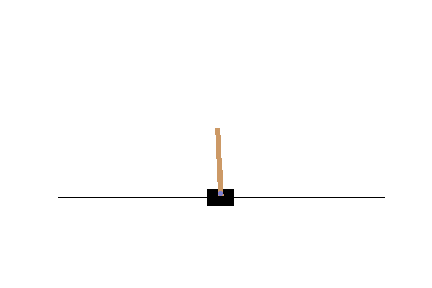
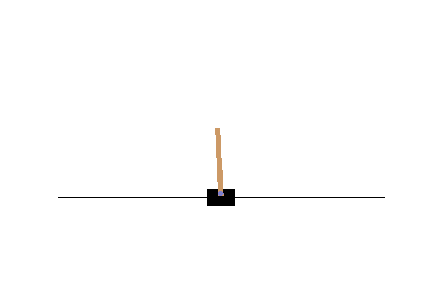
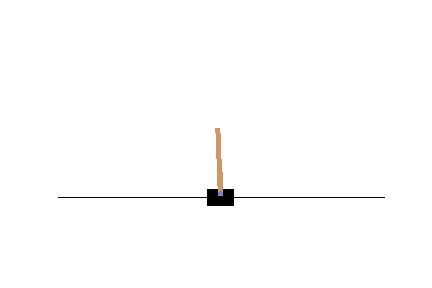
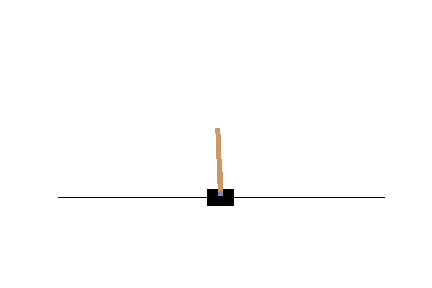
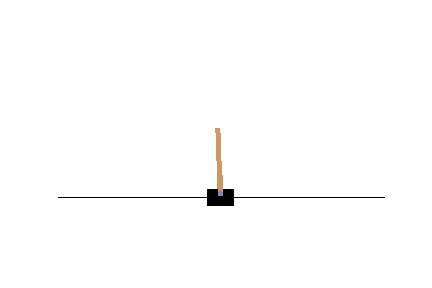
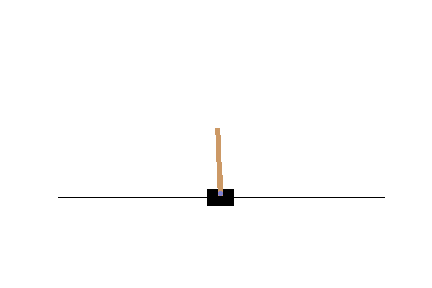
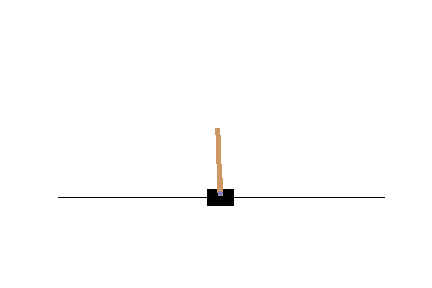
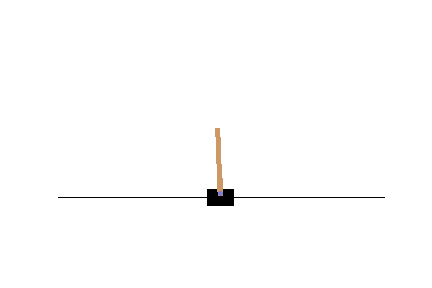
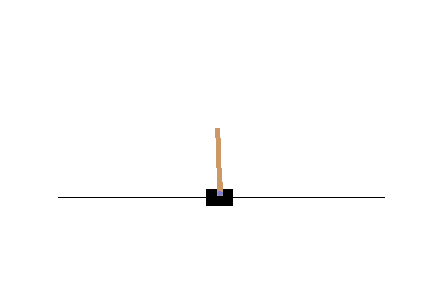
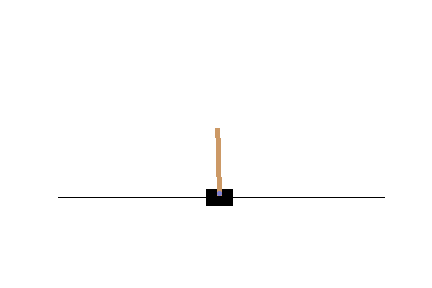
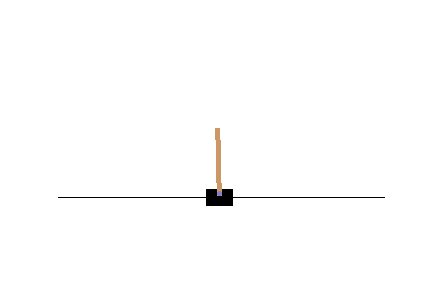
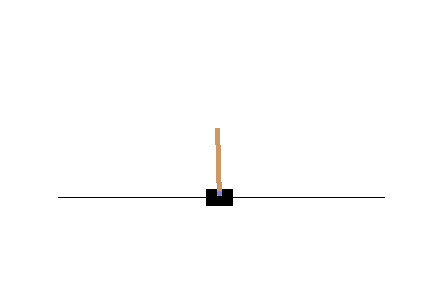
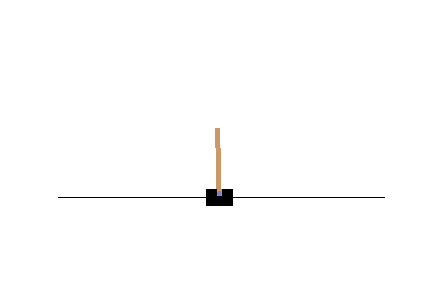
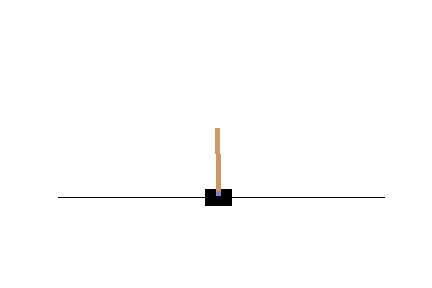
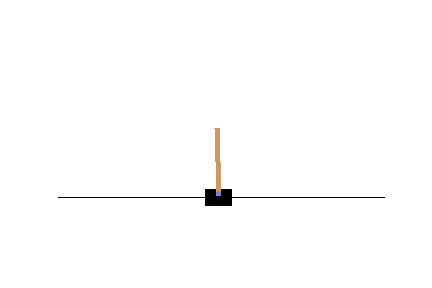
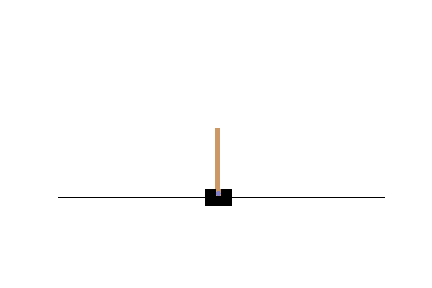
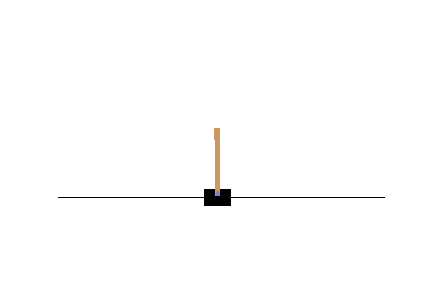
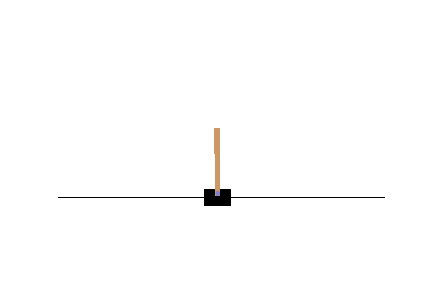
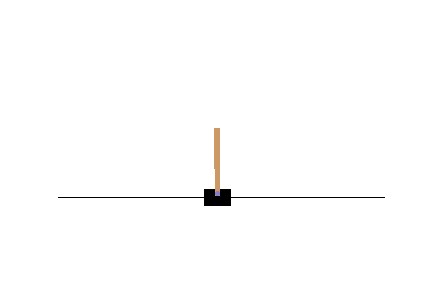
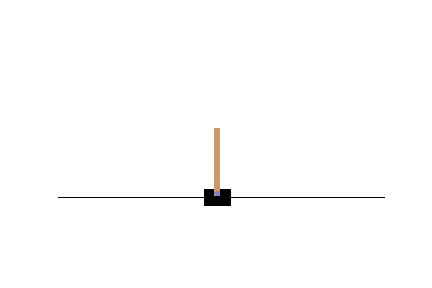
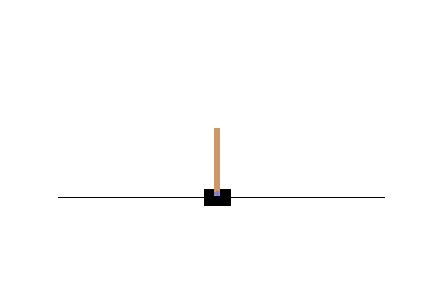
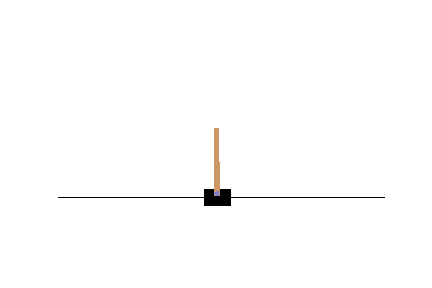
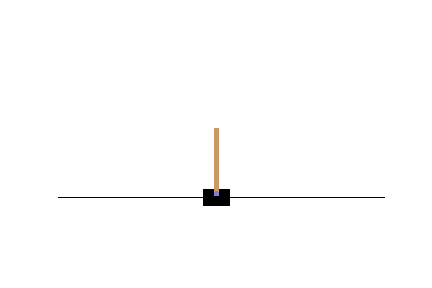
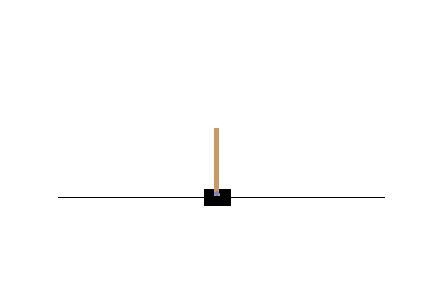
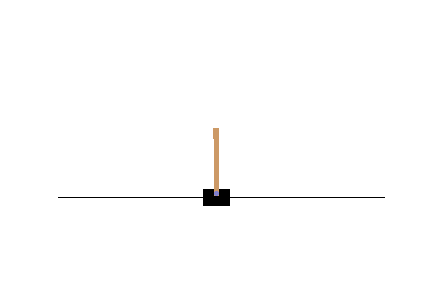
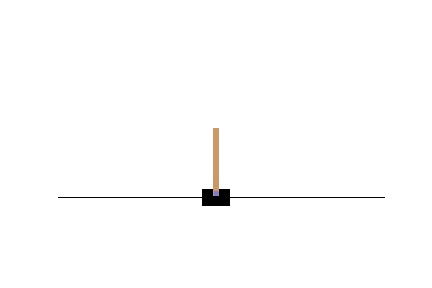
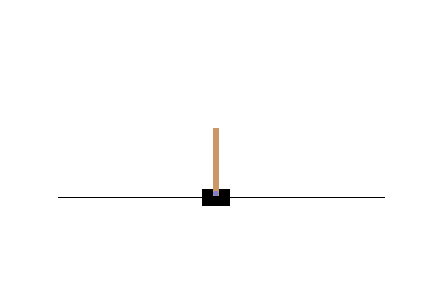
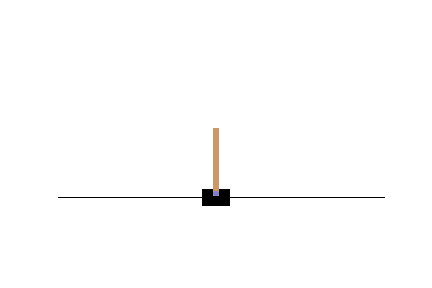
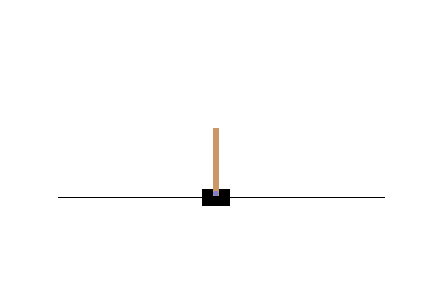
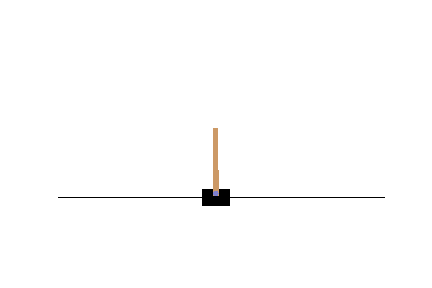
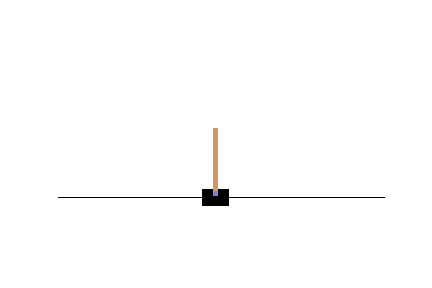
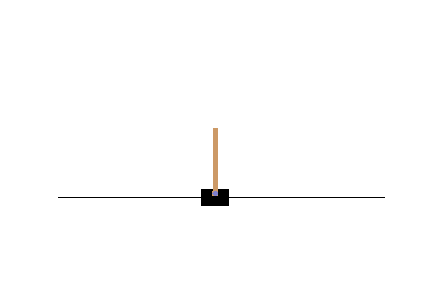
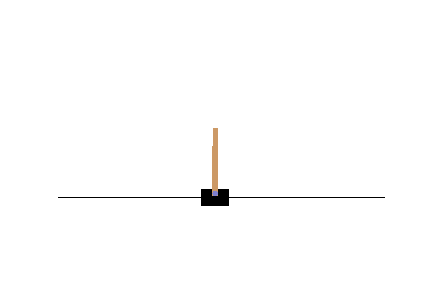
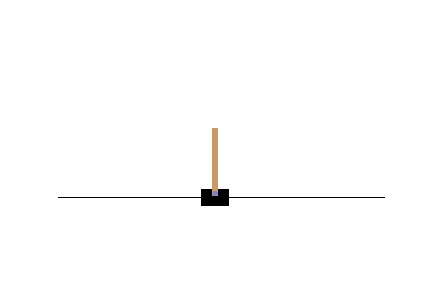
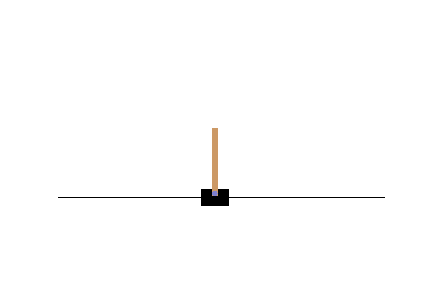
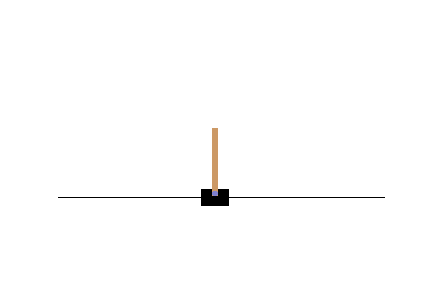
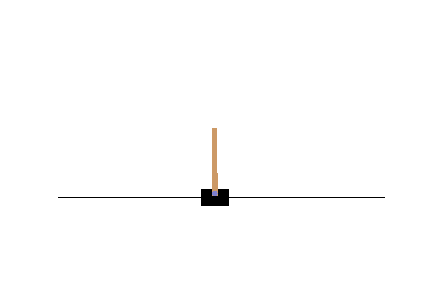
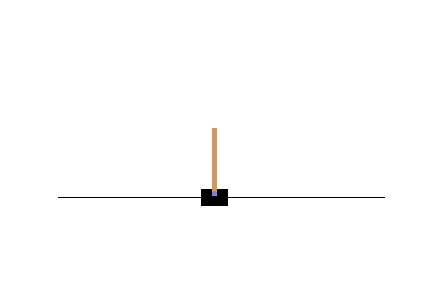
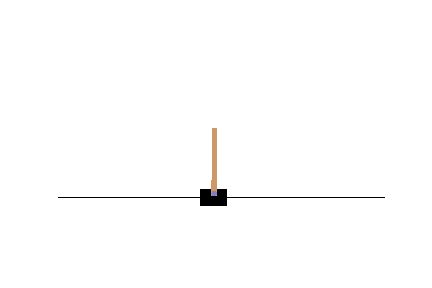
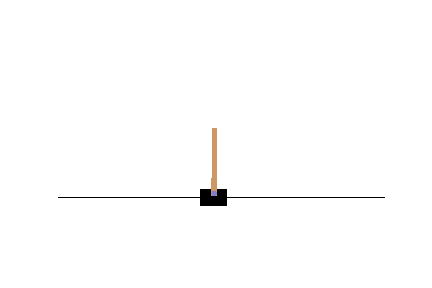
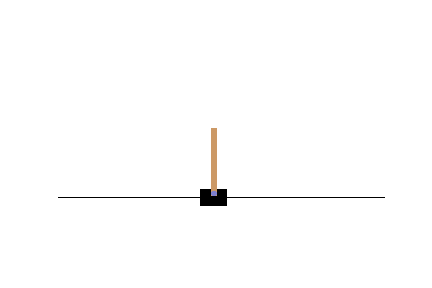
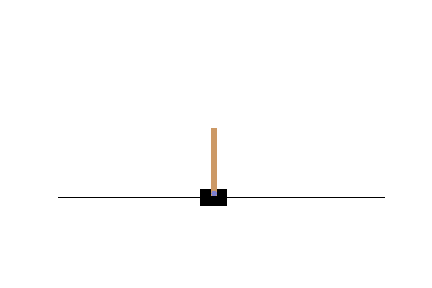
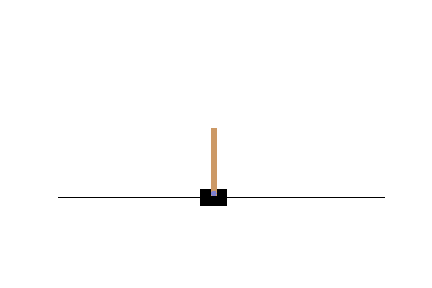
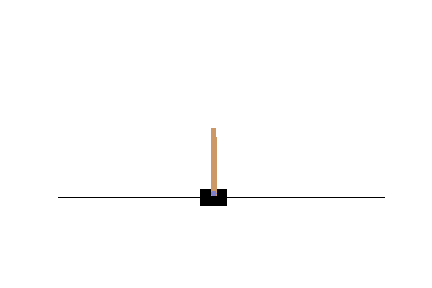
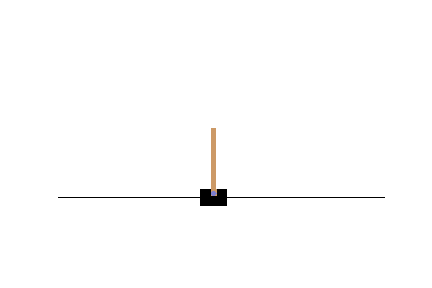
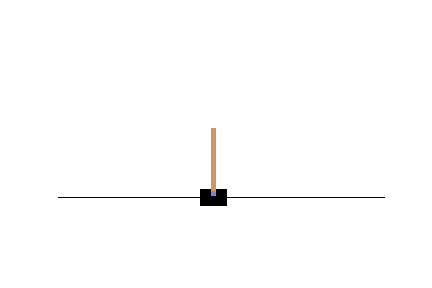
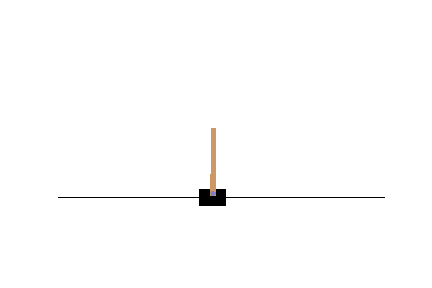
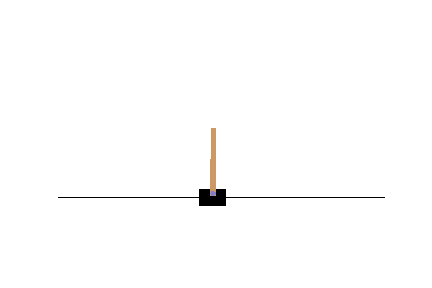
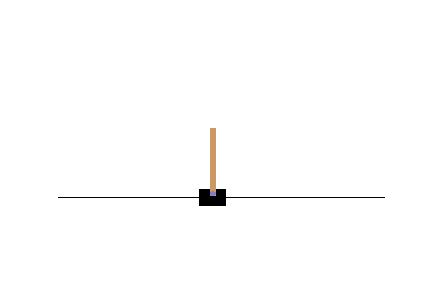
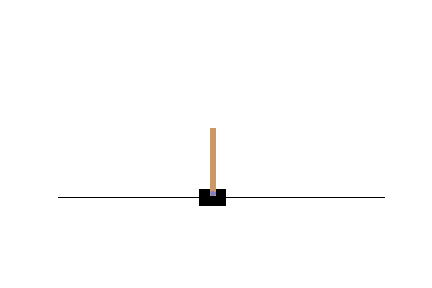
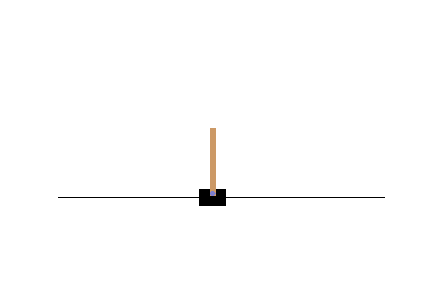
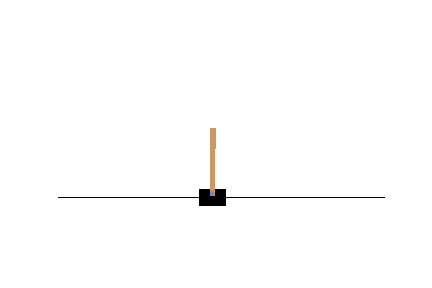
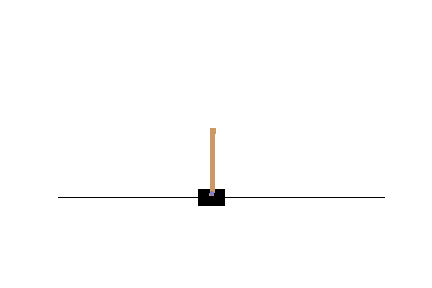
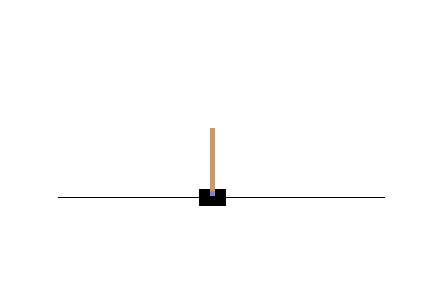
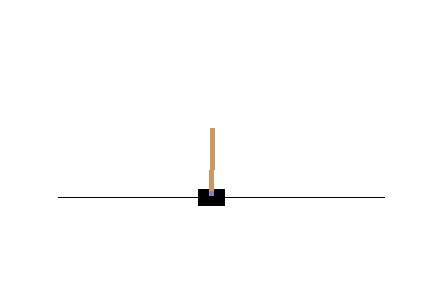
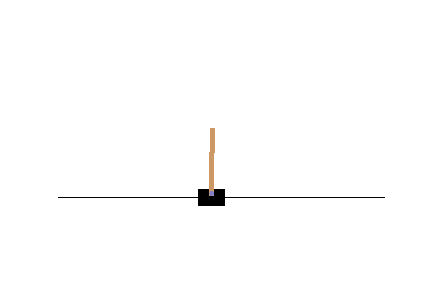
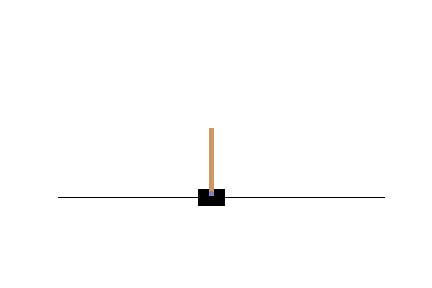
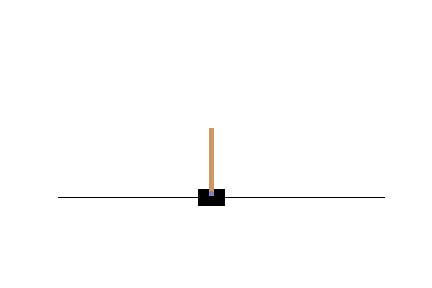
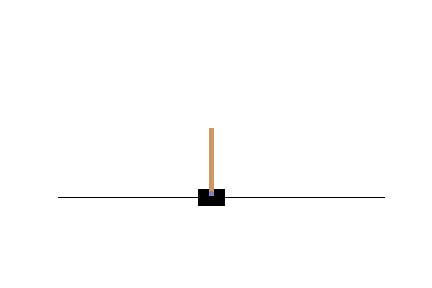
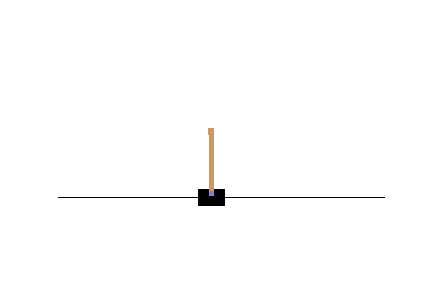
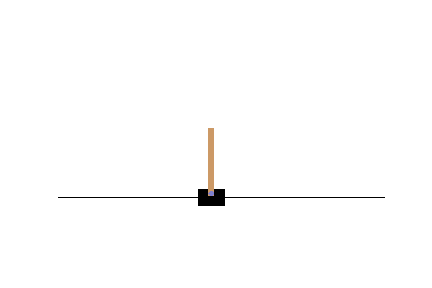
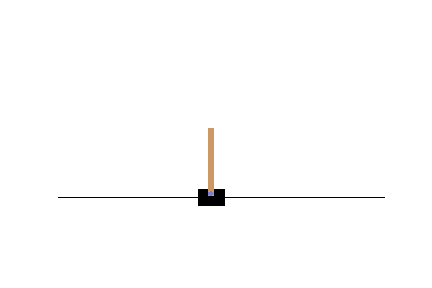
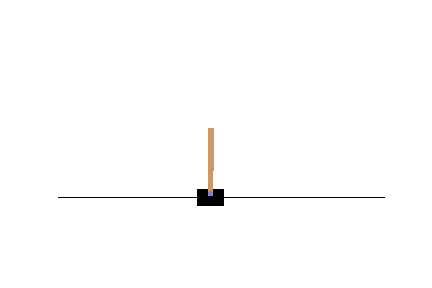
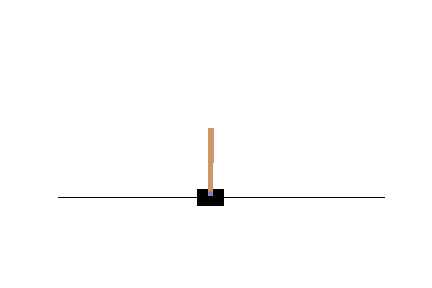
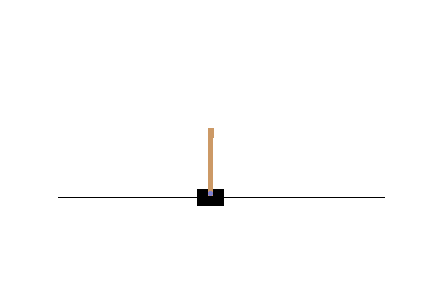
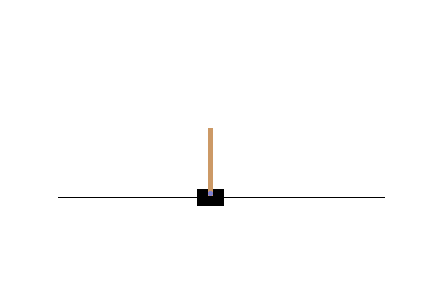
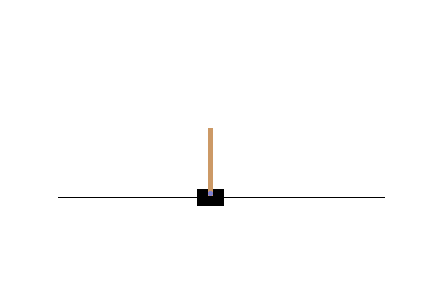
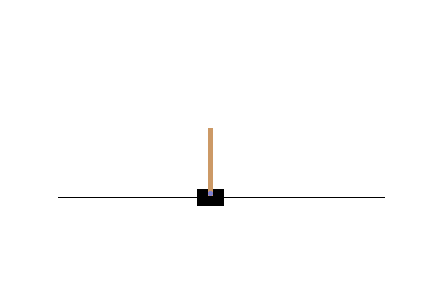
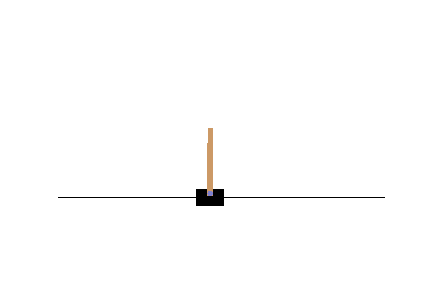
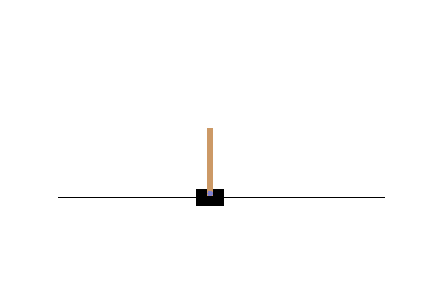
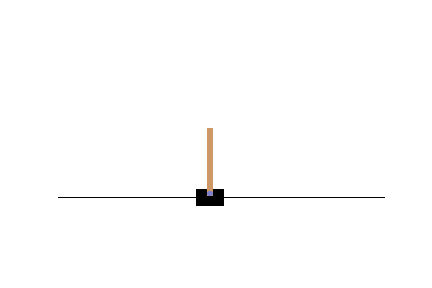
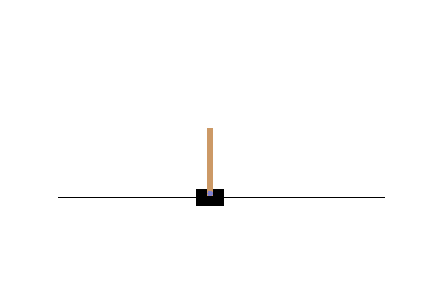
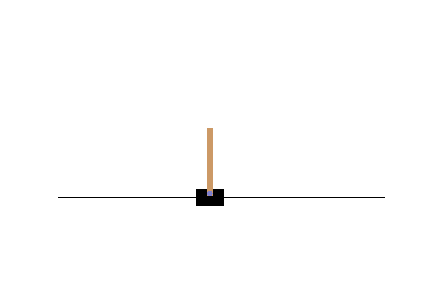
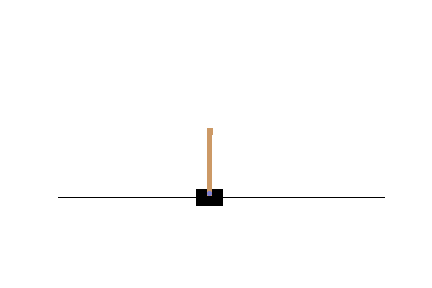
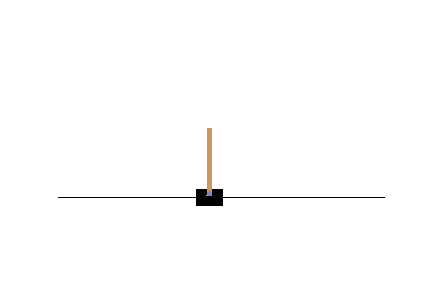
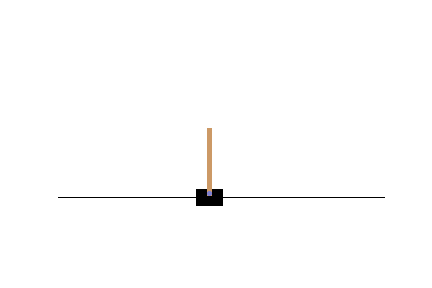
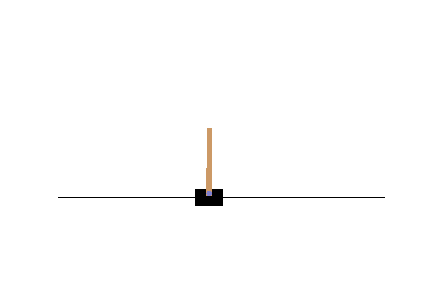
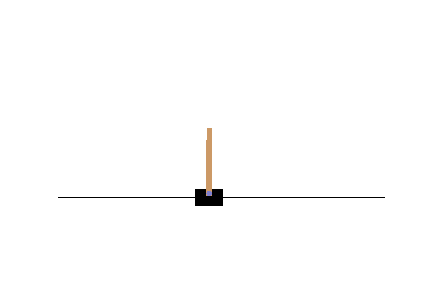
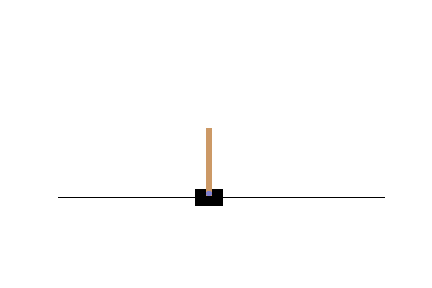
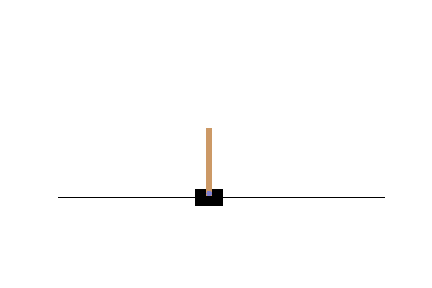
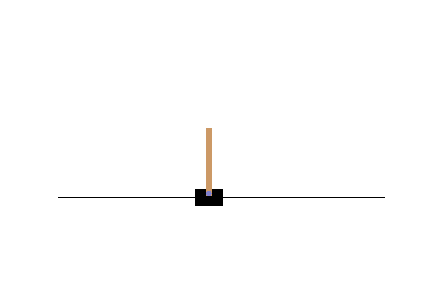
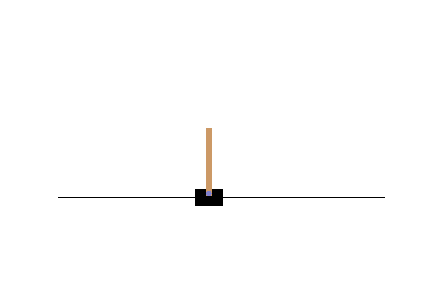
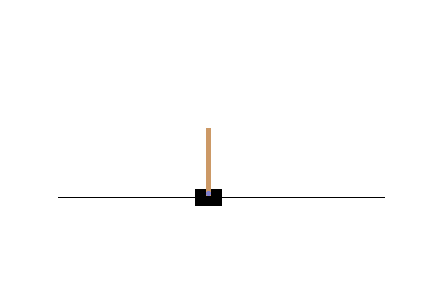
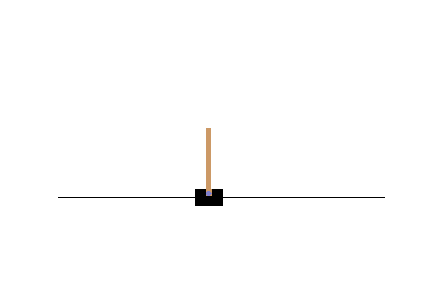
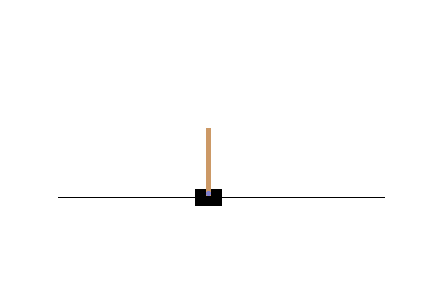
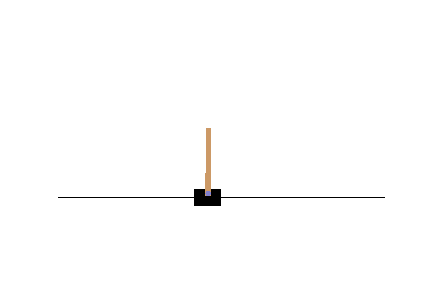
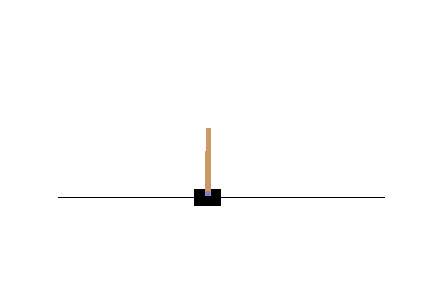
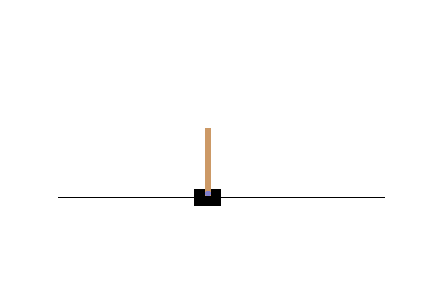
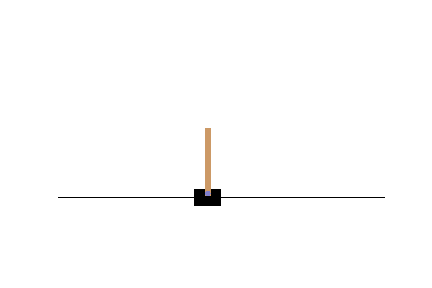
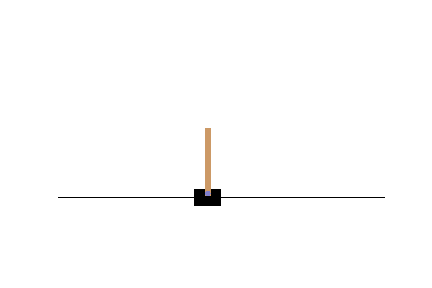
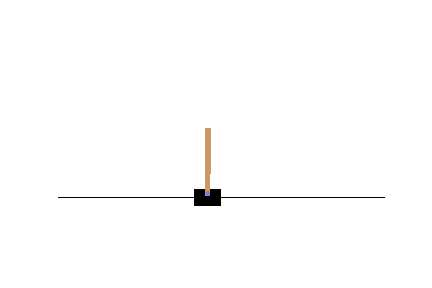
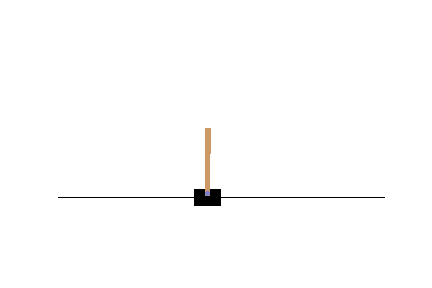
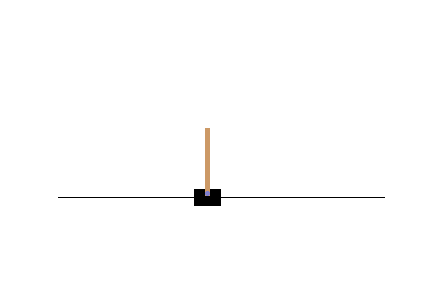
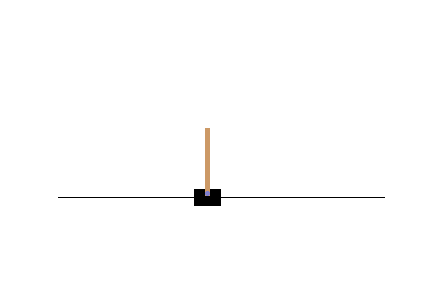
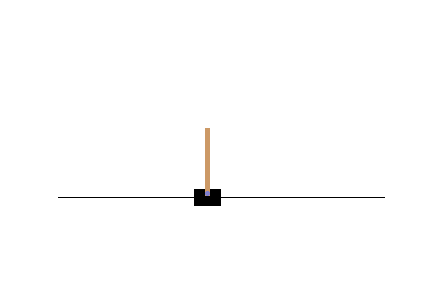
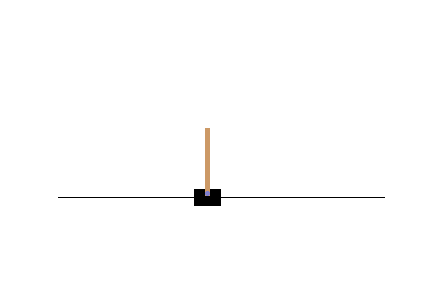
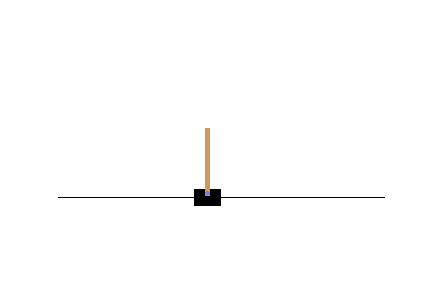
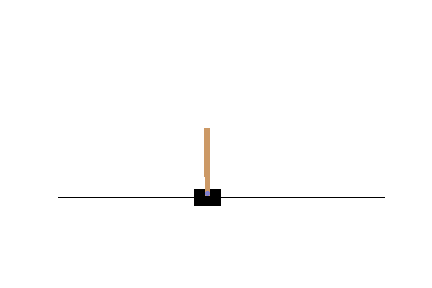
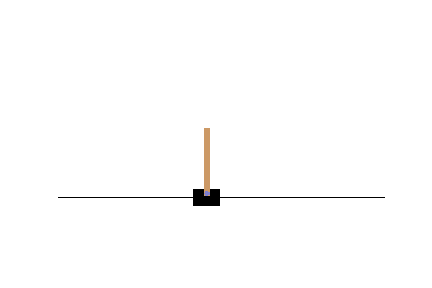
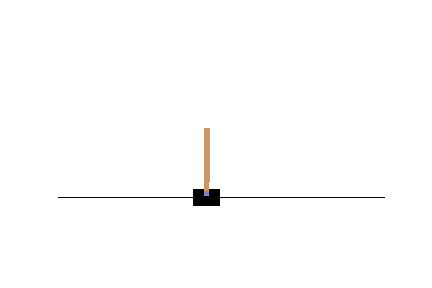
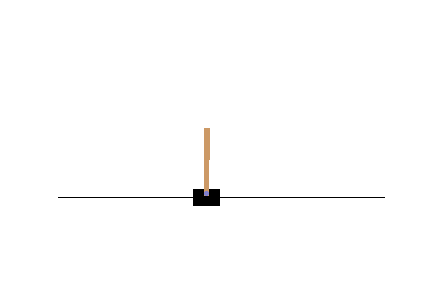
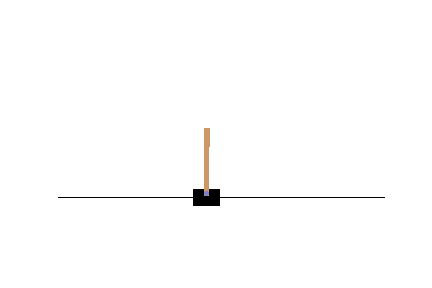
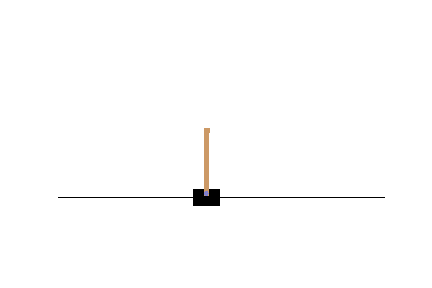
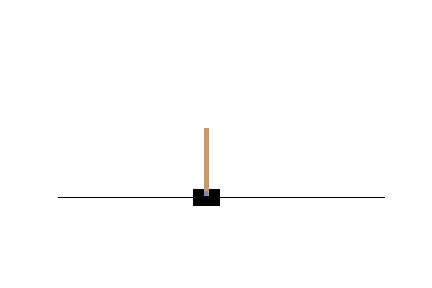
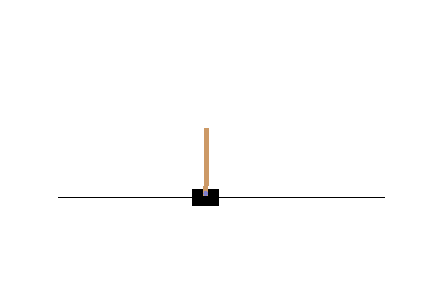
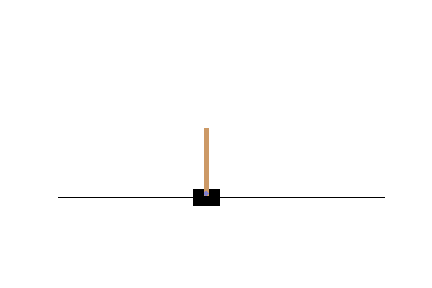
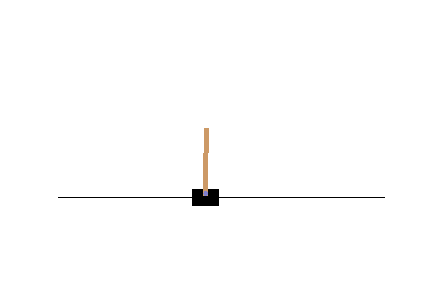
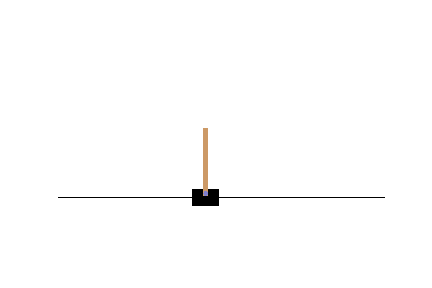
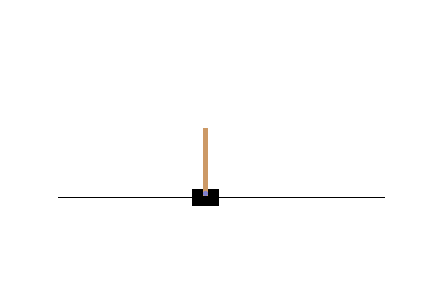
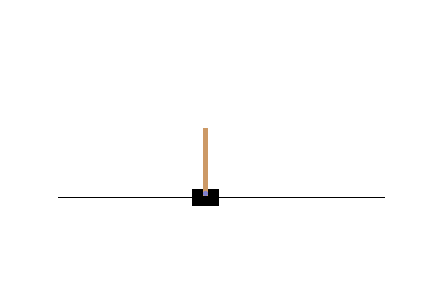
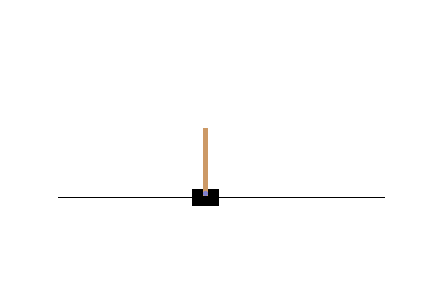
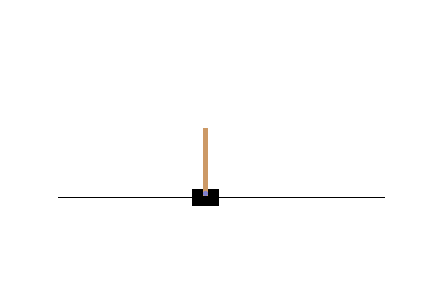
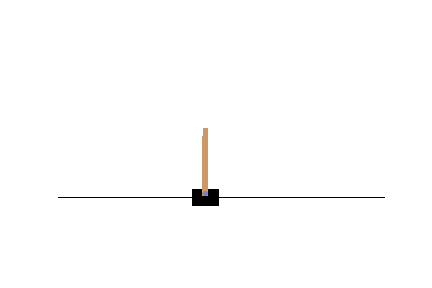
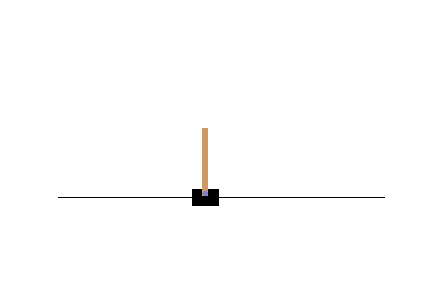
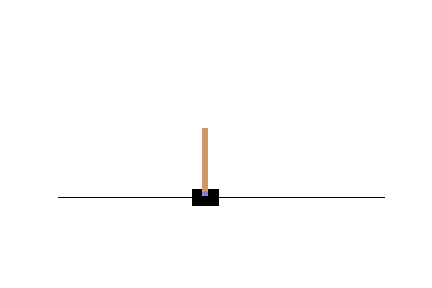
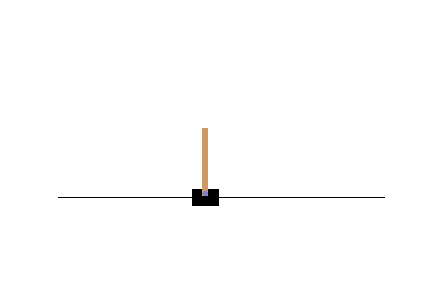
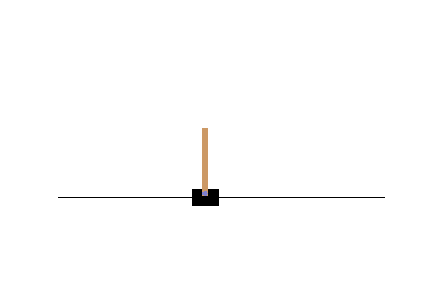
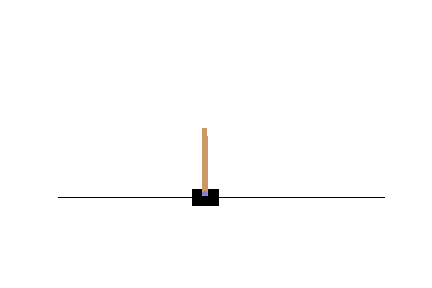
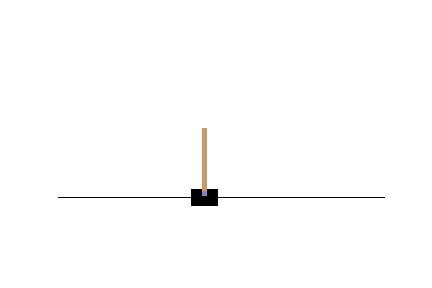
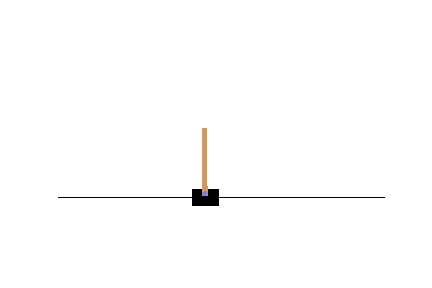
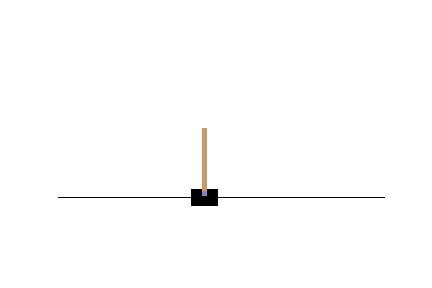
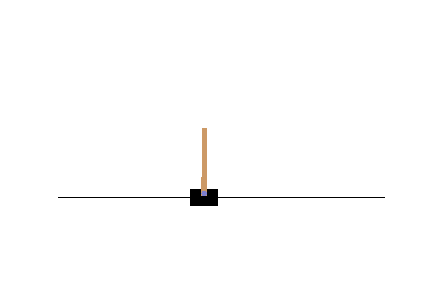
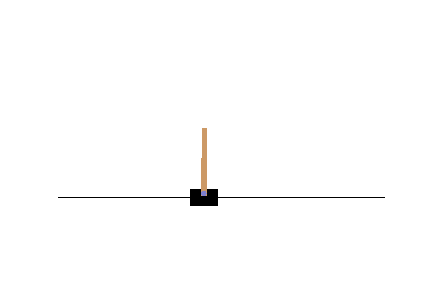
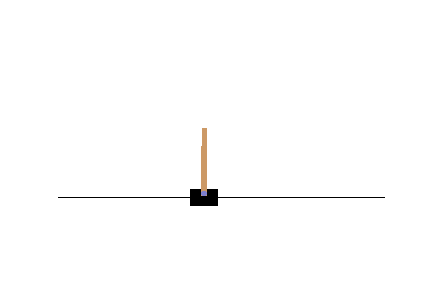
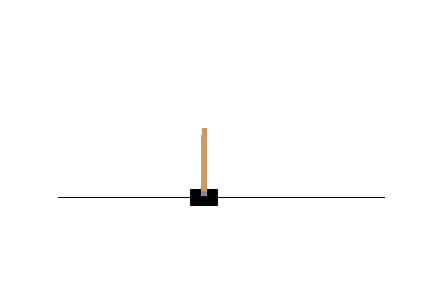
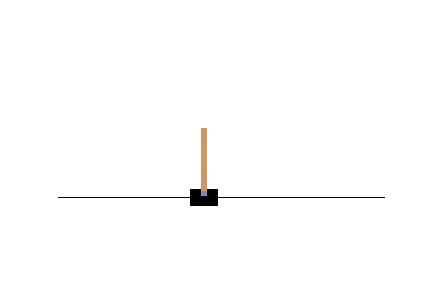
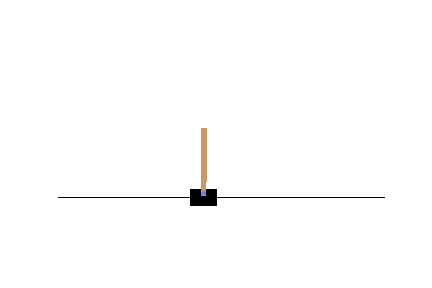
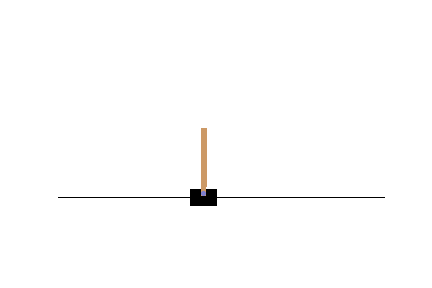
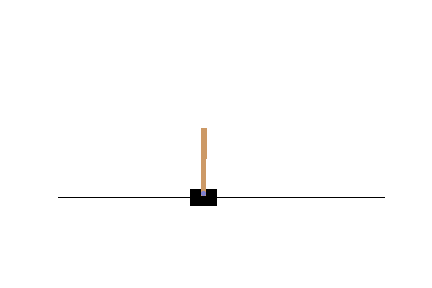
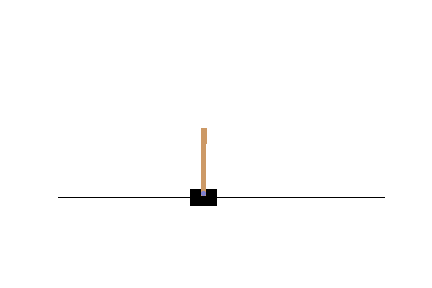
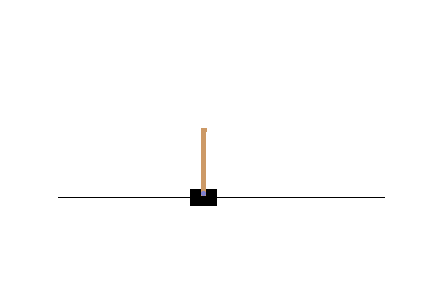
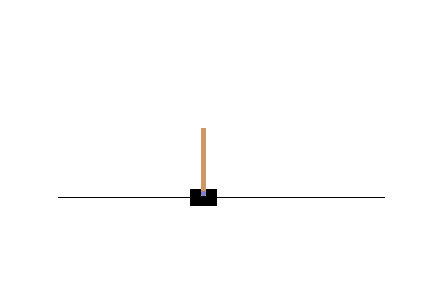
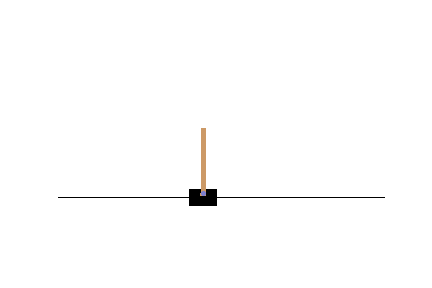
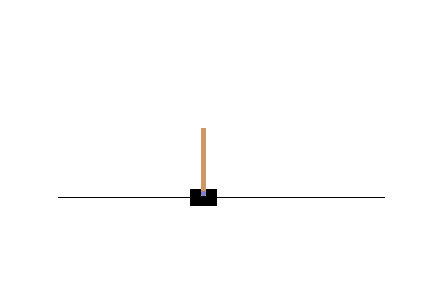
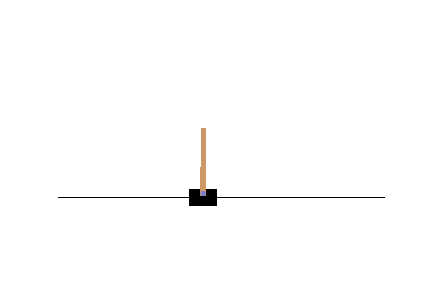
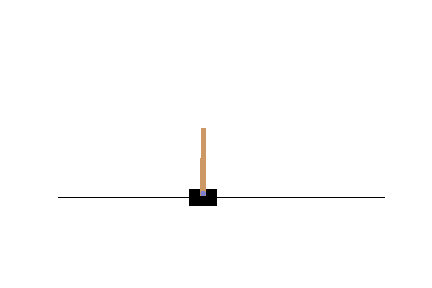
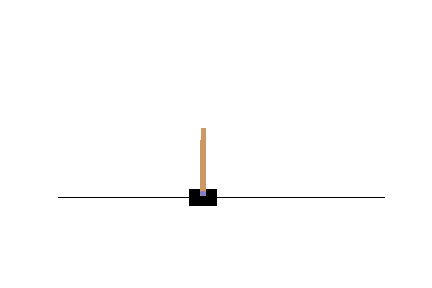
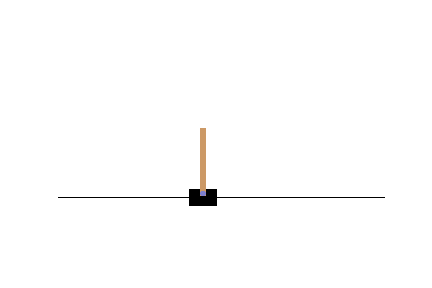
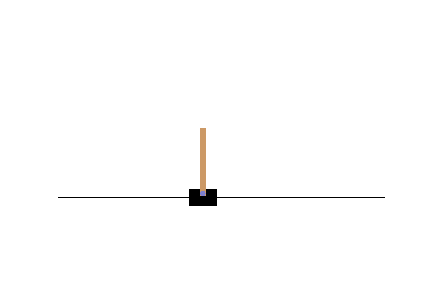
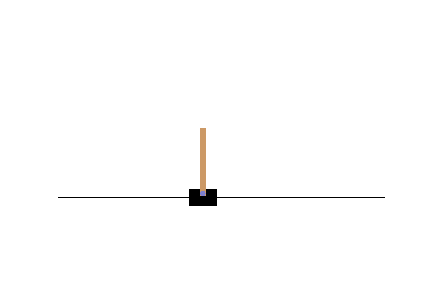
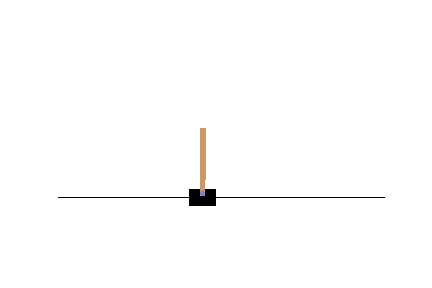
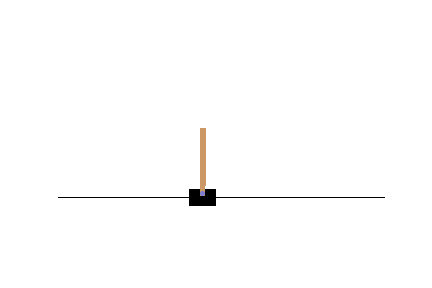
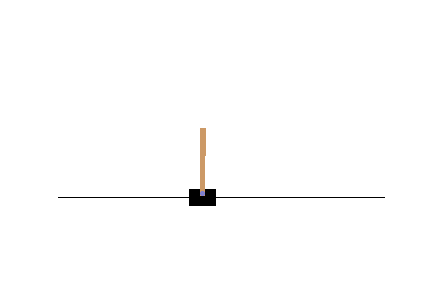
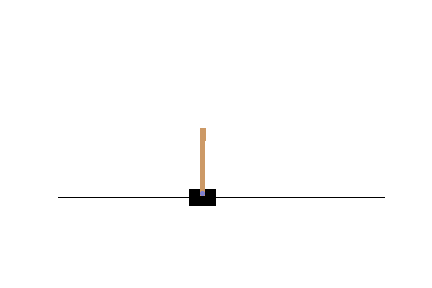
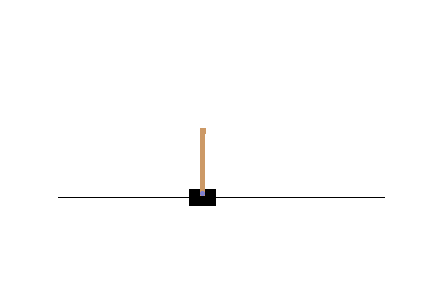
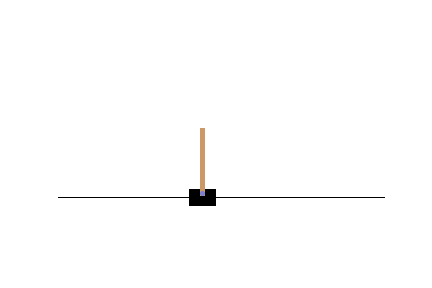
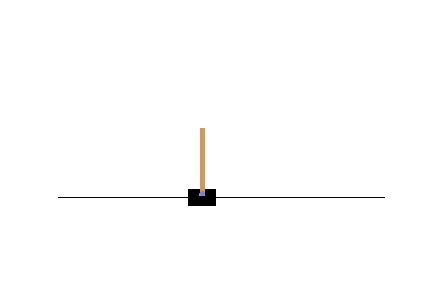
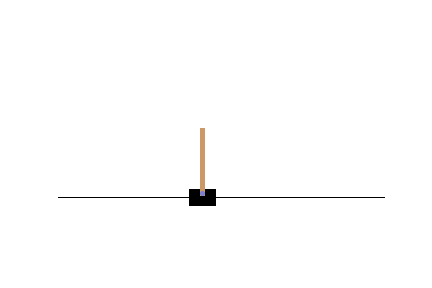
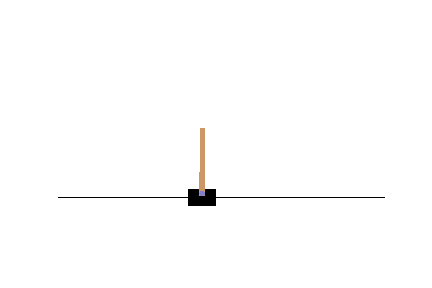
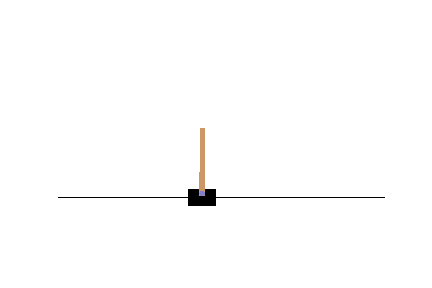
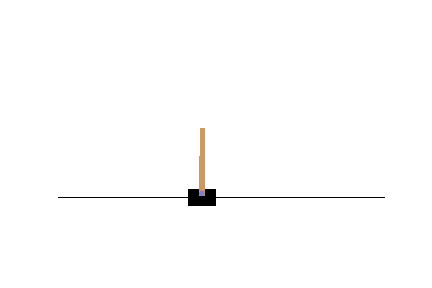
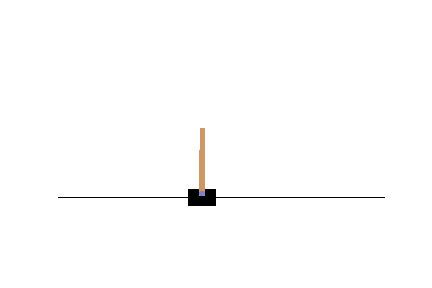
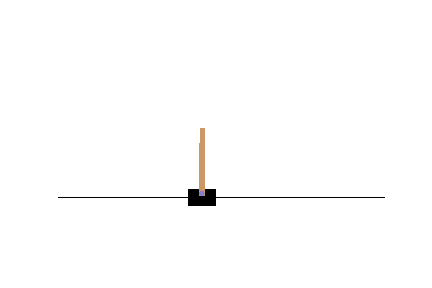
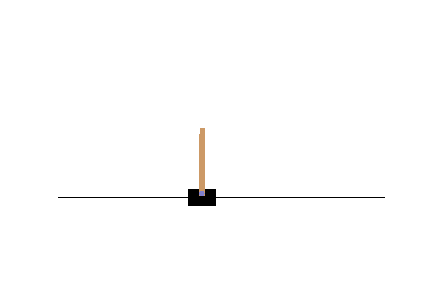
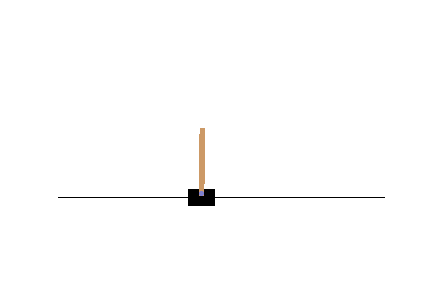
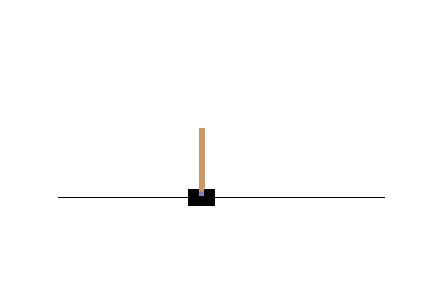
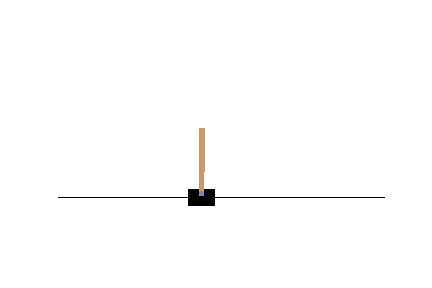
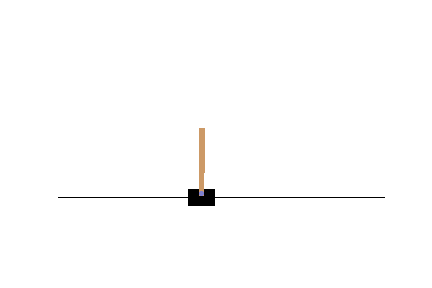
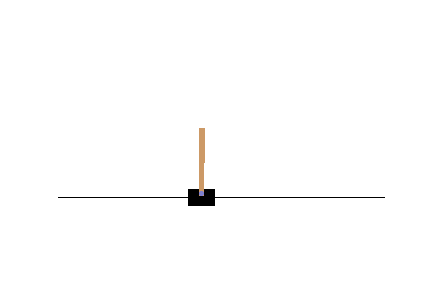
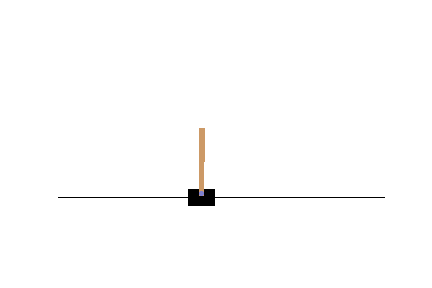
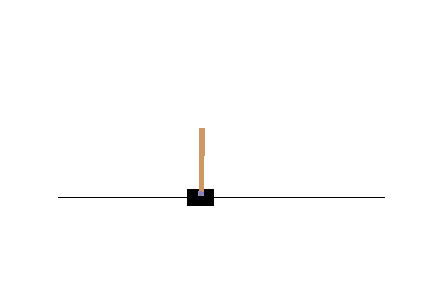
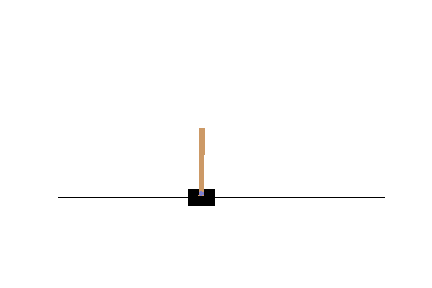
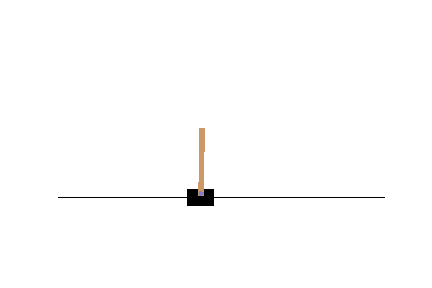
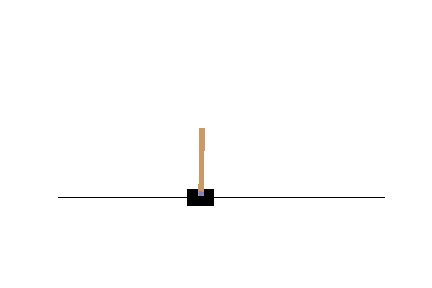
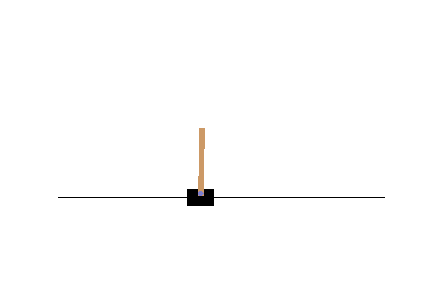
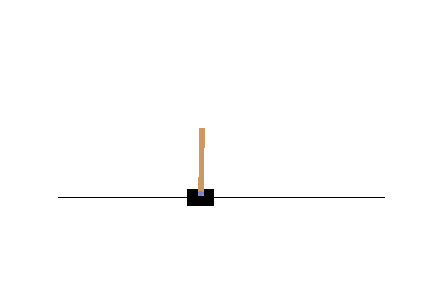
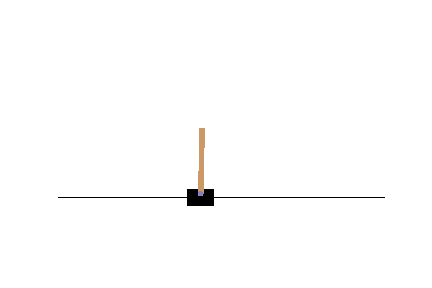
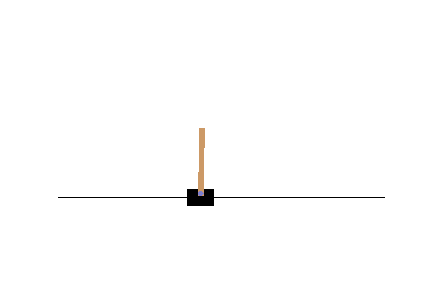
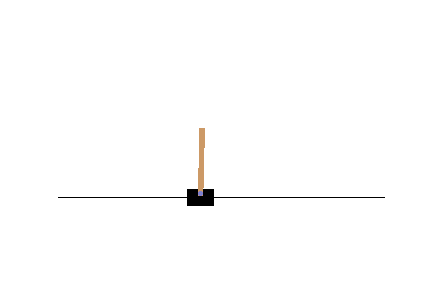
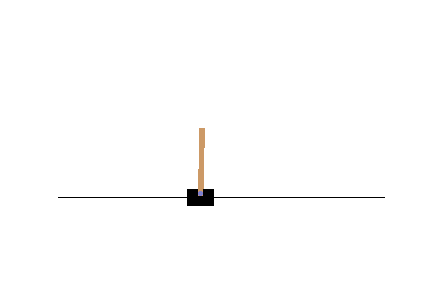
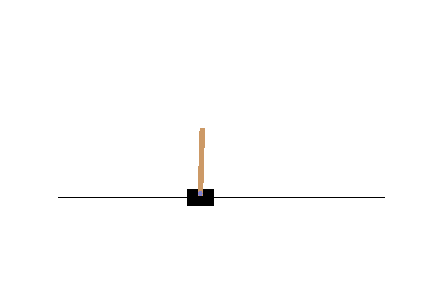
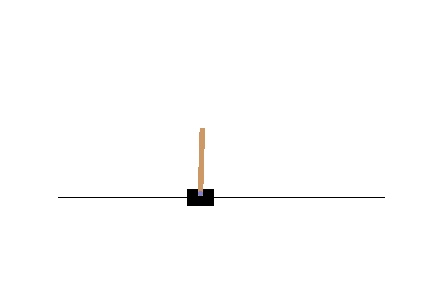
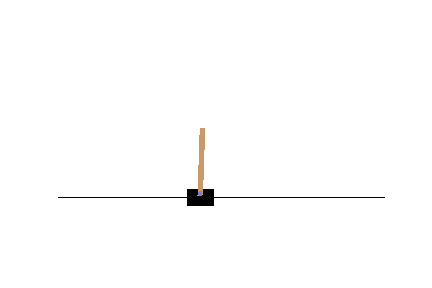
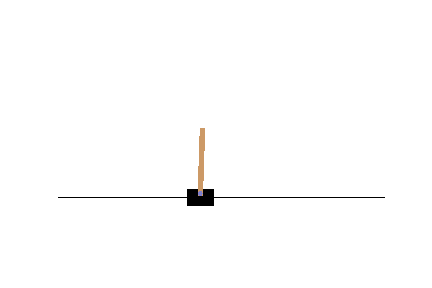
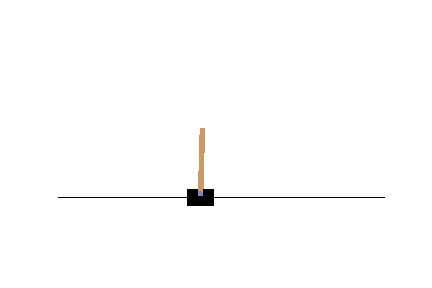
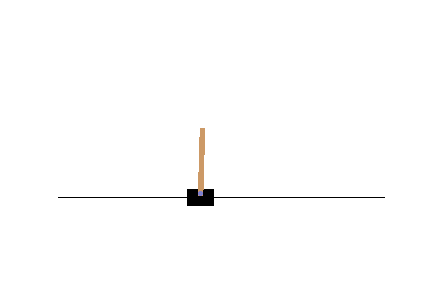
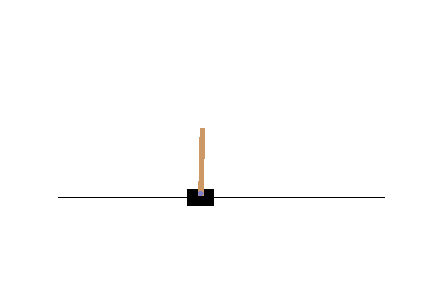
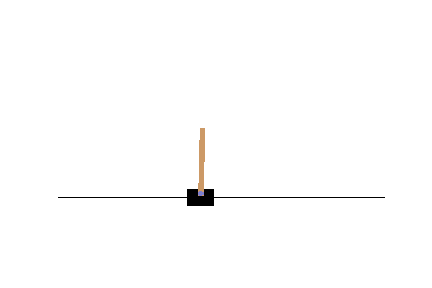
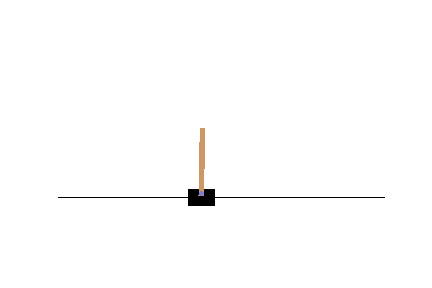
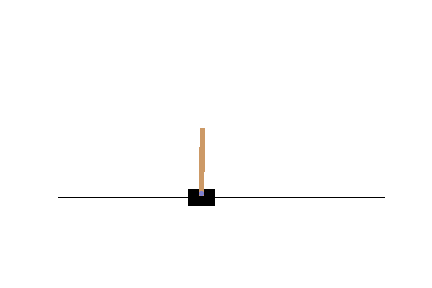
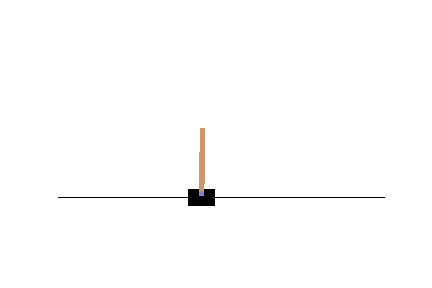
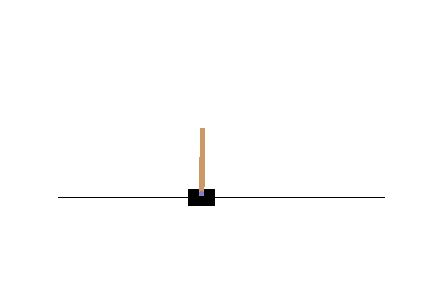
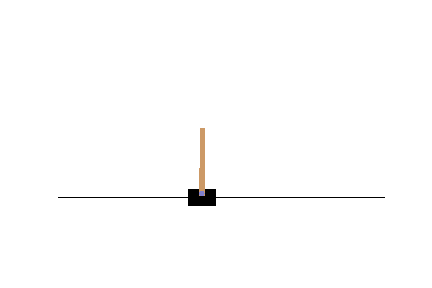
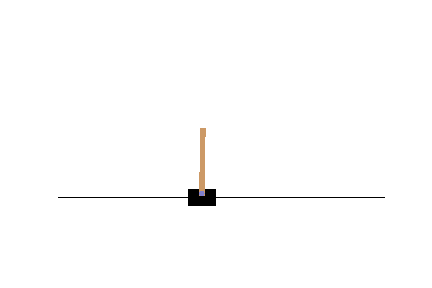
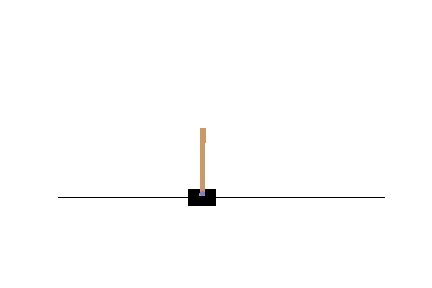
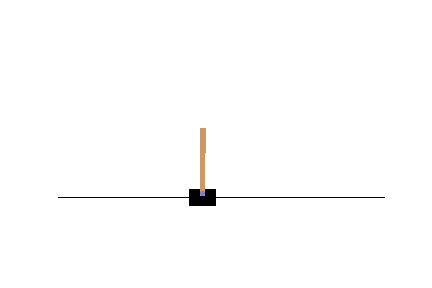
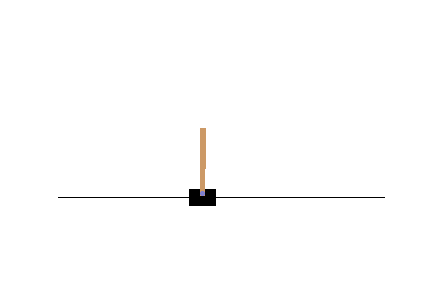
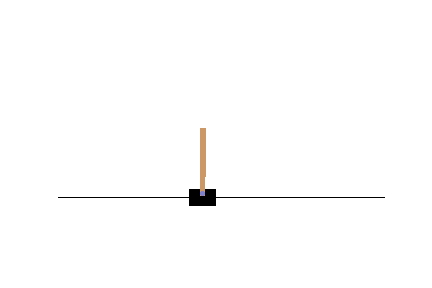
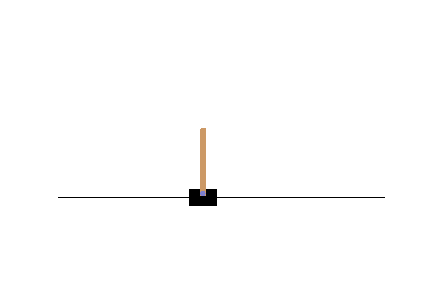
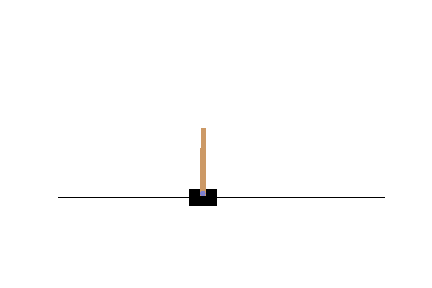
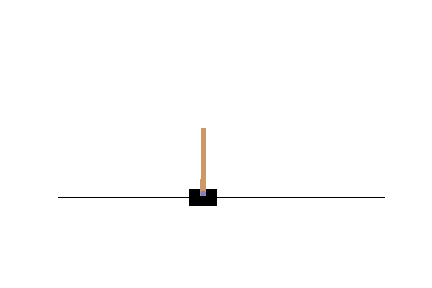
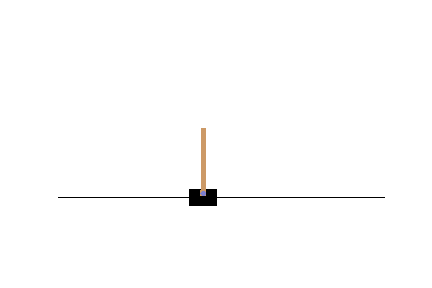
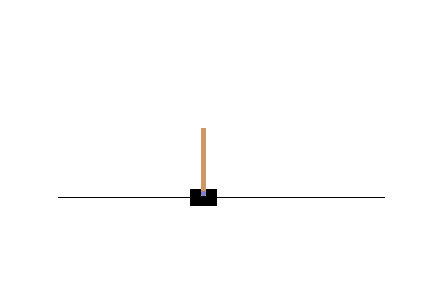
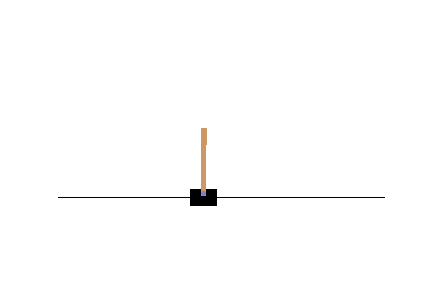
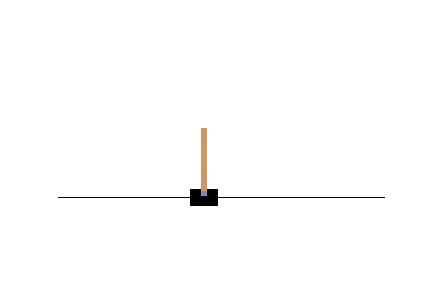
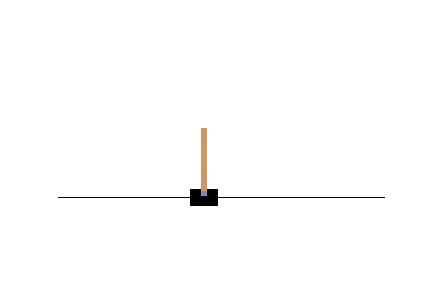
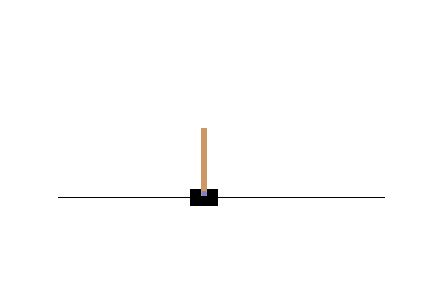
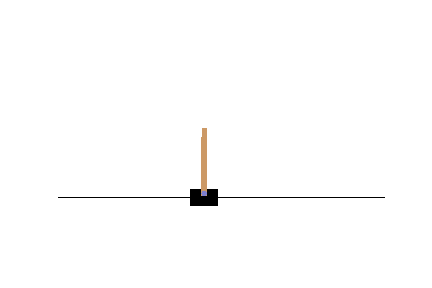
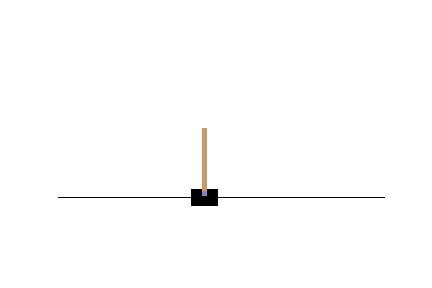
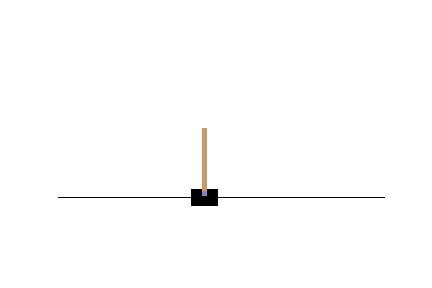
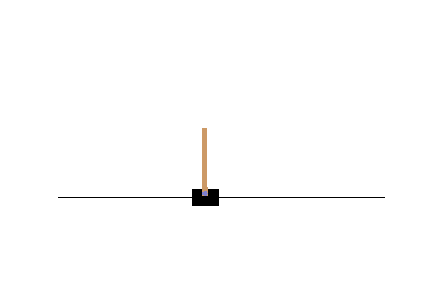
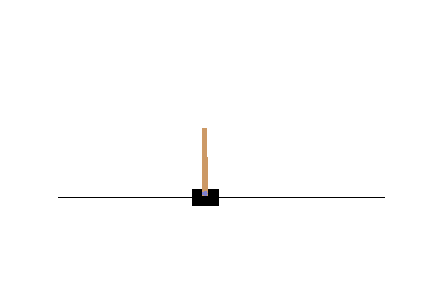
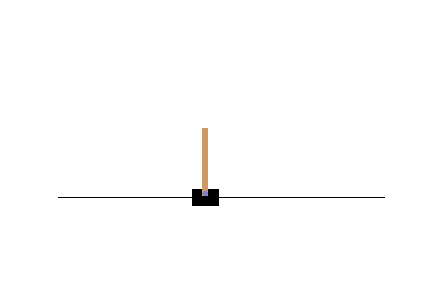
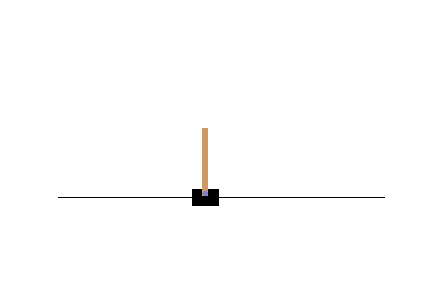
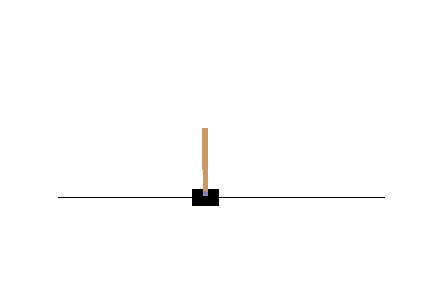
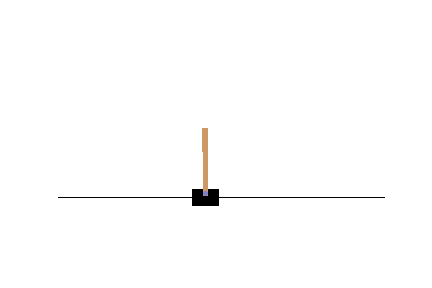
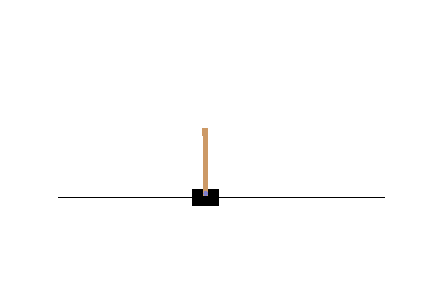
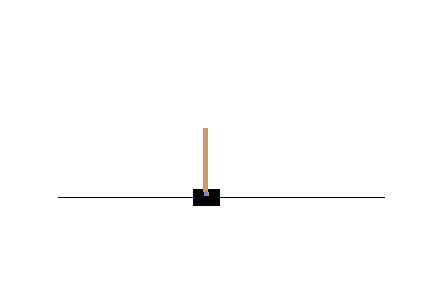
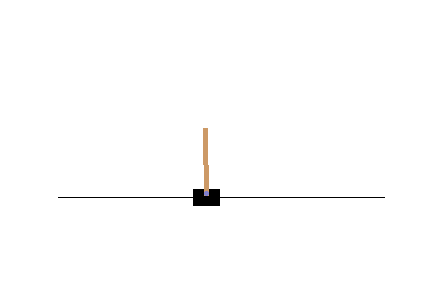
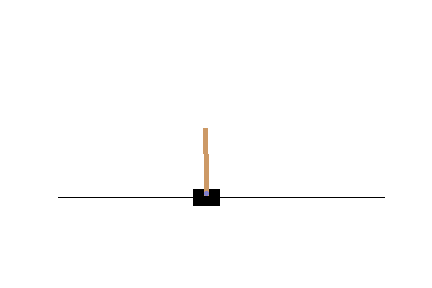
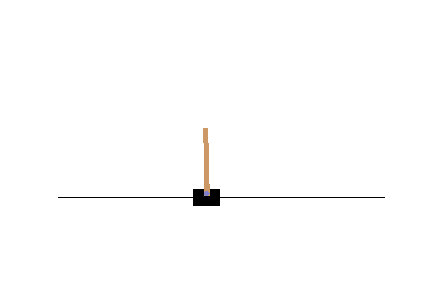
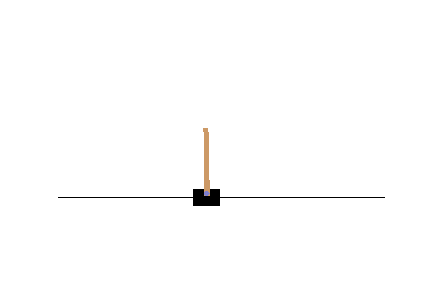
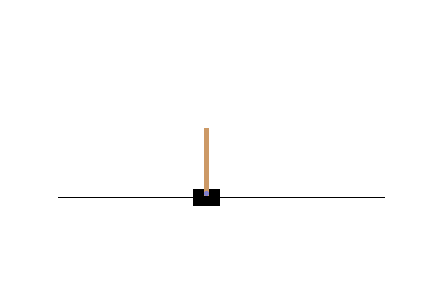
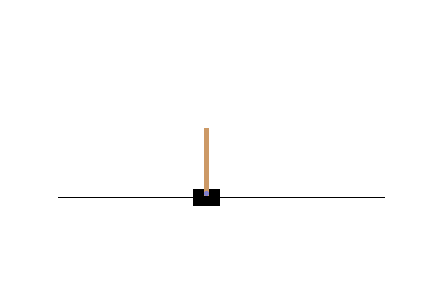
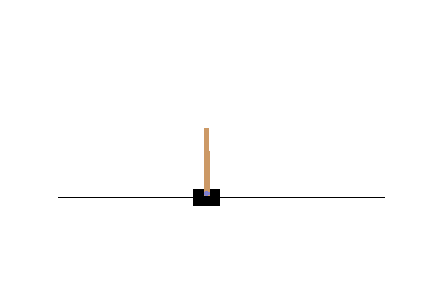
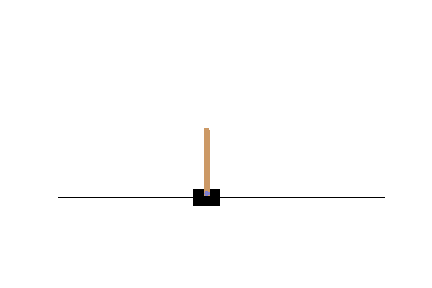
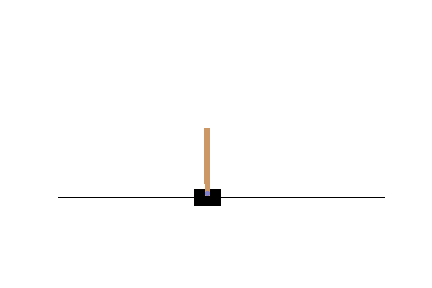
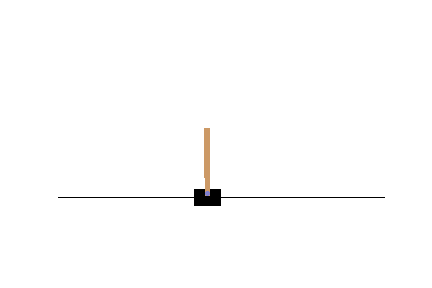
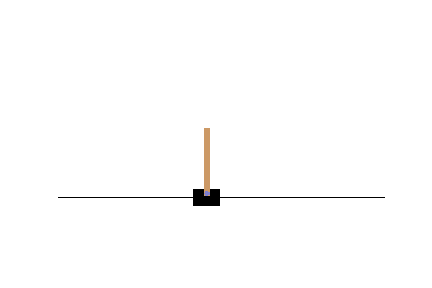
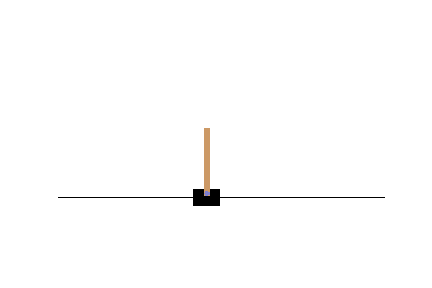
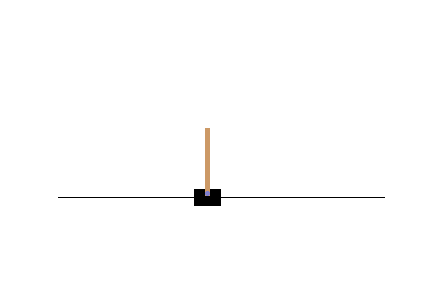
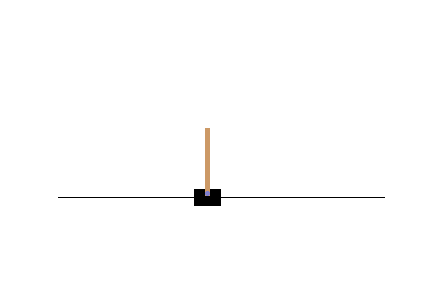
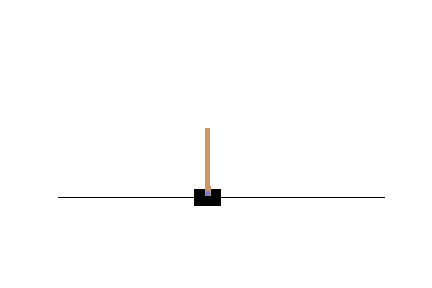
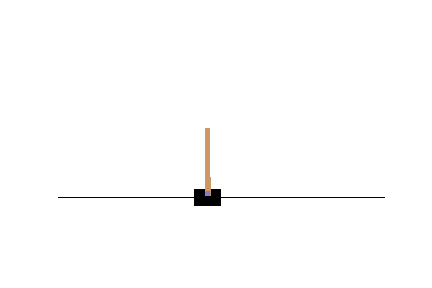
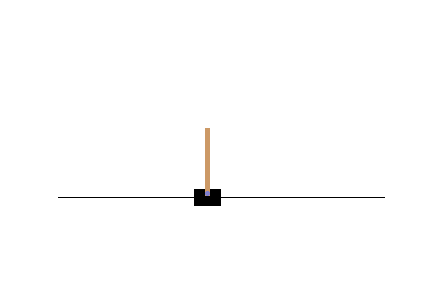
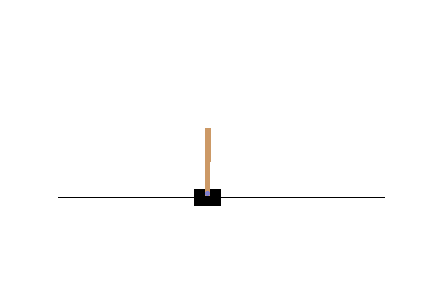
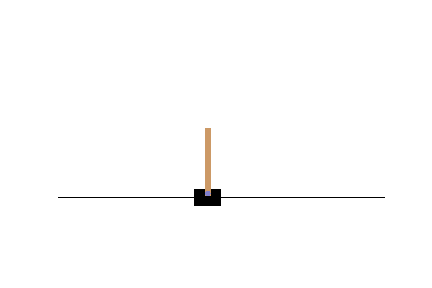
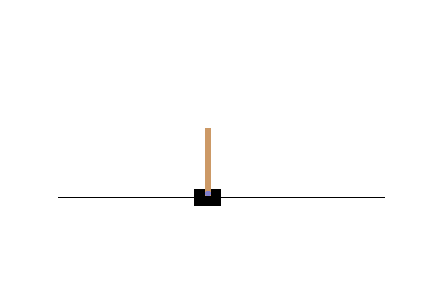
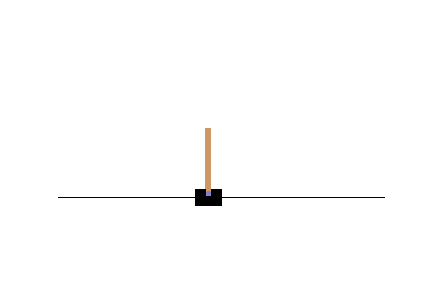
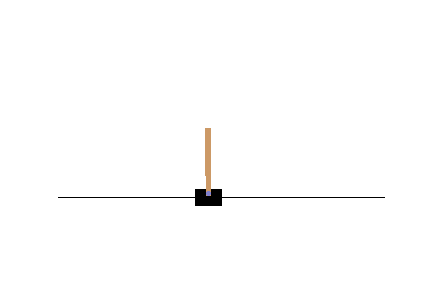
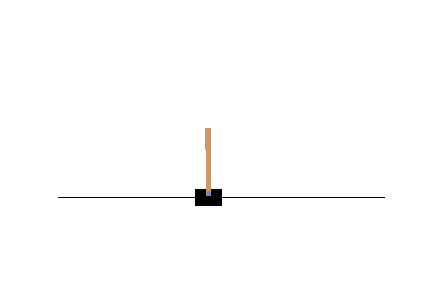
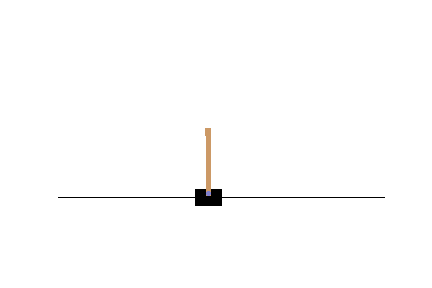
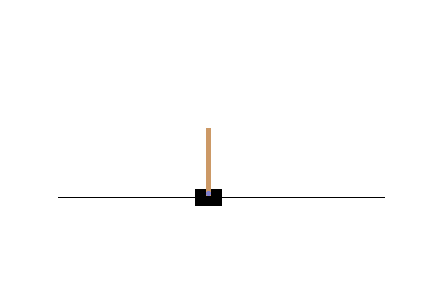
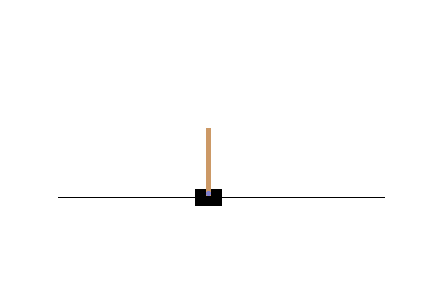
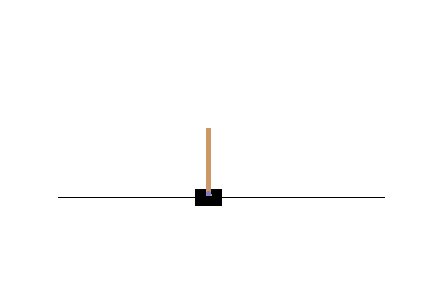
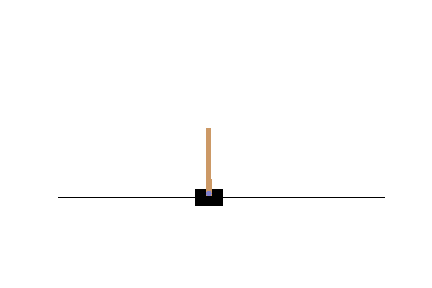
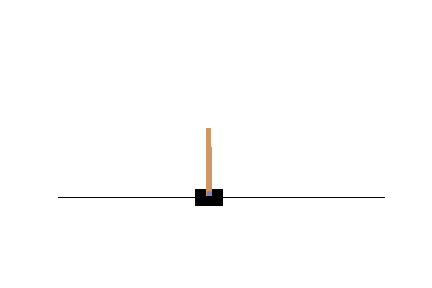
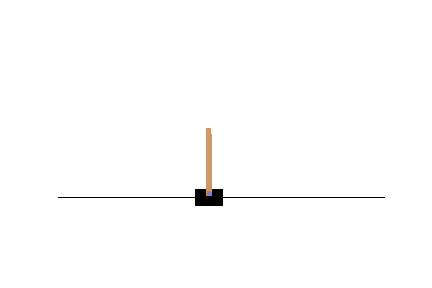
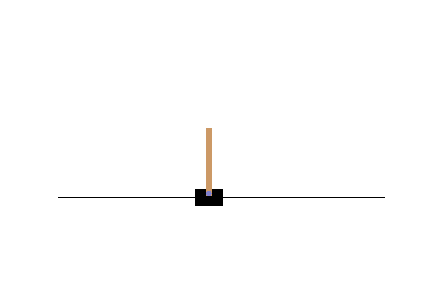
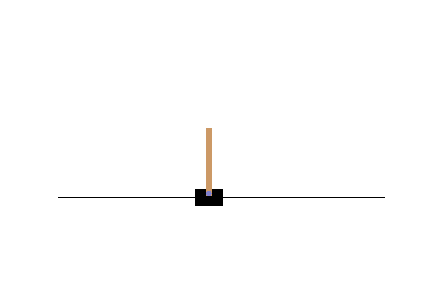
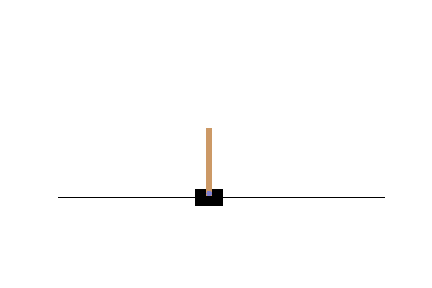
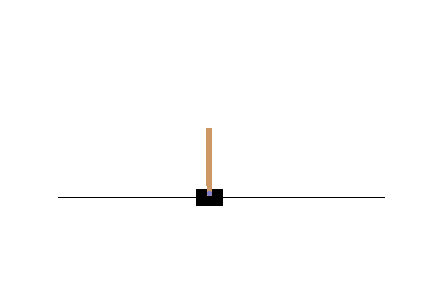
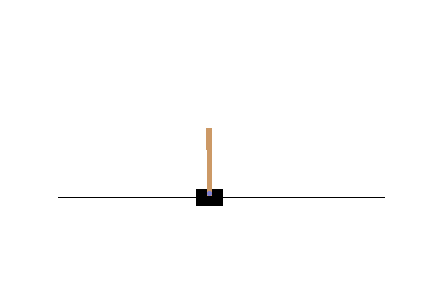
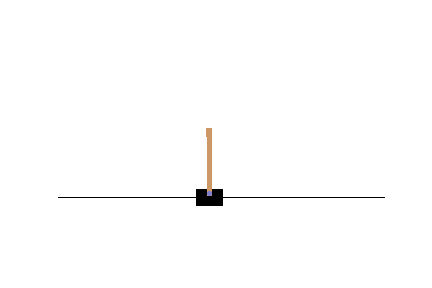
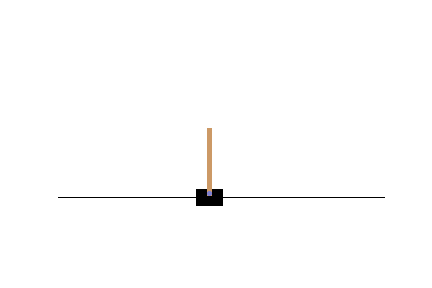
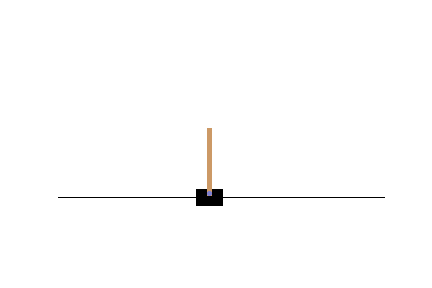
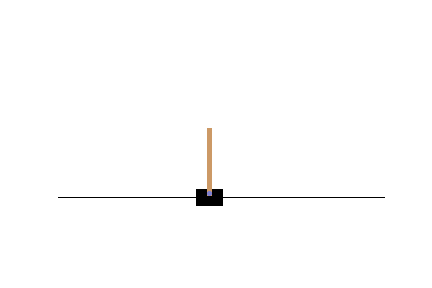
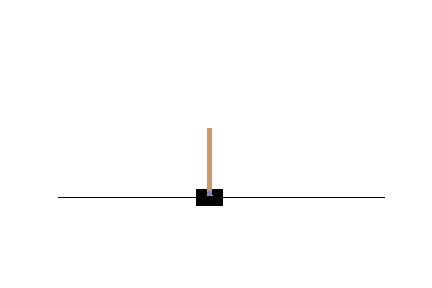
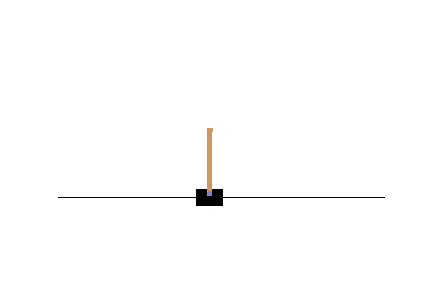
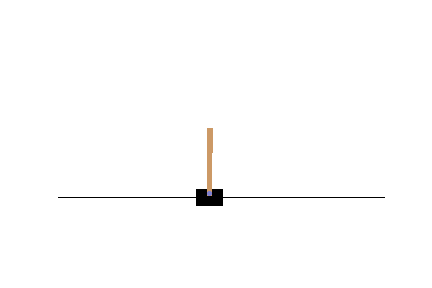
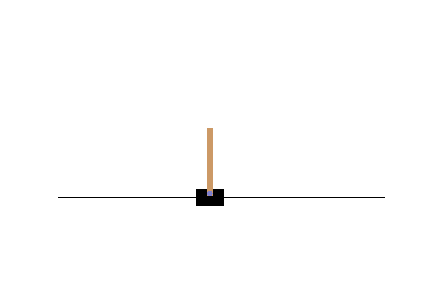
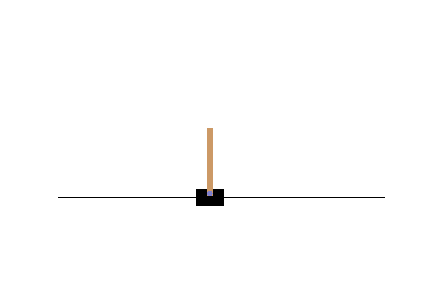
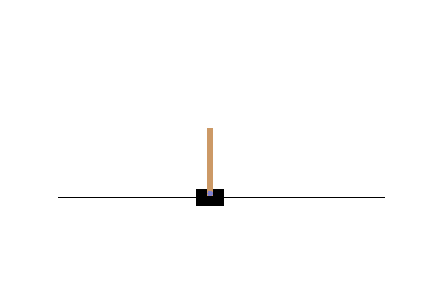
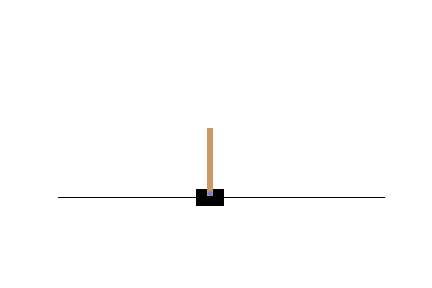
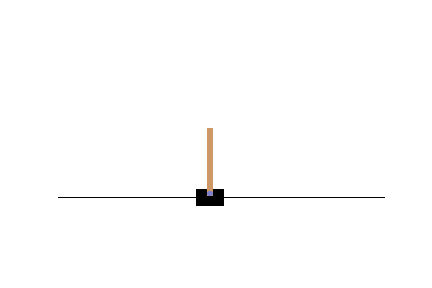
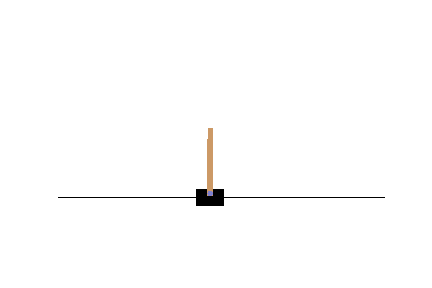
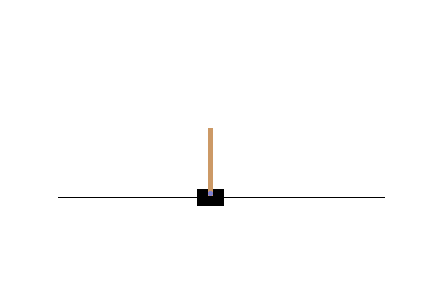
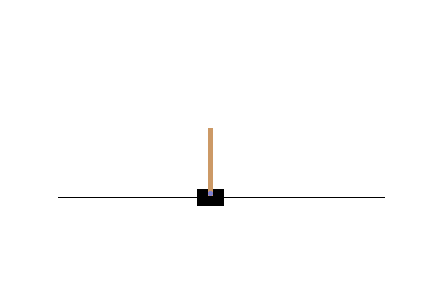
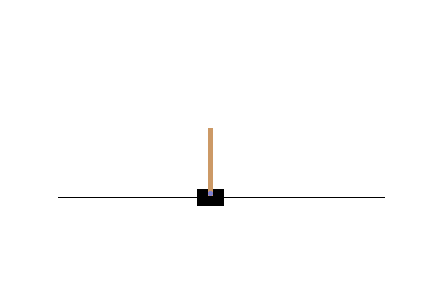
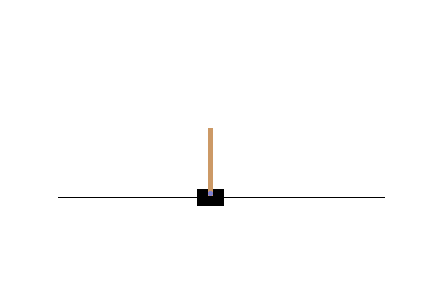
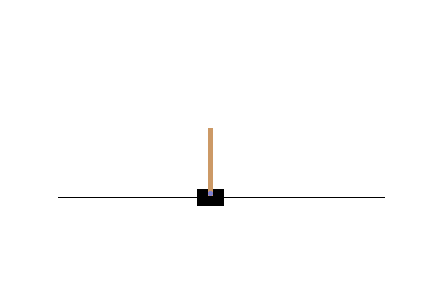
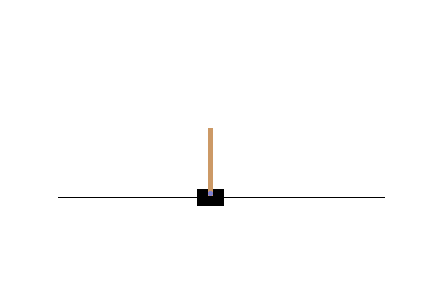
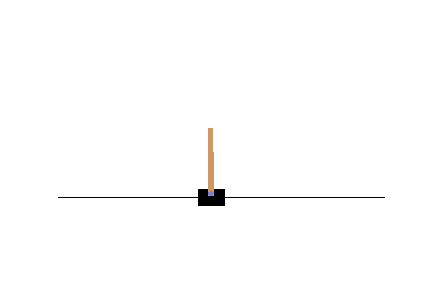
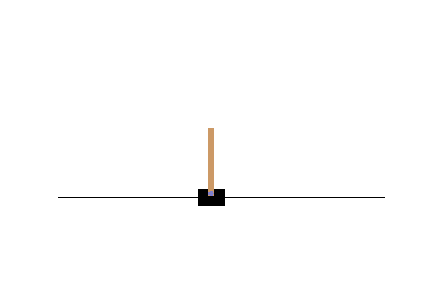
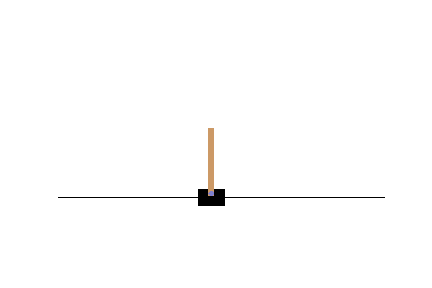
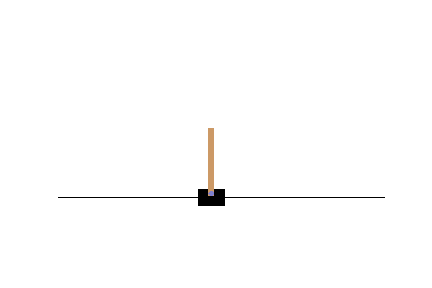
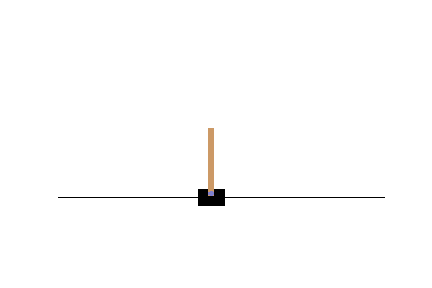
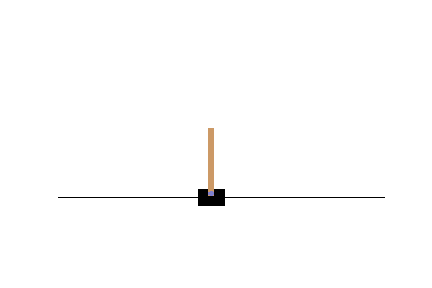
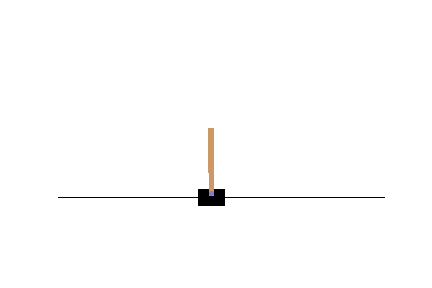
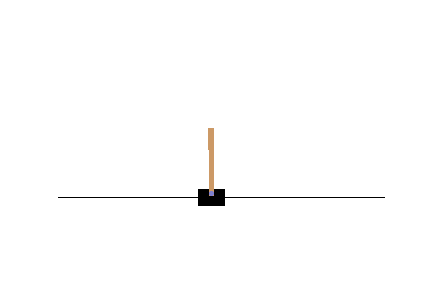
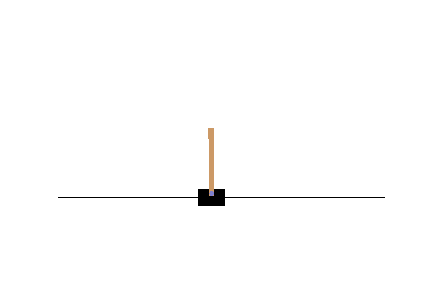
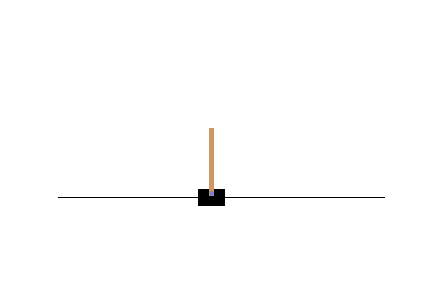
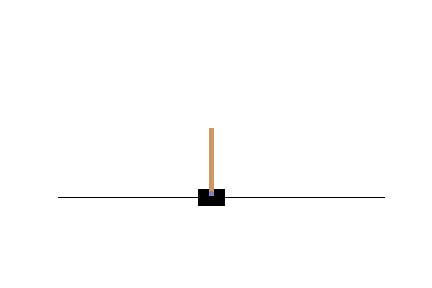
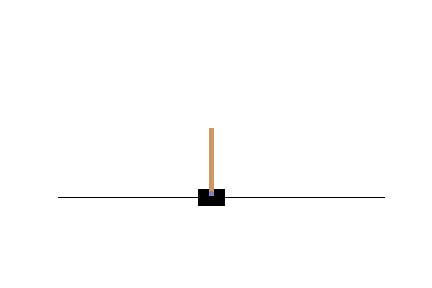
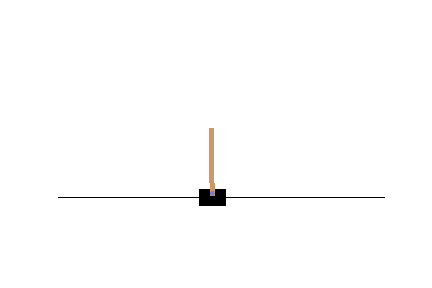
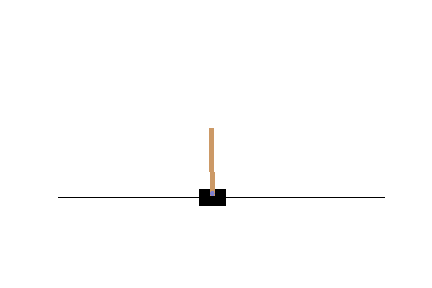
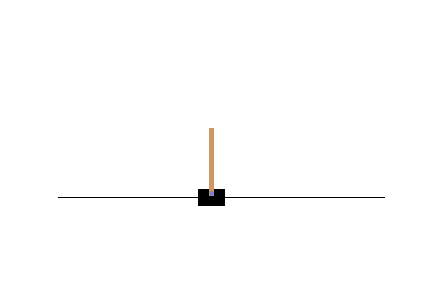
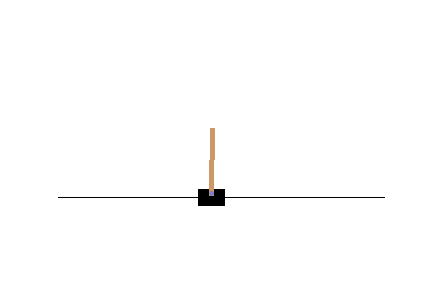
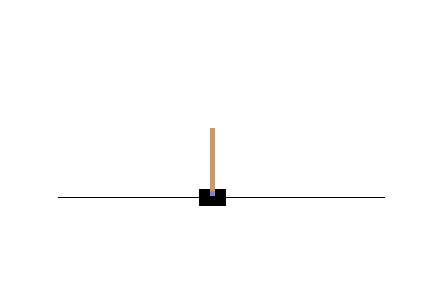
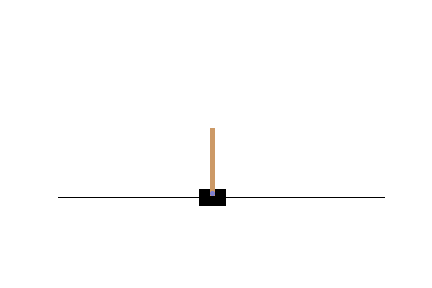
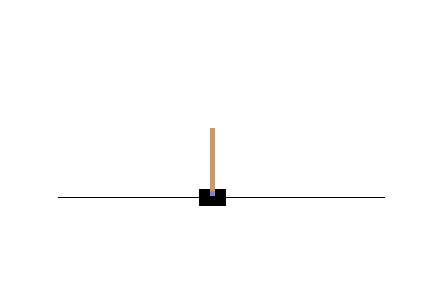
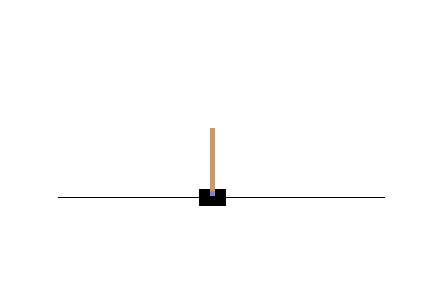
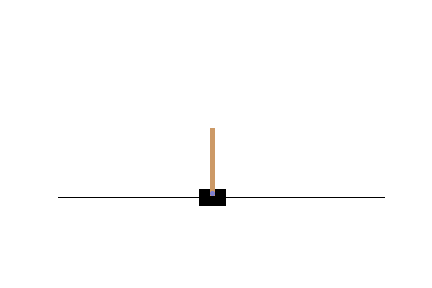
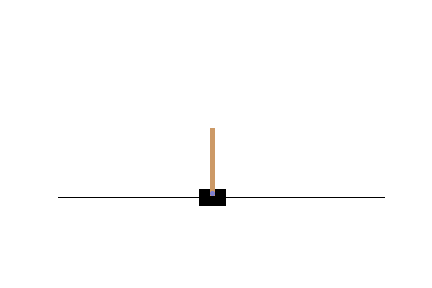
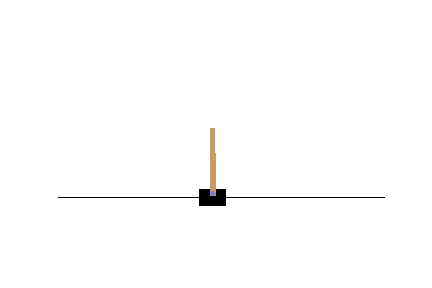
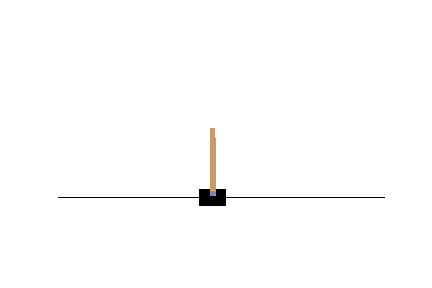
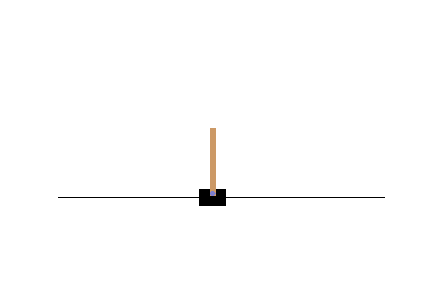
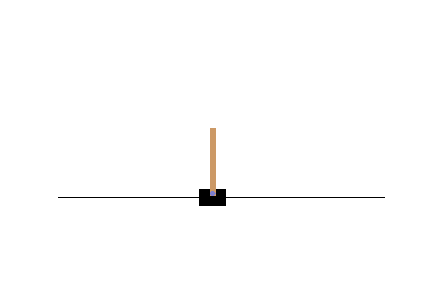
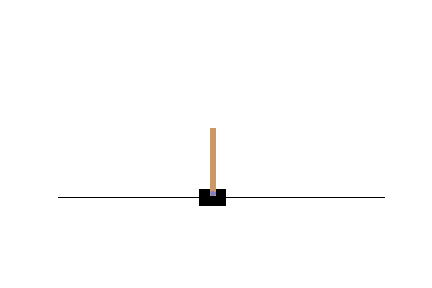
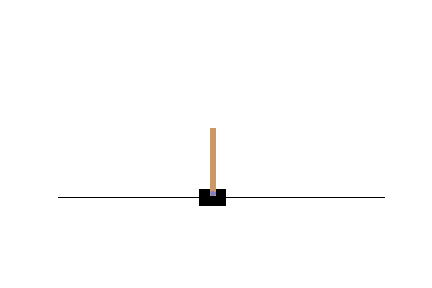
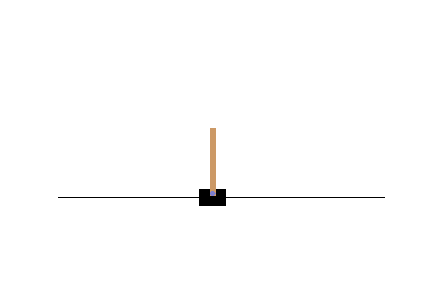
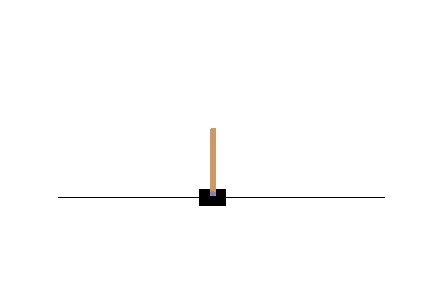
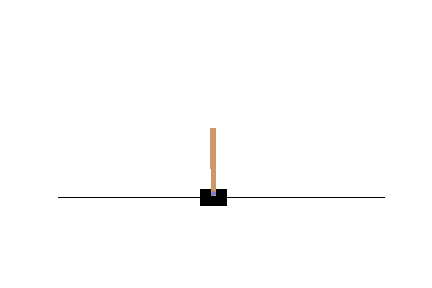
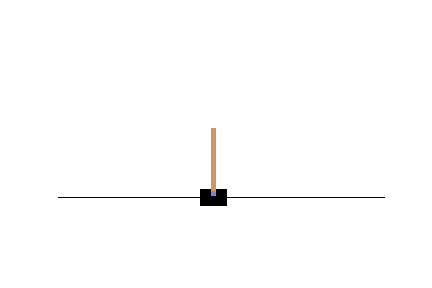
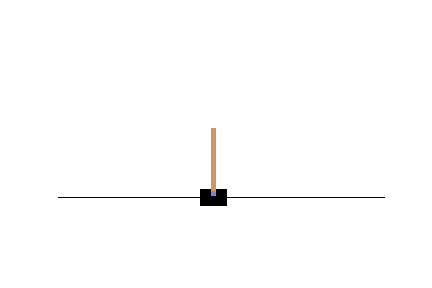
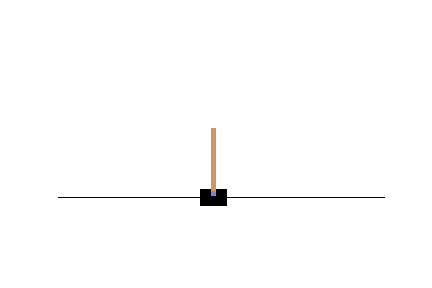
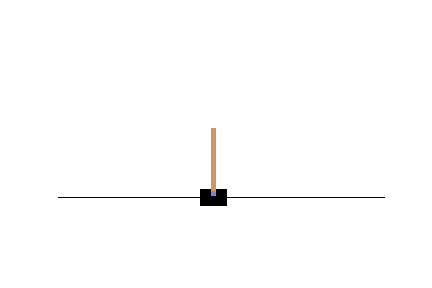
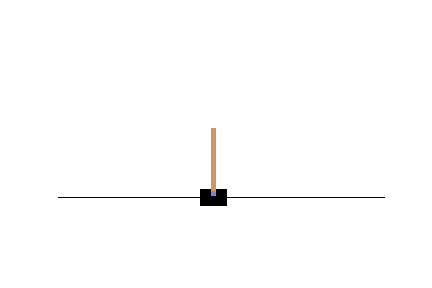
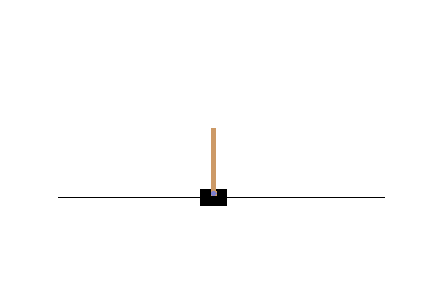
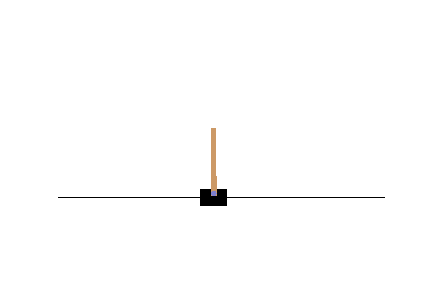
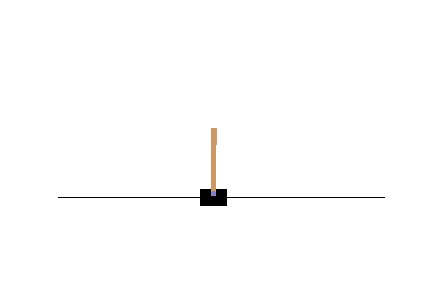
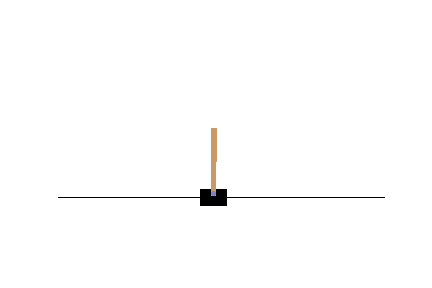
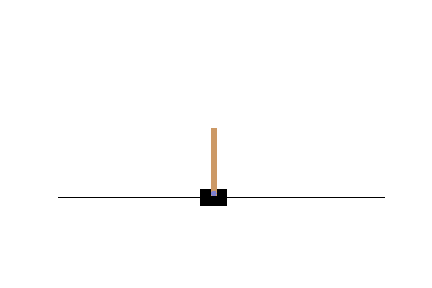
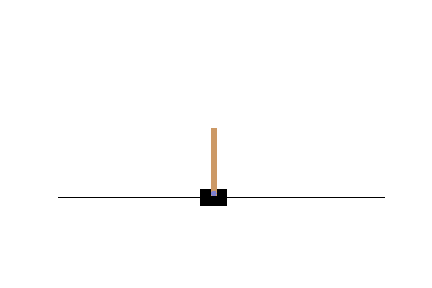
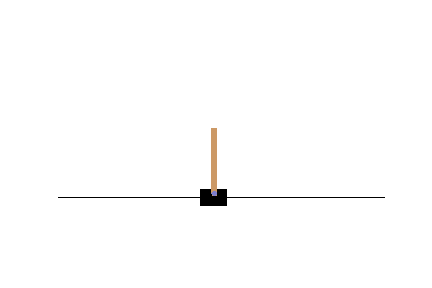
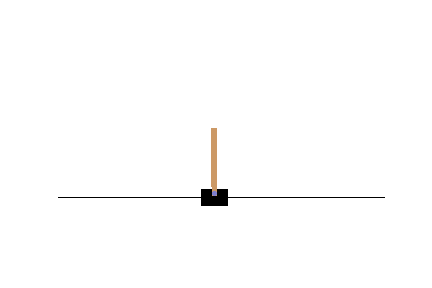
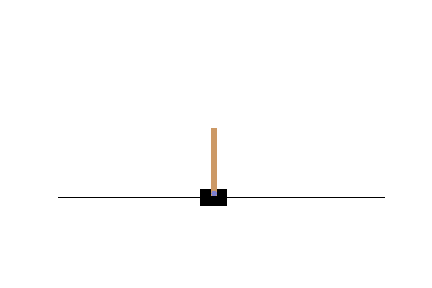
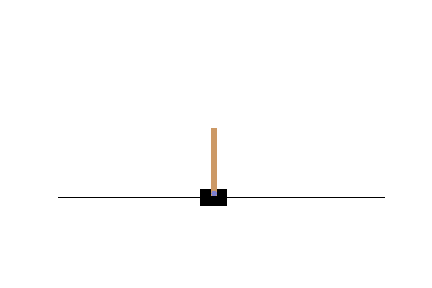
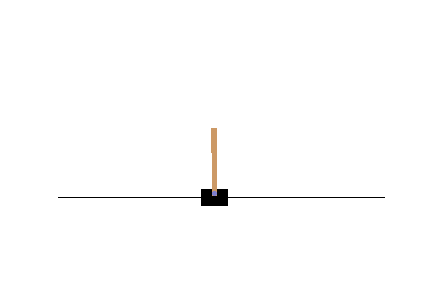
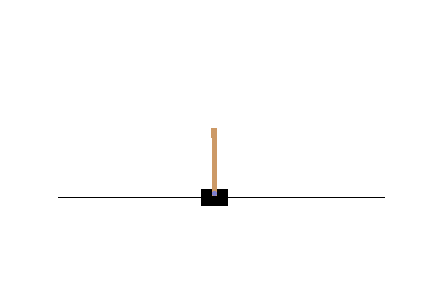
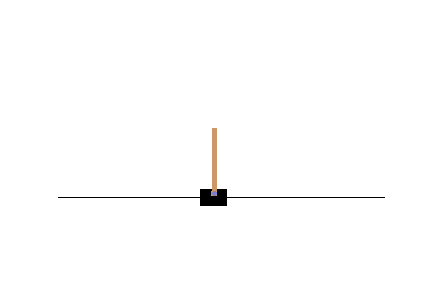
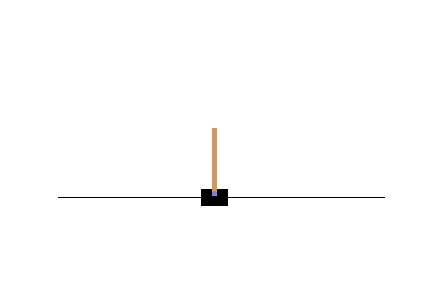
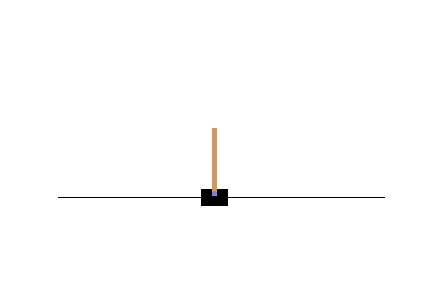
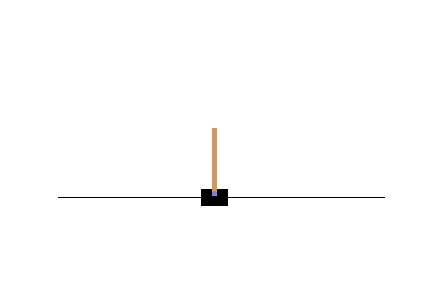
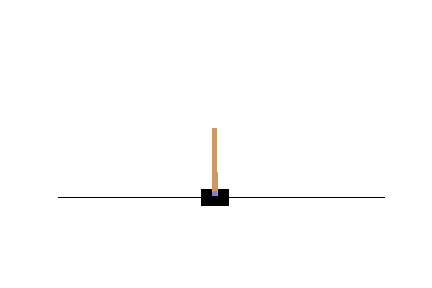
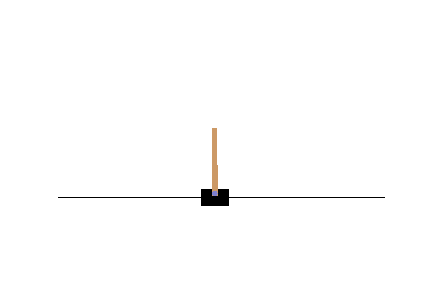
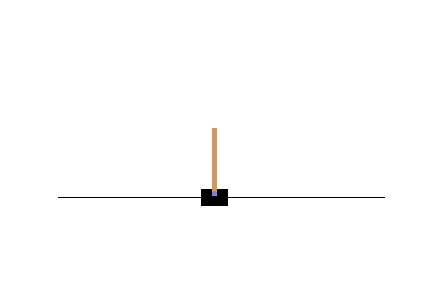
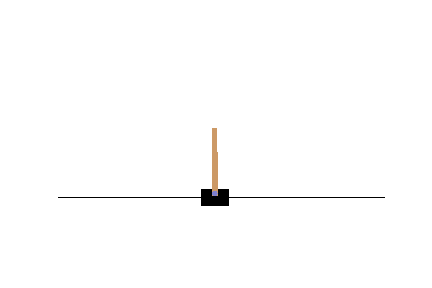
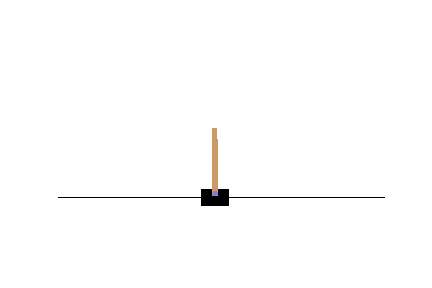
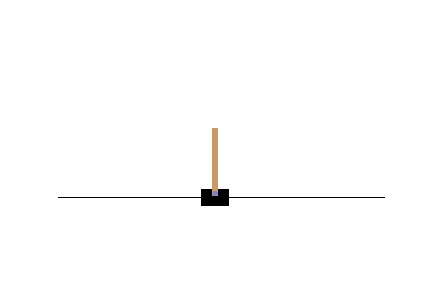
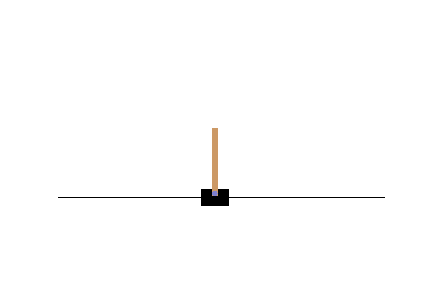
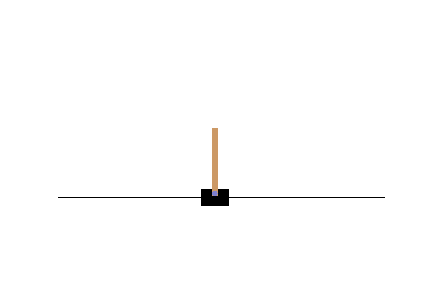
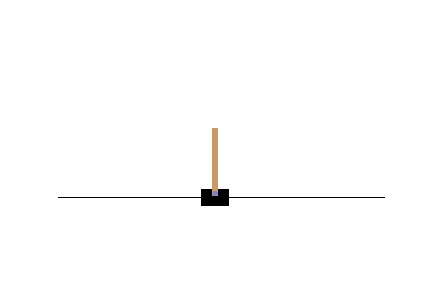
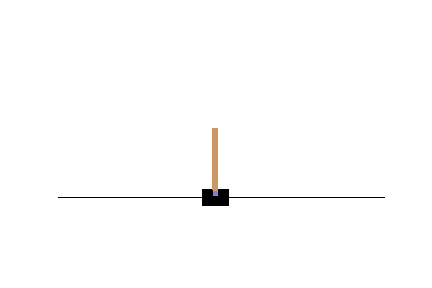
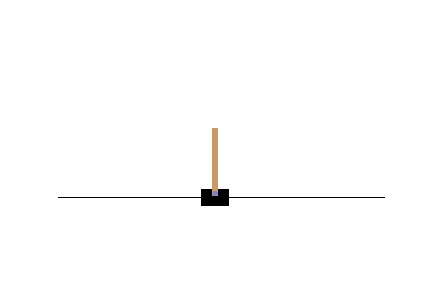
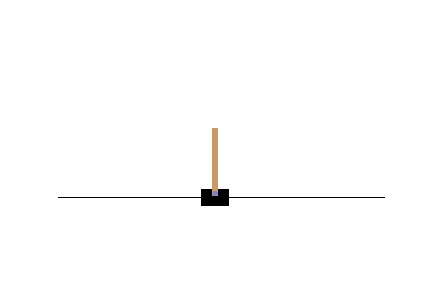
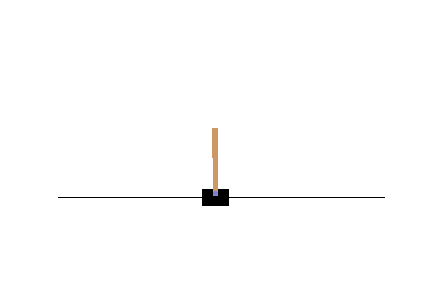
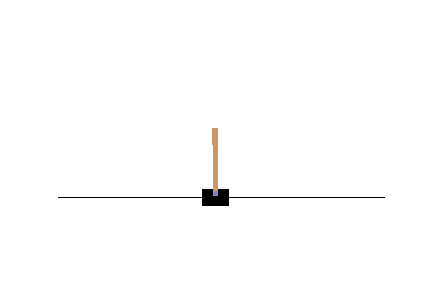
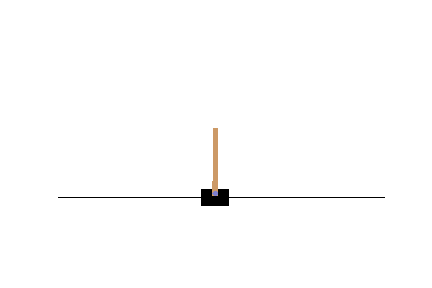
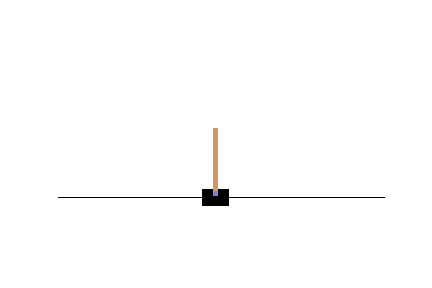
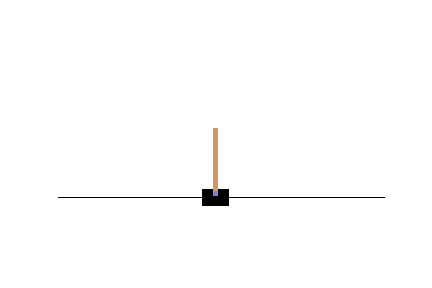
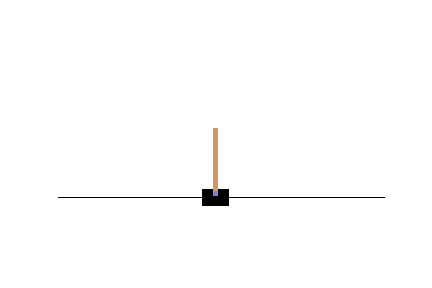
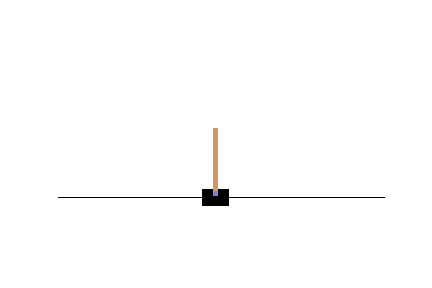
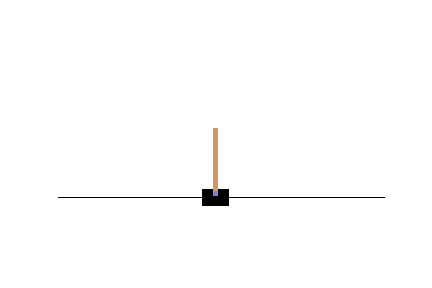
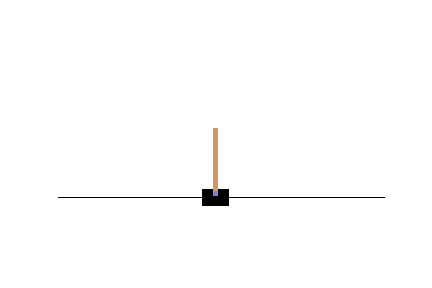
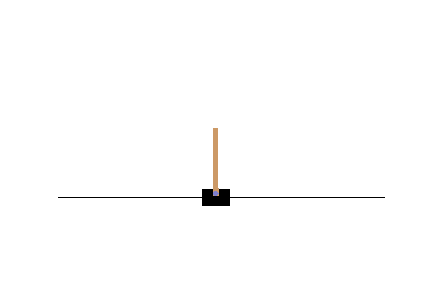
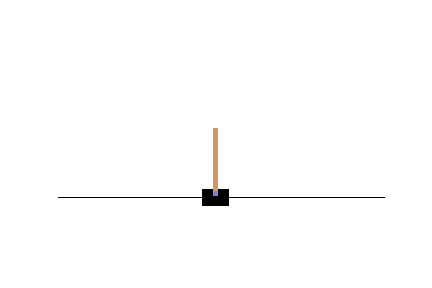
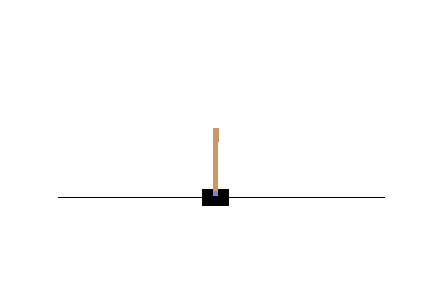
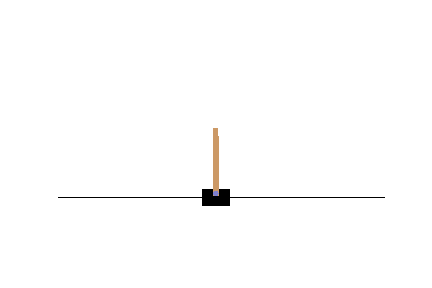
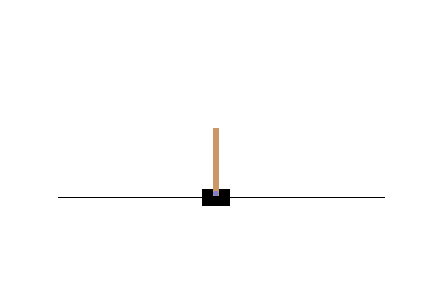
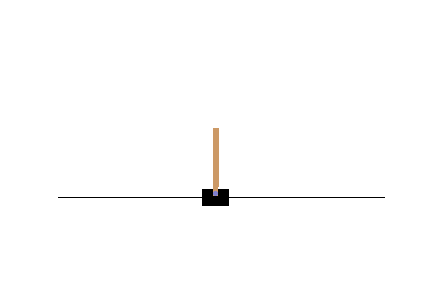
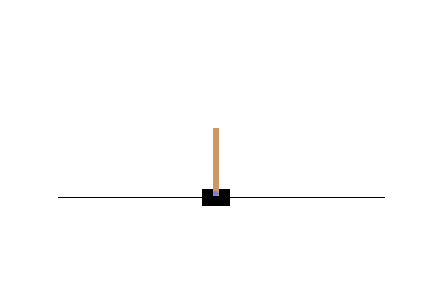
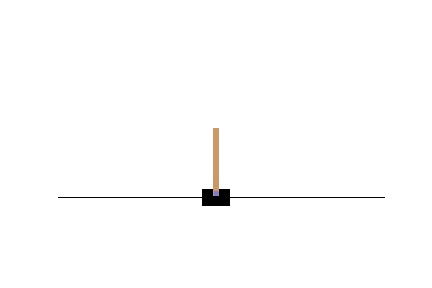
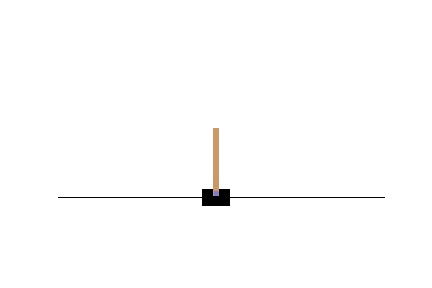
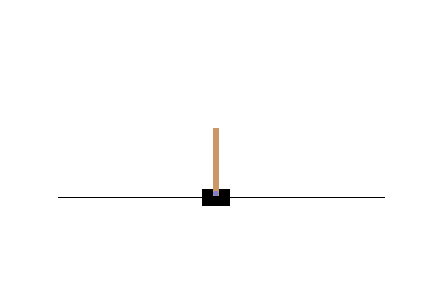
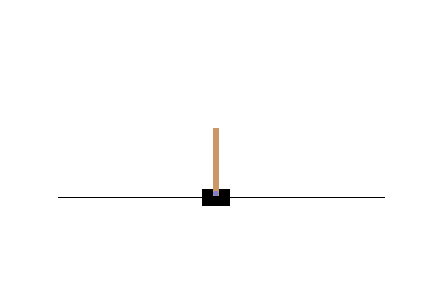
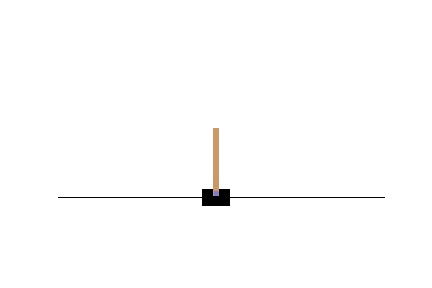
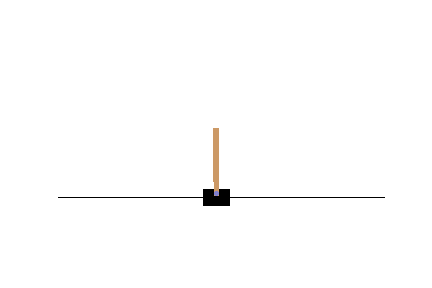
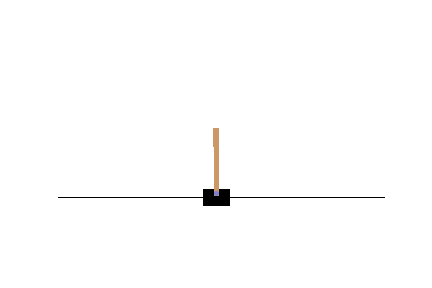
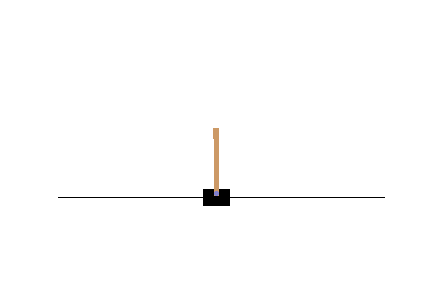
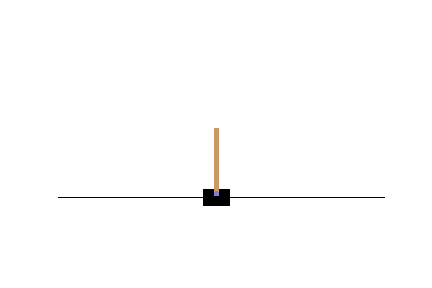
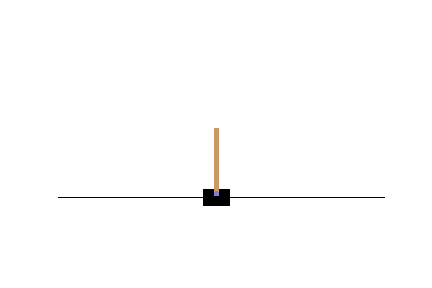
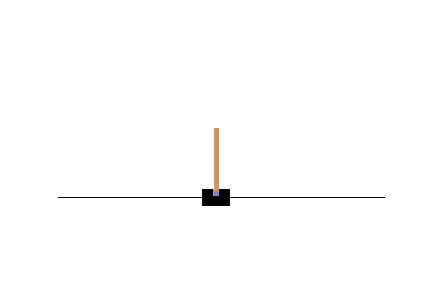
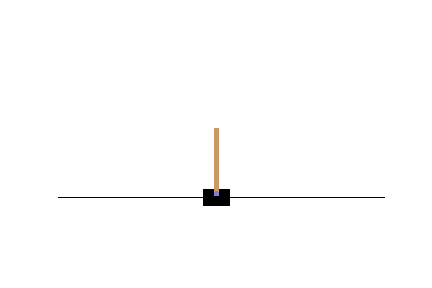
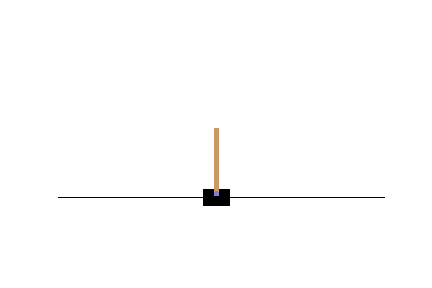
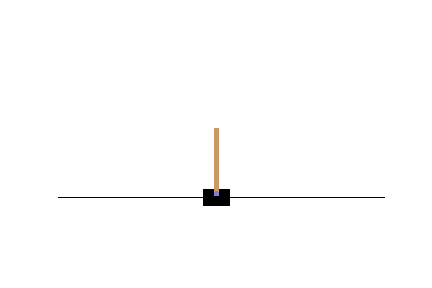
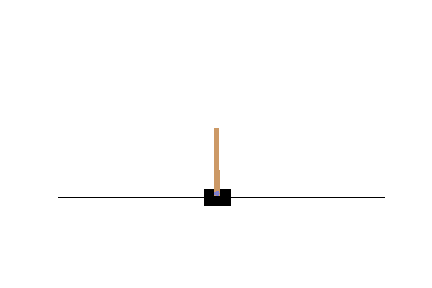
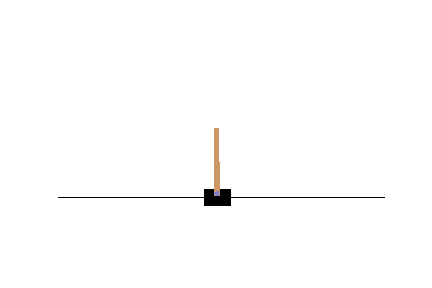
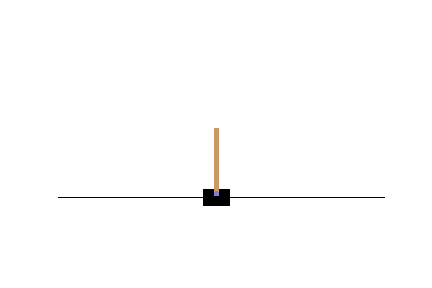
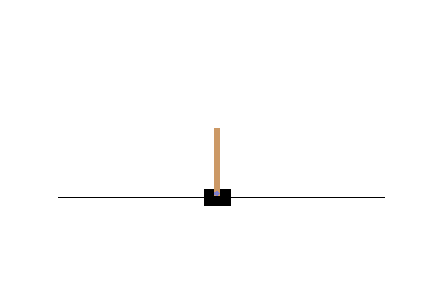
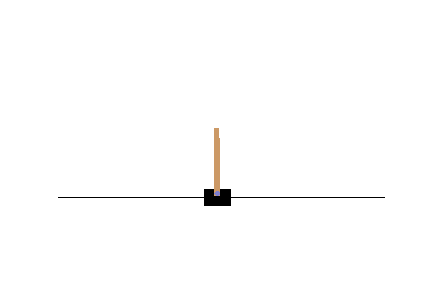
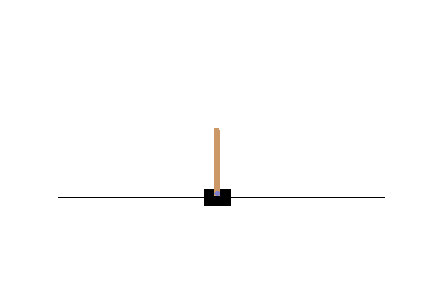
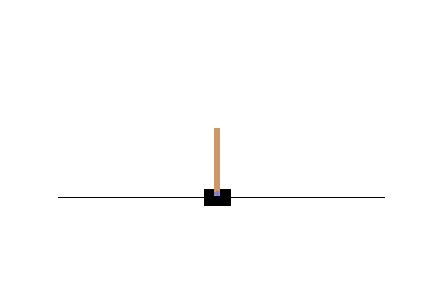
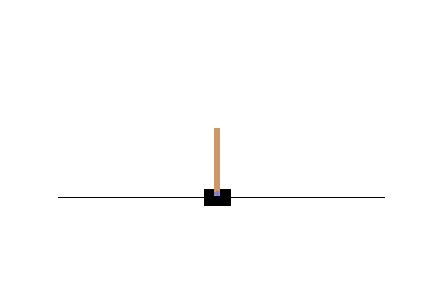
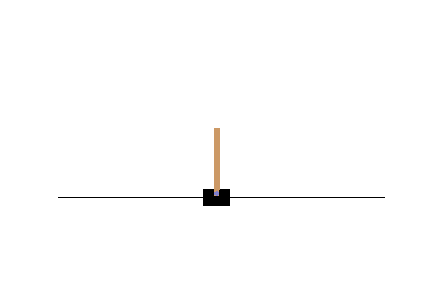
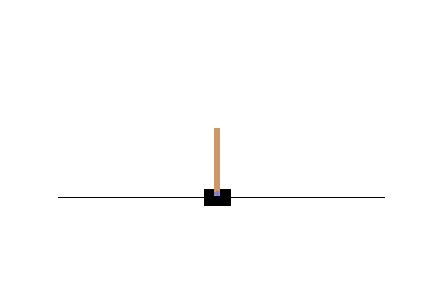
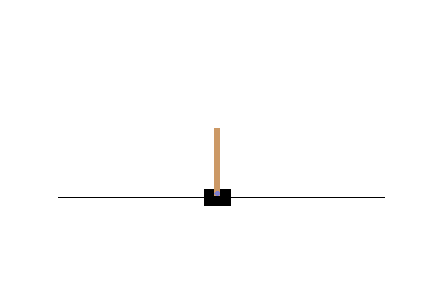
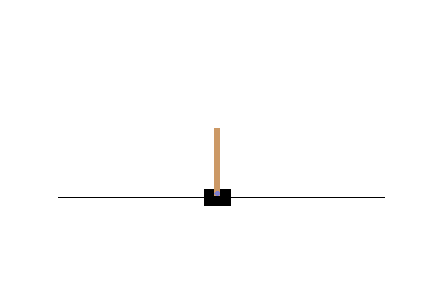
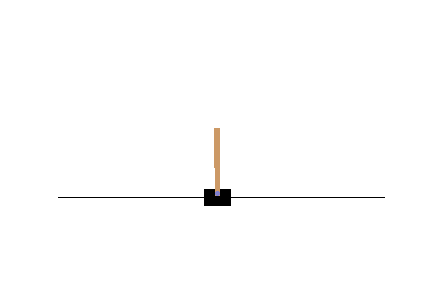
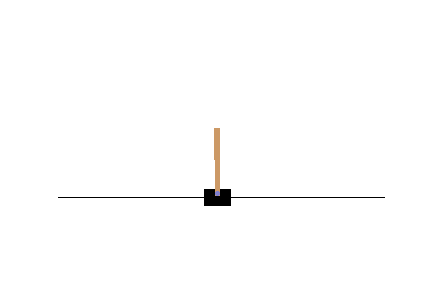
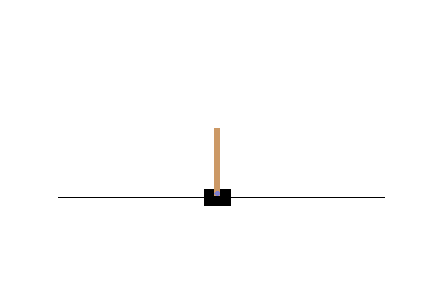
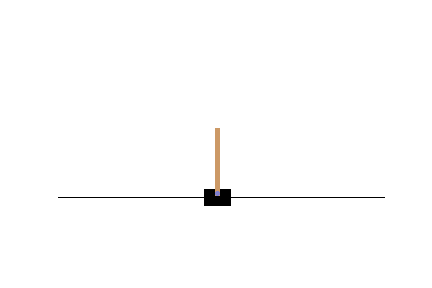
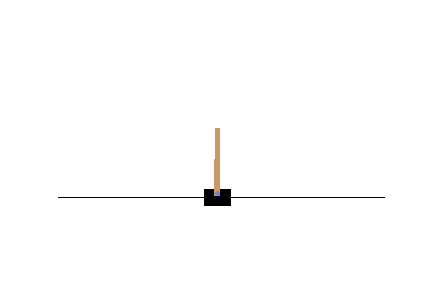
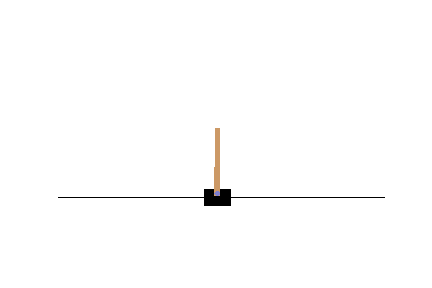
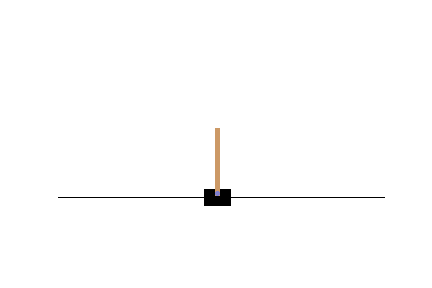
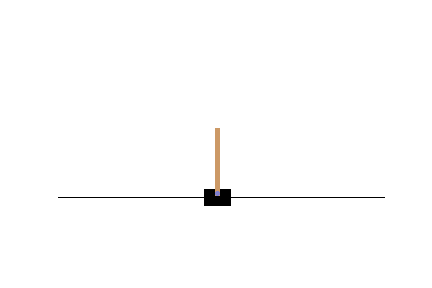
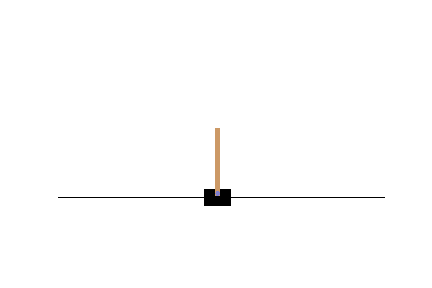
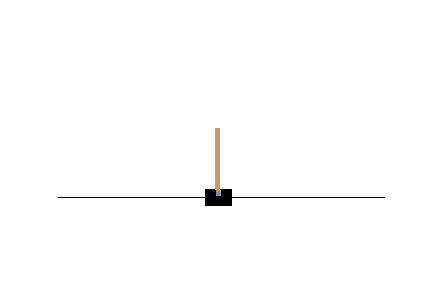
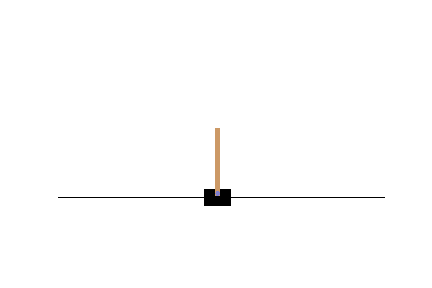
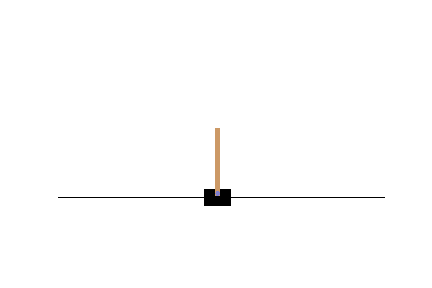
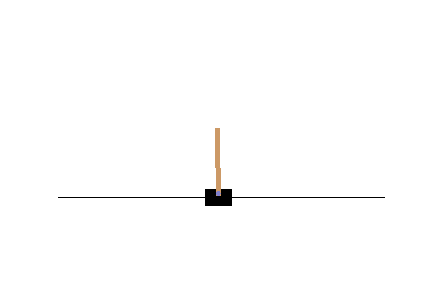
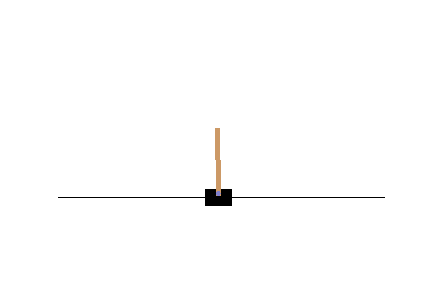
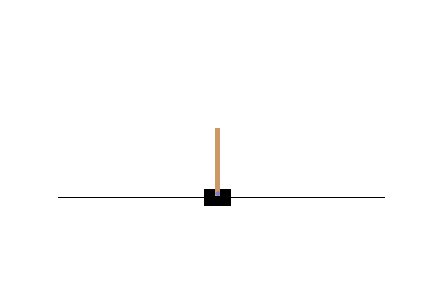
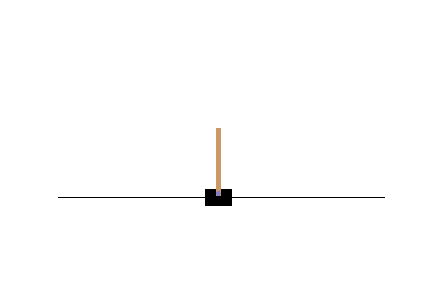
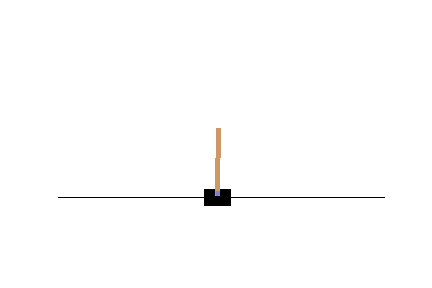
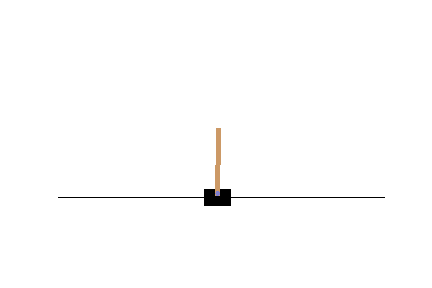
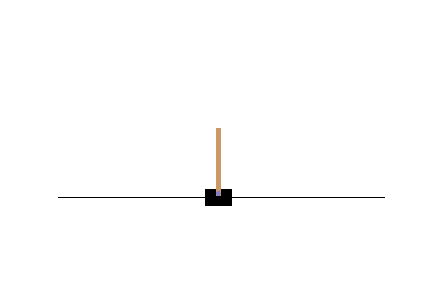
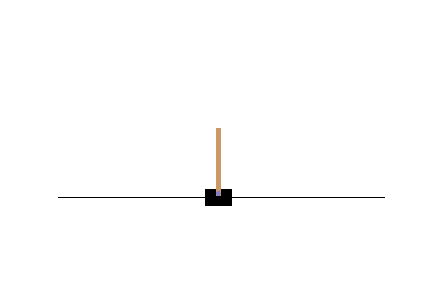
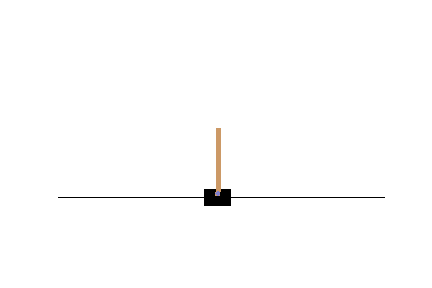
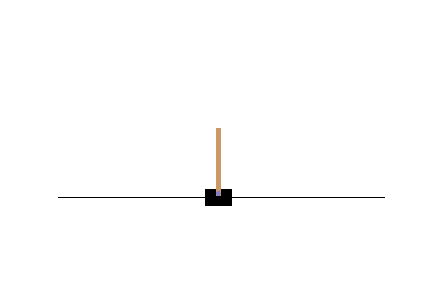
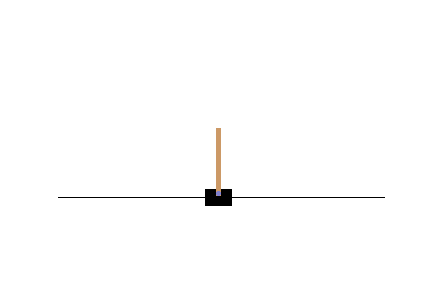
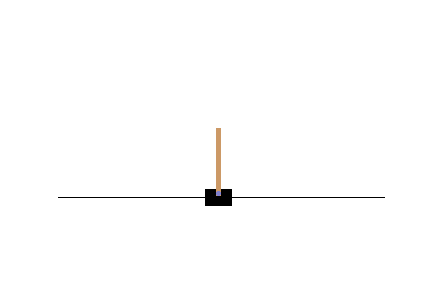
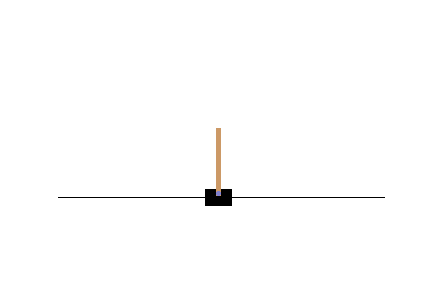
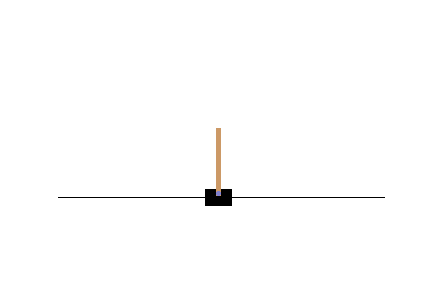
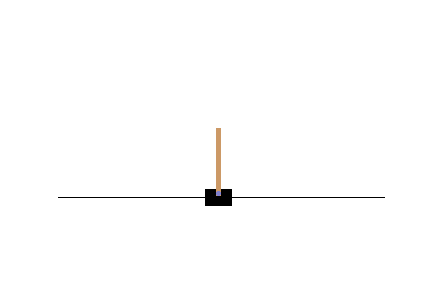
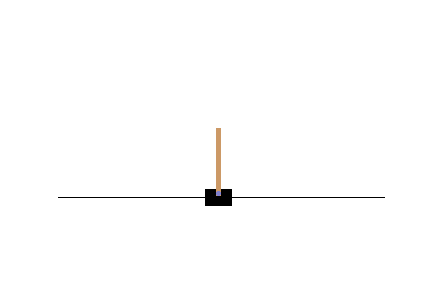
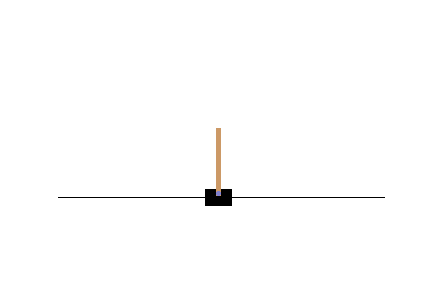
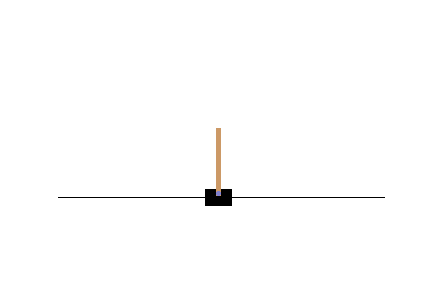
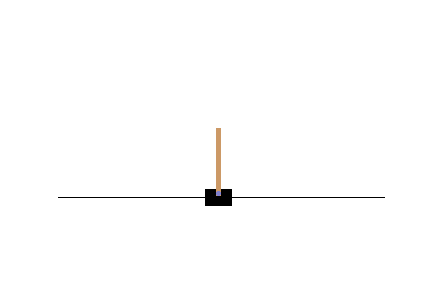
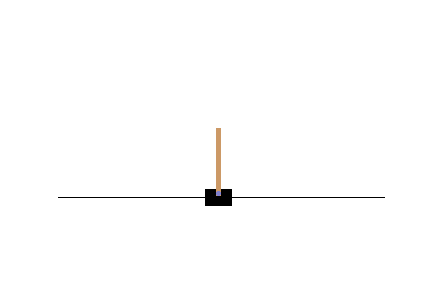
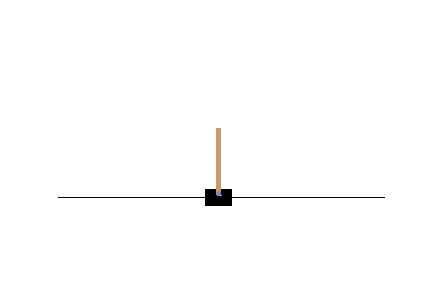
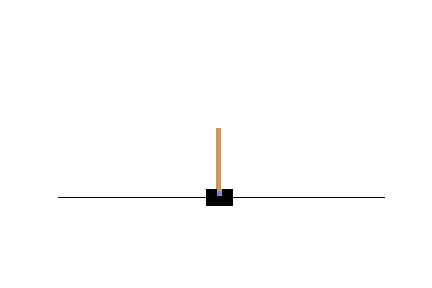
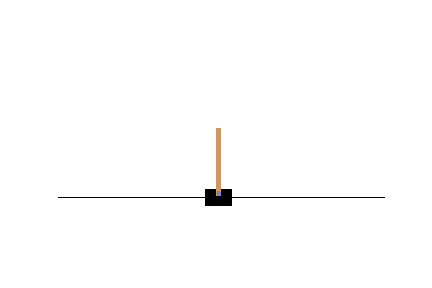
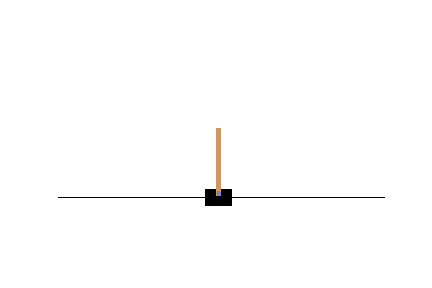
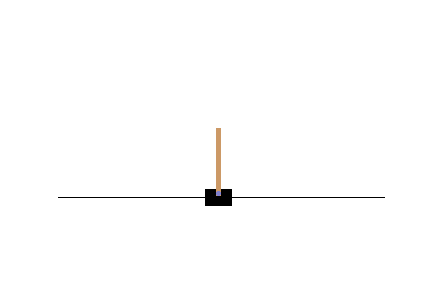
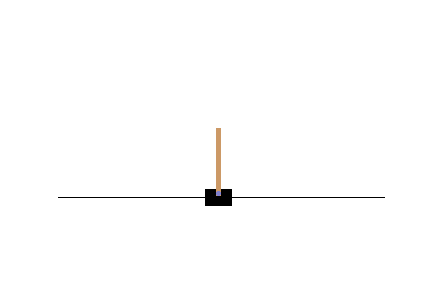
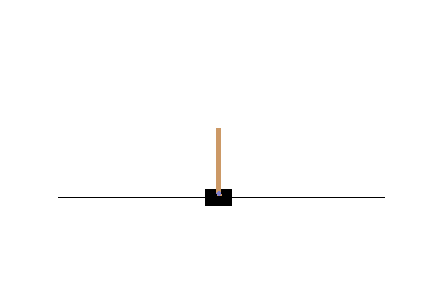
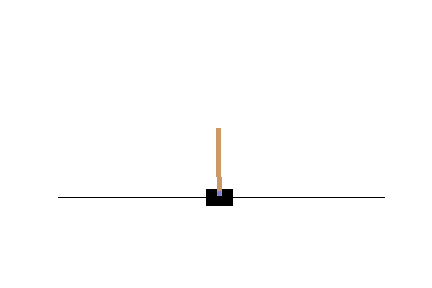
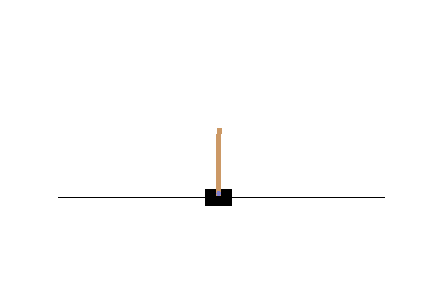
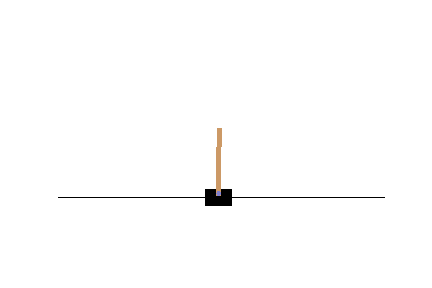
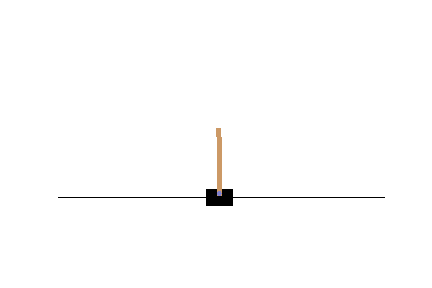
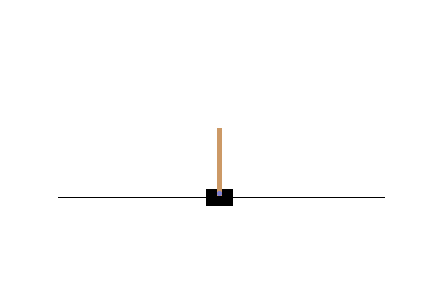
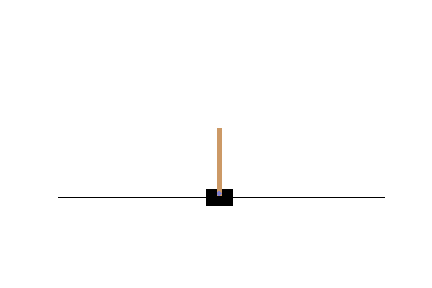
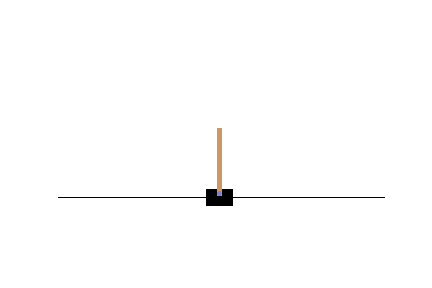
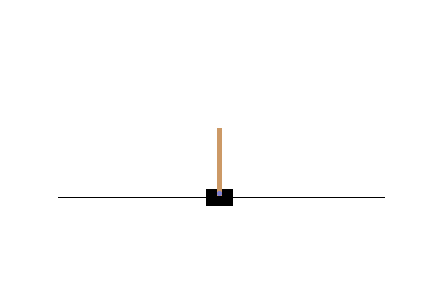
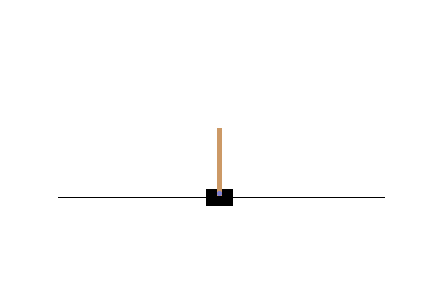
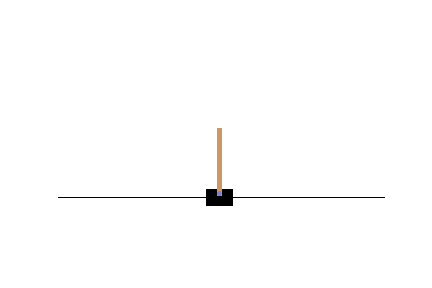
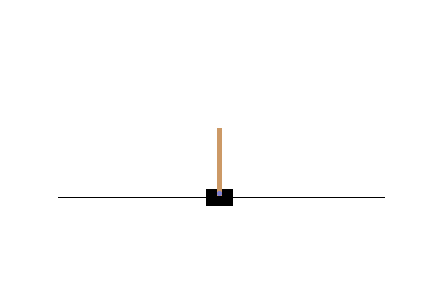
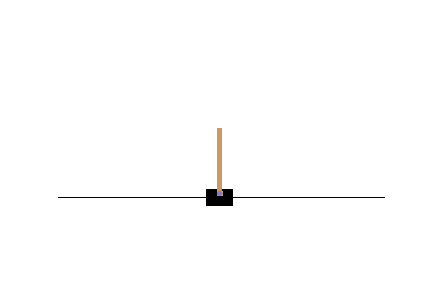
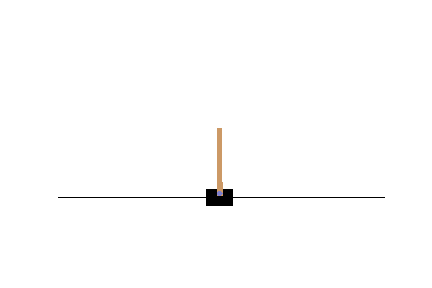
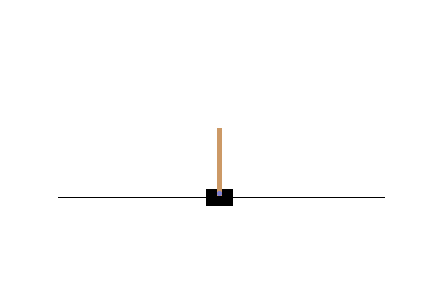
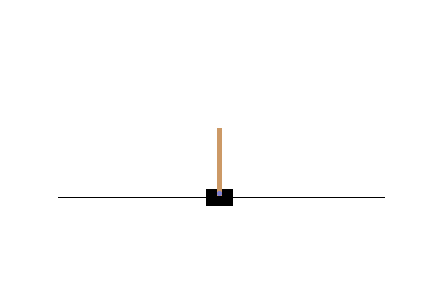
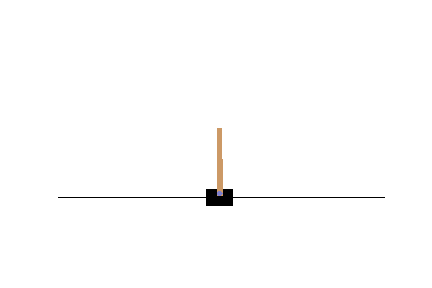
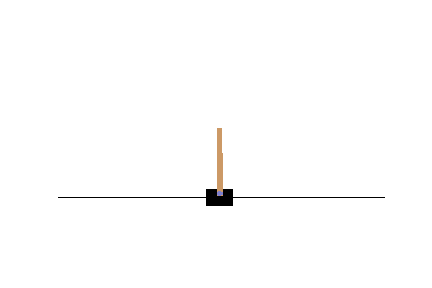
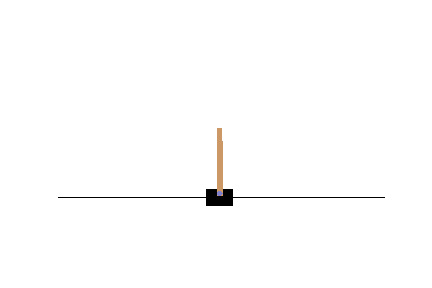
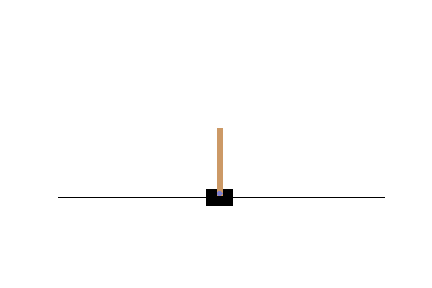
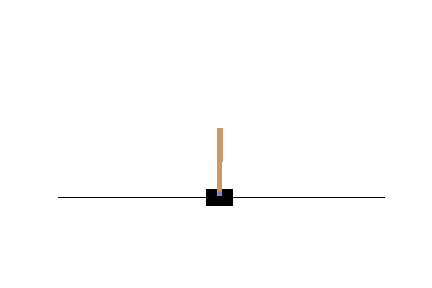
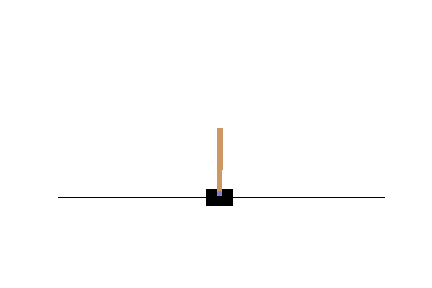
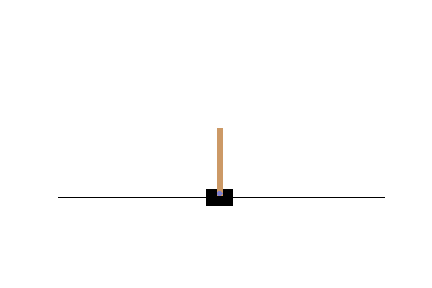
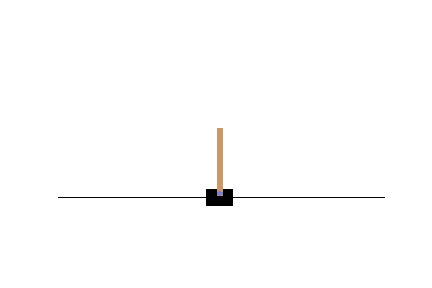
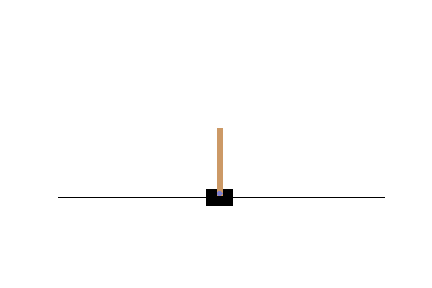
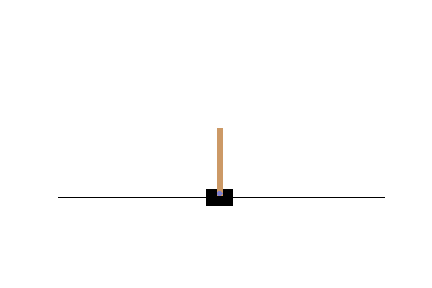
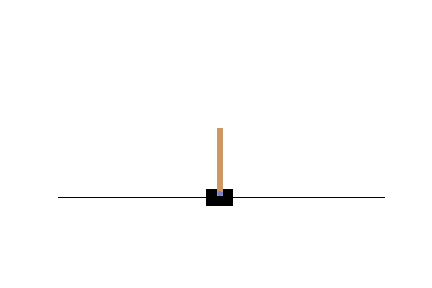
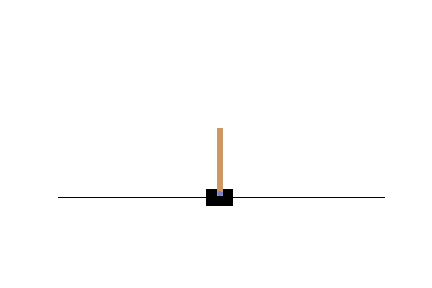
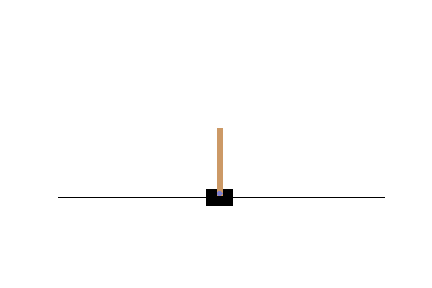
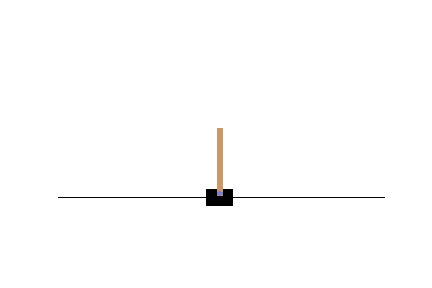
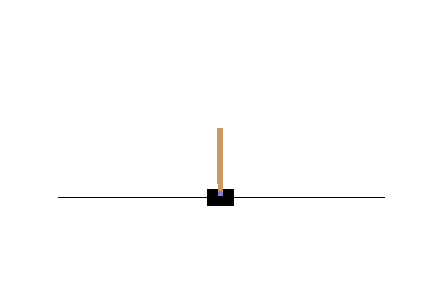
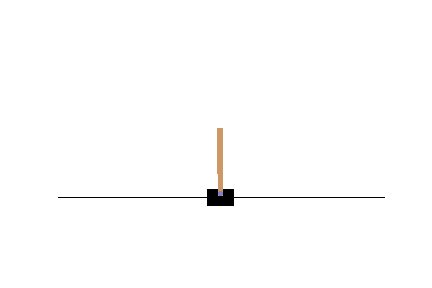
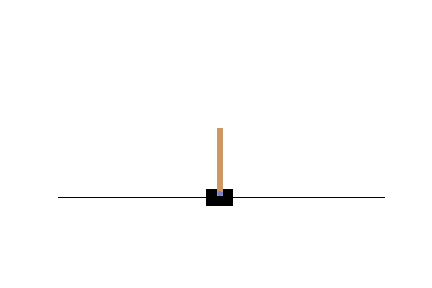
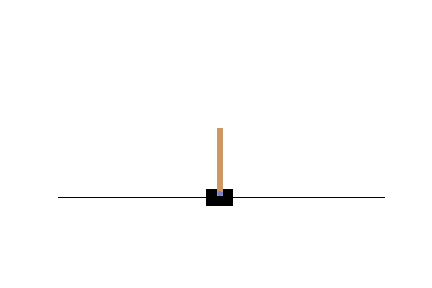
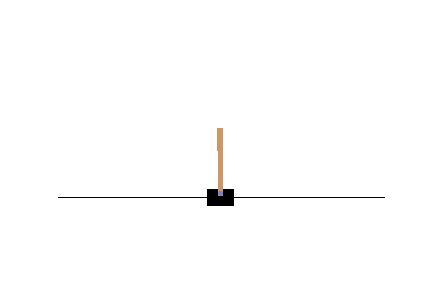
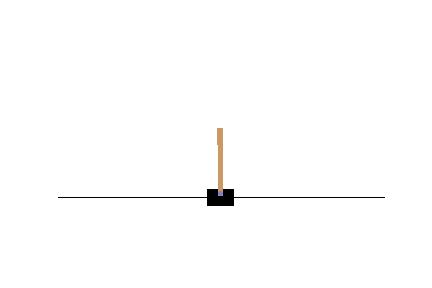
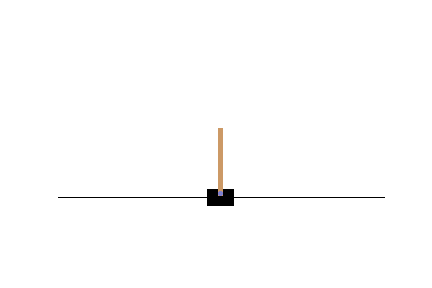
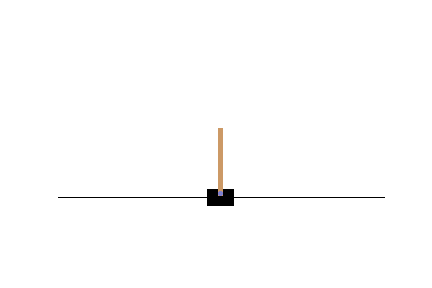
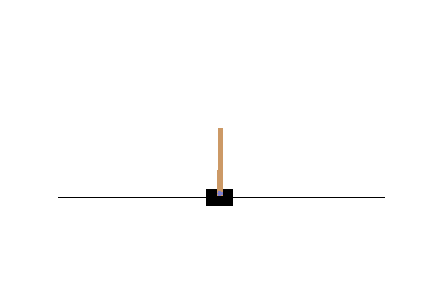
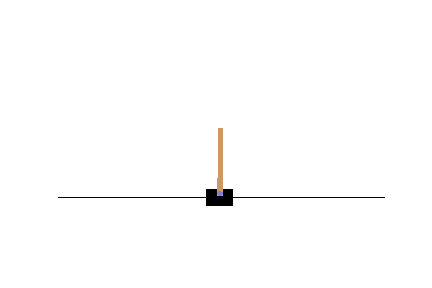
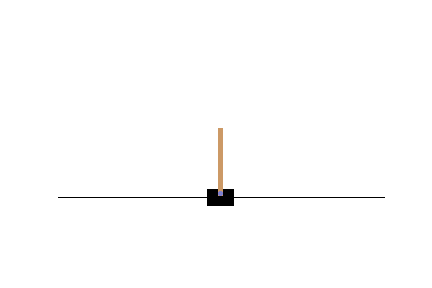
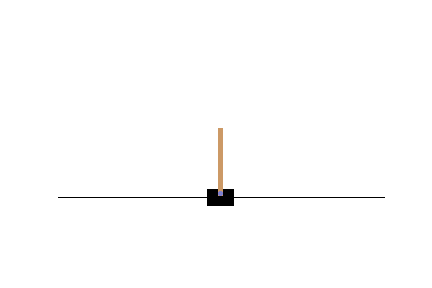
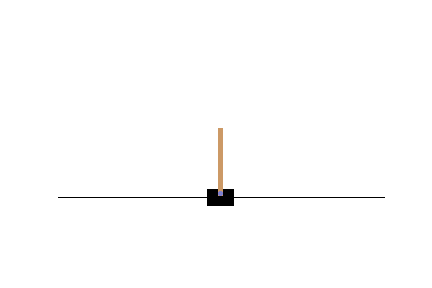
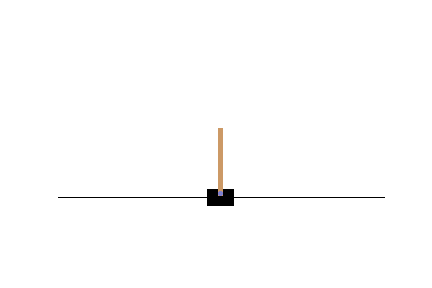
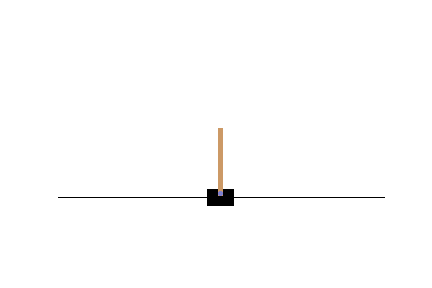
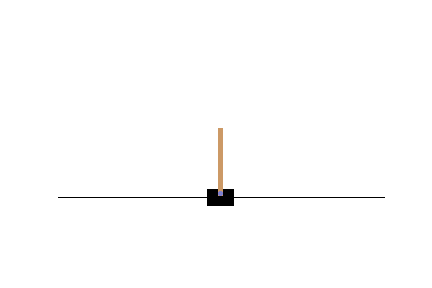
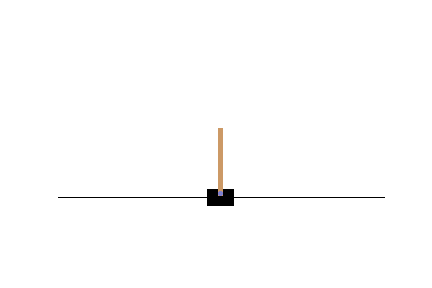
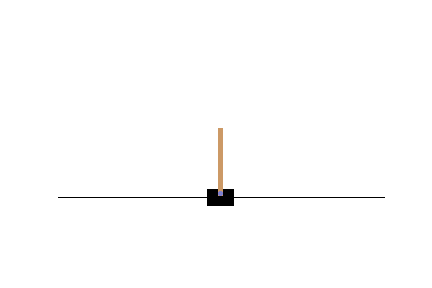
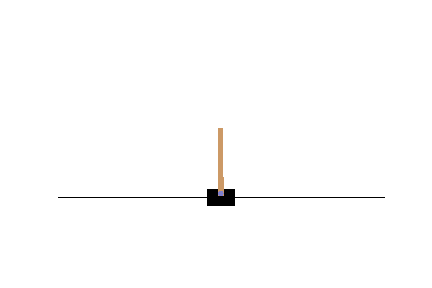
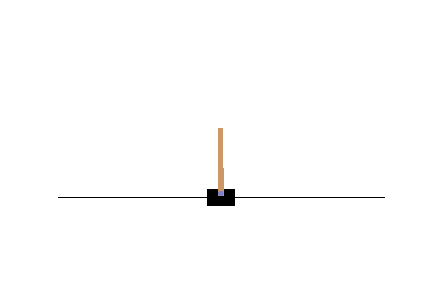
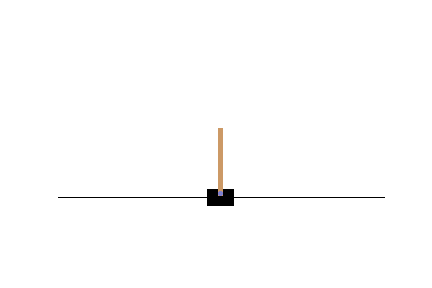
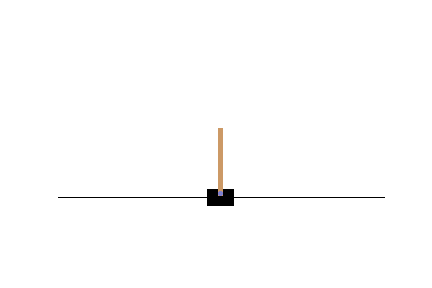
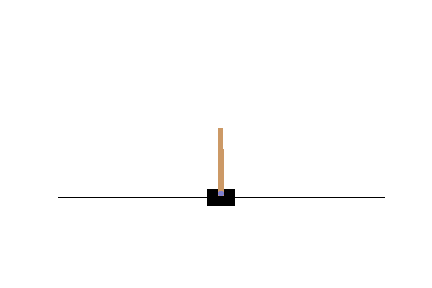
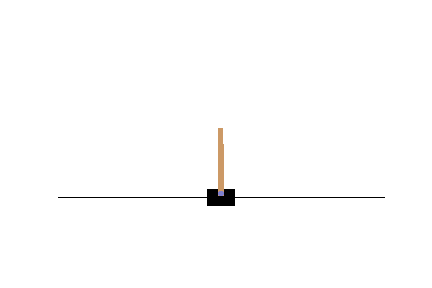
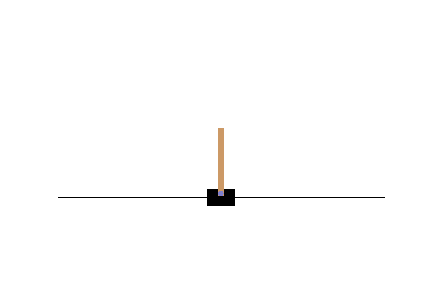
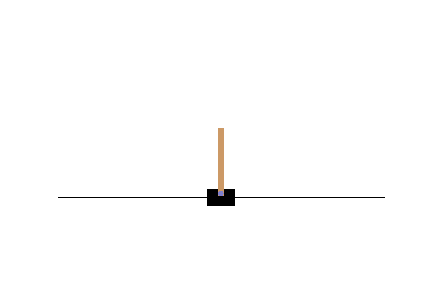
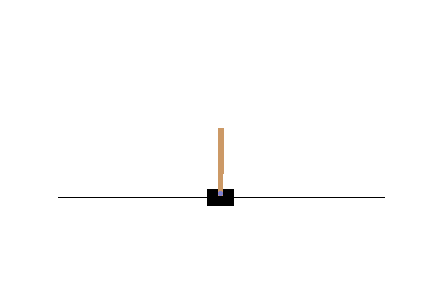
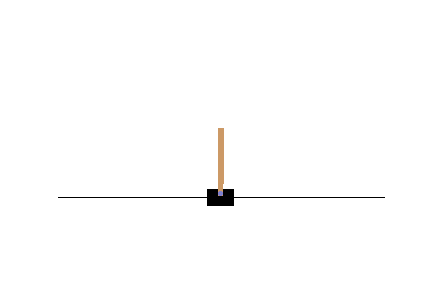
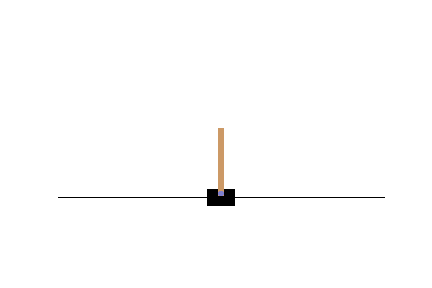
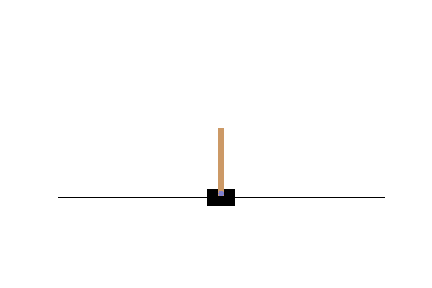
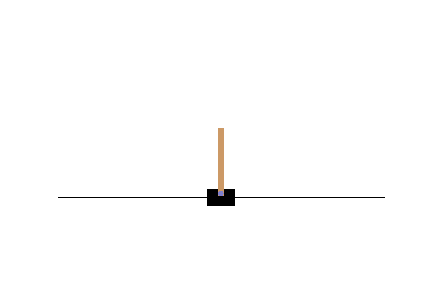
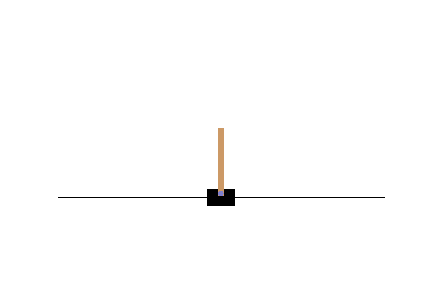
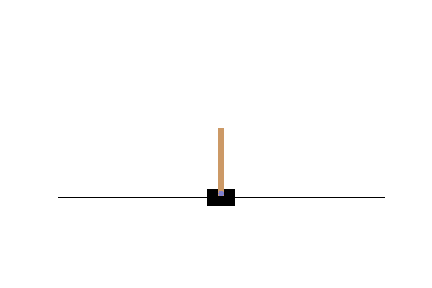
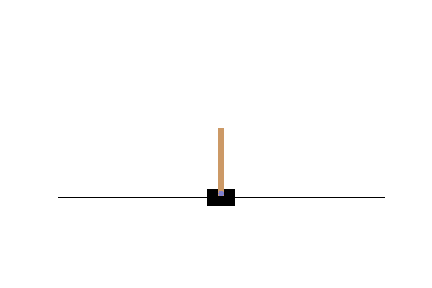
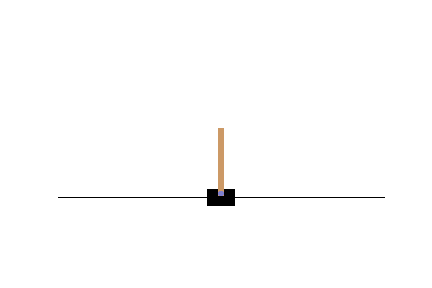
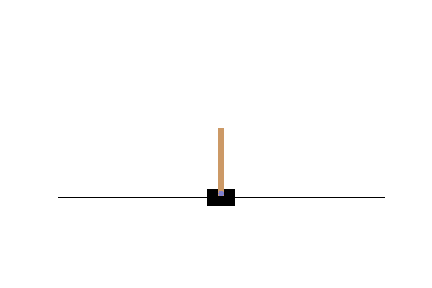
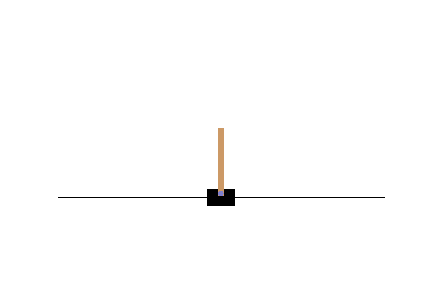
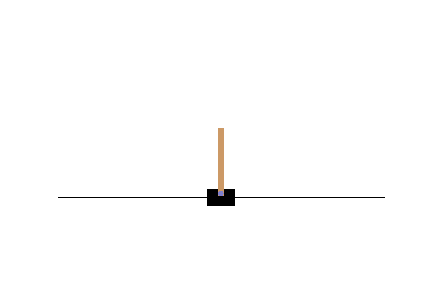
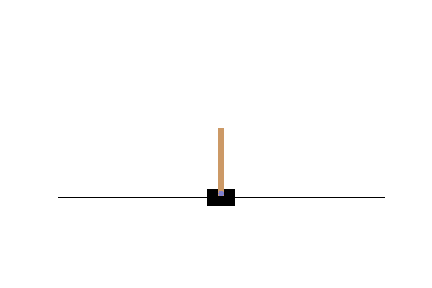
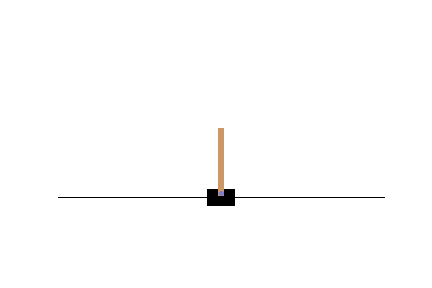
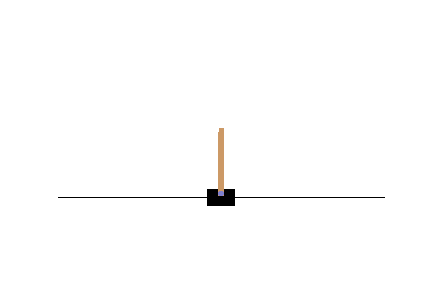
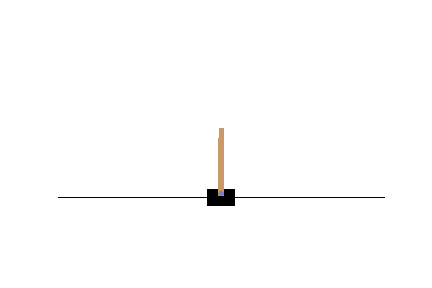
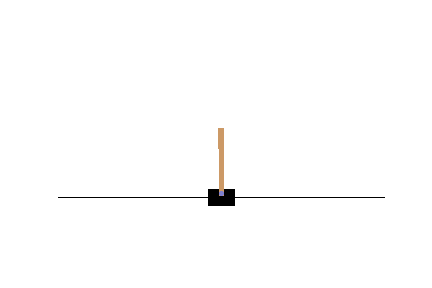
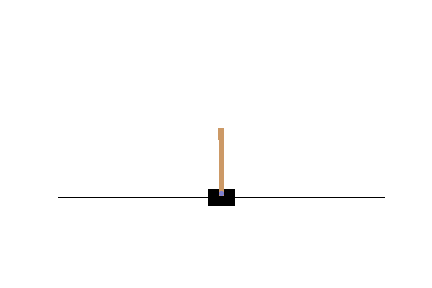
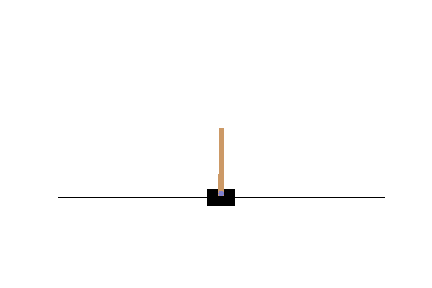
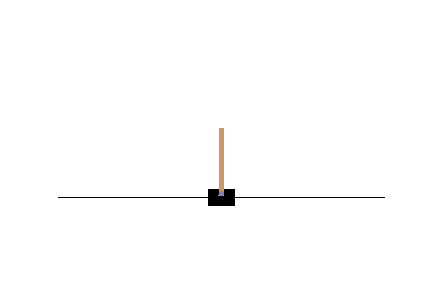
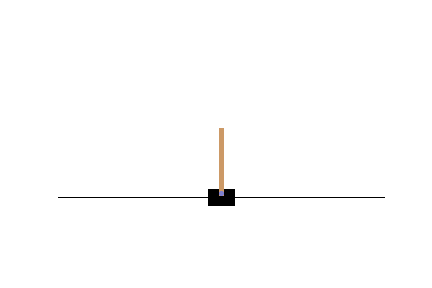
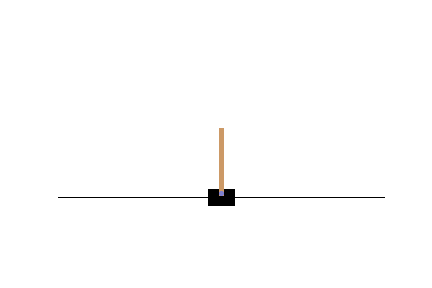
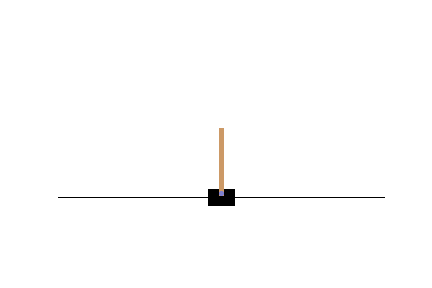
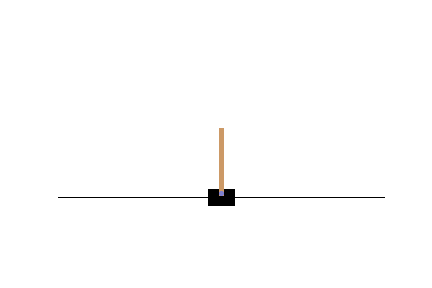
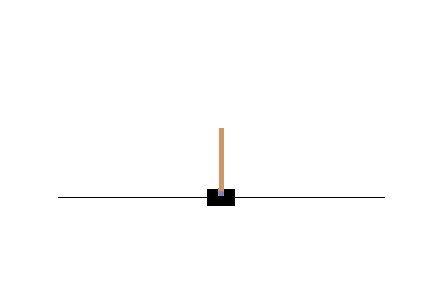
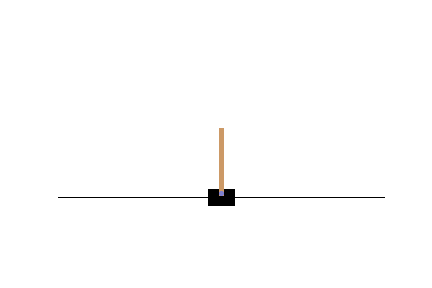
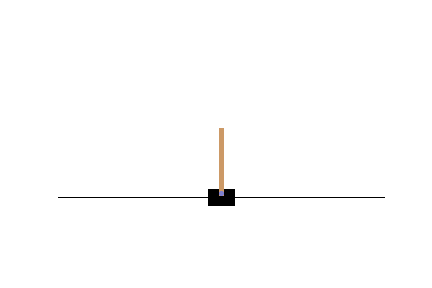
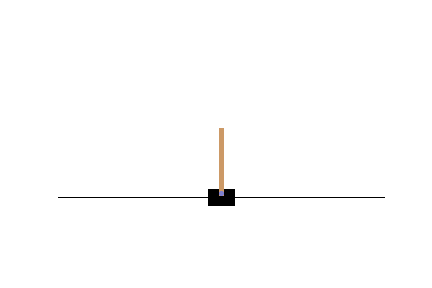
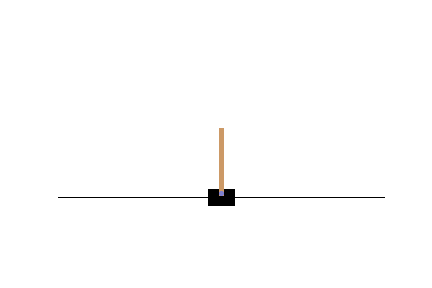
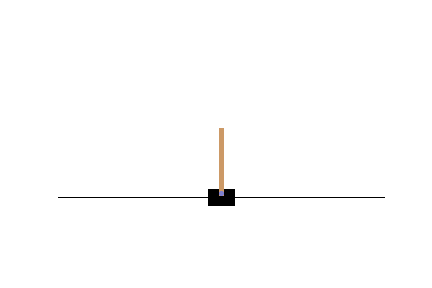
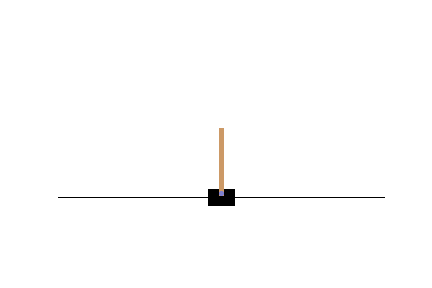
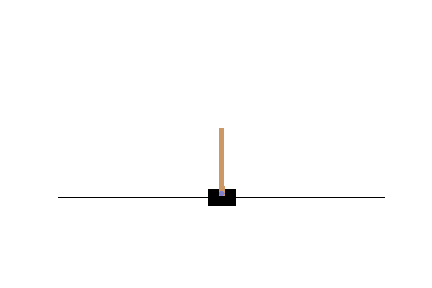
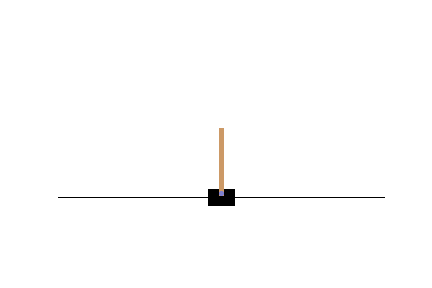
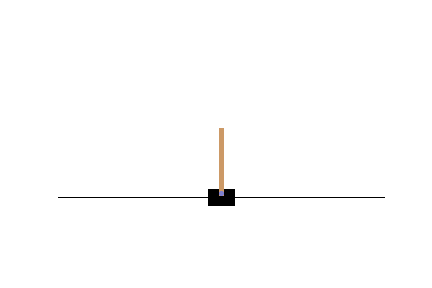
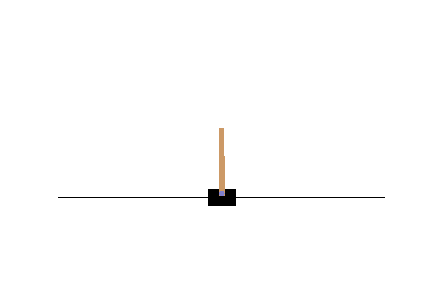
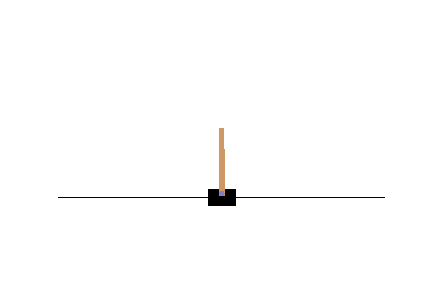
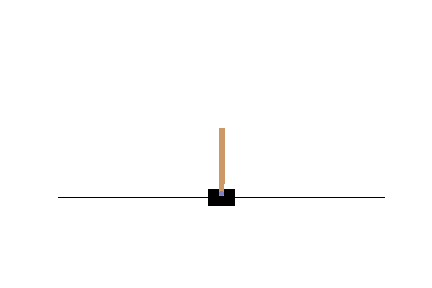
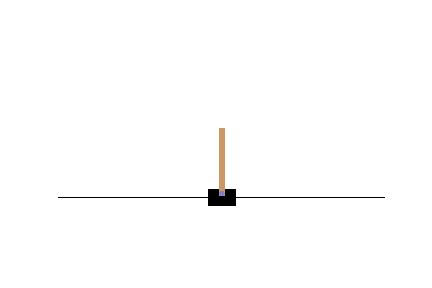

In [6]:
env = gym.make(envname)
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = bc_agent.control([obs])
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# Behavior Cloning Agent with Gaussian Distribution

In [7]:
class BCAgent_gaussian(object):
    def __init__(self, obs_dim, act_dim, clip_range=0.2,
                 epochs=10, lr=3e-5, hdim=64, max_std=1.0,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.clip_range = clip_range
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        
        # MEAN FUNCTION
        self.mean = tf.layers.dense(out, self.act_dim,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                name="mean")
        # UNI-VARIATE
        self.logits_std = tf.get_variable("logits_std",shape=(1,),initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed))
        self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std) # IMPORTANT TRICK
        
        # SAMPLE OPERATION
        self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed=self.seed)*self.std
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = tf.reduce_sum(-0.5*tf.square((y-mu)/sigma)-tf.log(sigma)- 0.5*np.log(2.*np.pi),axis=1)

    def _loss_train_op(self):
        
        self.loss = -tf.reduce_mean(self.logp)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        sampled_action = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action
    
    def control(self, obs): # COMPUTE MEAN
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action        
    
    def update(self, observes, actions, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        for e in range(self.epochs):
            observes, actions = shuffle(observes, actions, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
                 self.act_ph: actions,
                 self.lr_ph: self.lr}             
        loss = self.sess.run(self.loss, feed_dict)
        return loss
    
    def close_sess(self):
        self.sess.close()

# Load Training Data

In [8]:
envname="MountainCarContinuous-v0"

# Load demonstrations
demo_file = open('./'+envname+'_expert_demo.pkl', 'rb')
n_demos = 10
demonstrations, = pickle.load(demo_file)[:n_demos]
demonstrations = shuffle(demonstrations,random_state=seed)

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
print('{} demonstrations are loaded'.format(n_demos))
print('Expert\'s Average Cumulative Rewards {:.3f}'.format(exp_ret))

demo_observes = []
demo_actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        demo_observes.append(obs)
    for act in demonstration['actions']:
        demo_actions.append(act)
demo_observes=np.asarray(demo_observes)
demo_actions=np.asarray(demo_actions)
print('{} (s,a) pairs are loaded'.format(demo_observes.shape[0]))

10 demonstrations are loaded
Expert's Average Cumulative Rewards 92.459
41035 (s,a) pairs are loaded


# Behavior Cloning (Supervised Learning) in MountainCarContinuous Problem
### MountainCarContinuous problem has continuous action space. So, it is the same as regression problem

In [9]:
env = gym.make(envname)

env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

bc_agent_gauss = BCAgent_gaussian(obs_dim,act_dim,lr=5e-5)

batch_size = 32
nupdates = 10

for update in range(nupdates+1):
    loss = bc_agent_gauss.update(demo_observes,demo_actions,batch_size=batch_size)
    if (update%1) == 0:
        print('[{}/{}] negative loglikelihood : {:.6f}'.format(update, nupdates, loss))    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/10] negative loglikelihood : -0.169551
[1/10] negative loglikelihood : -0.644027
[2/10] negative loglikelihood : -1.185337
[3/10] negative loglikelihood : -1.770182
[4/10] negative loglikelihood : -2.379043
[5/10] negative loglikelihood : -3.003036
[6/10] negative loglikelihood : -3.635339
[7/10] negative loglikelihood : -4.270798
[8/10] negative loglikelihood : -4.907472
[9/10] negative loglikelihood : -5.539023
[10/10] negative loglikelihood : -6.148736


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 94.21



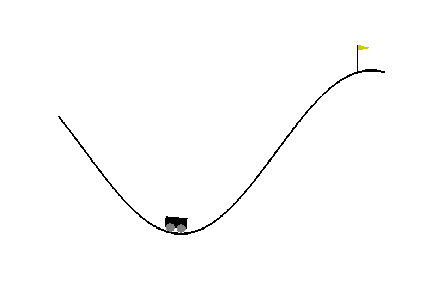
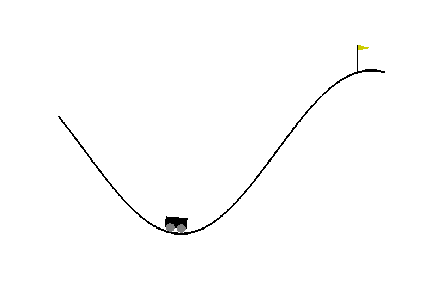
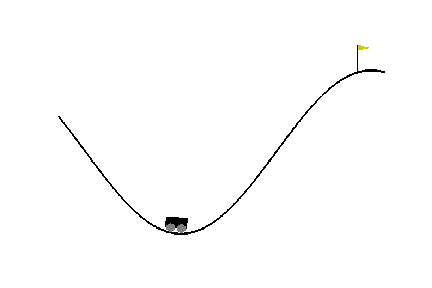
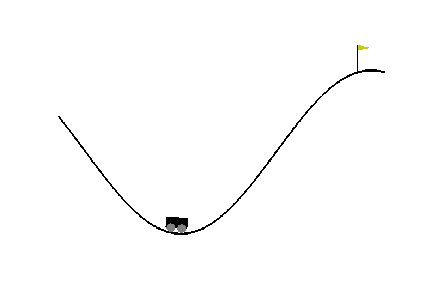
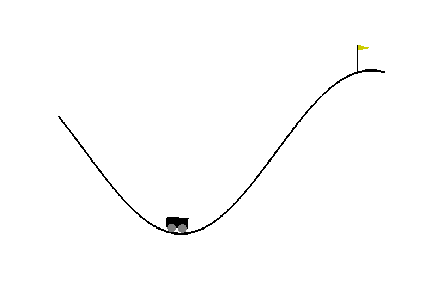
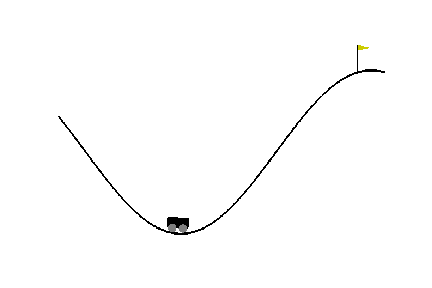
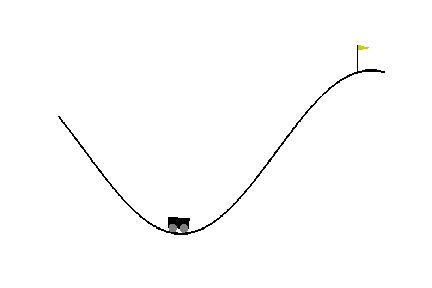
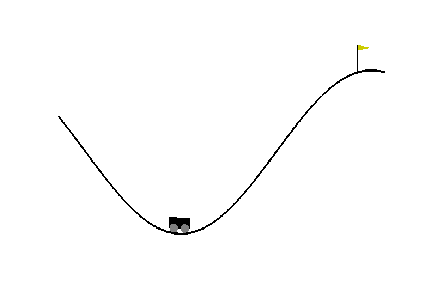
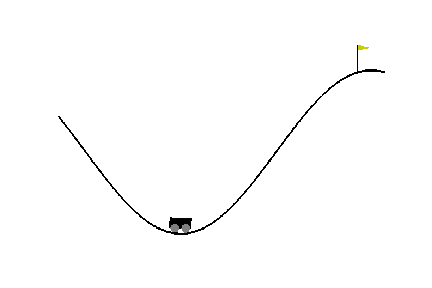
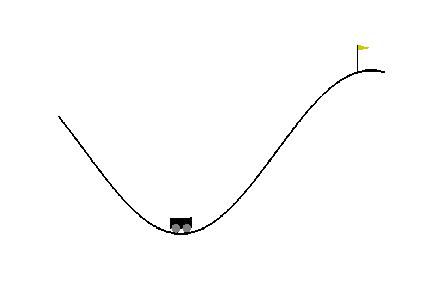
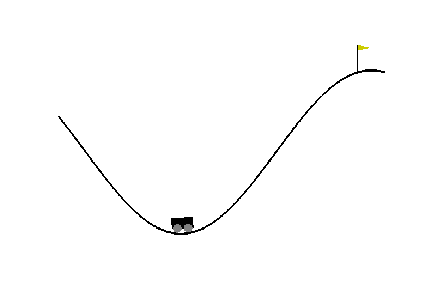
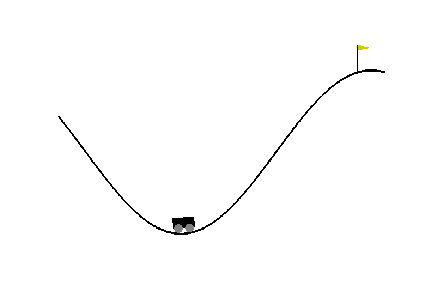
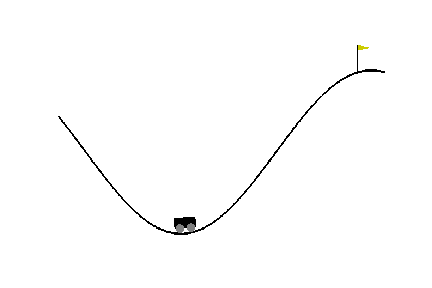
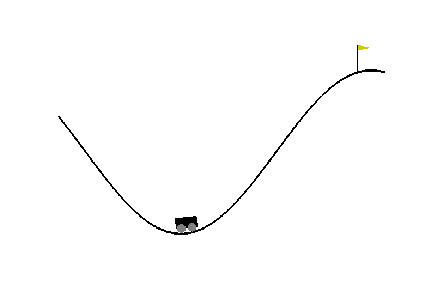
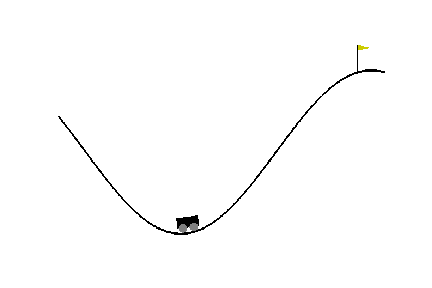
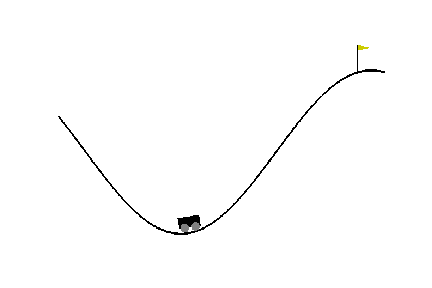
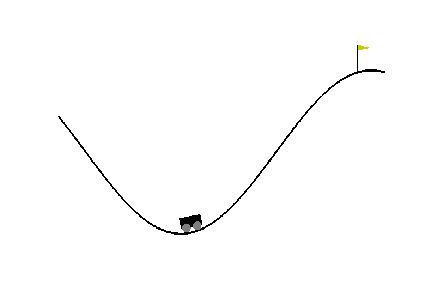
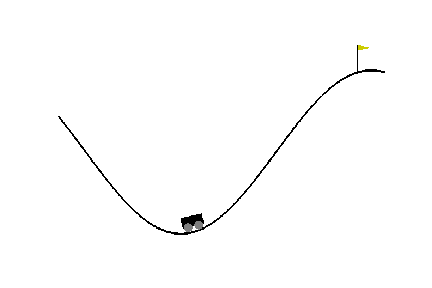
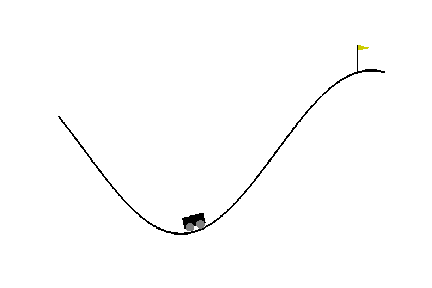
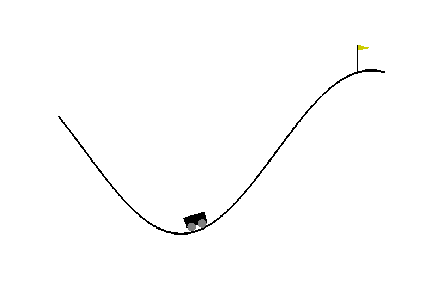
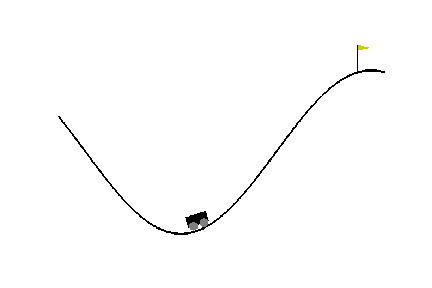
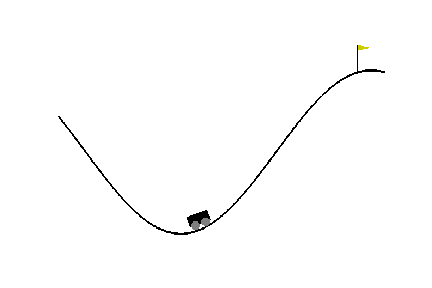
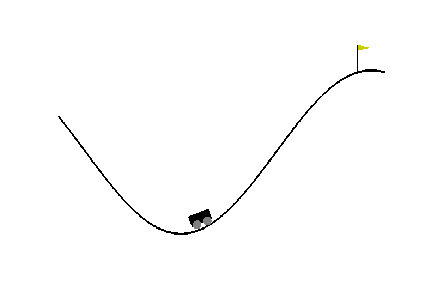
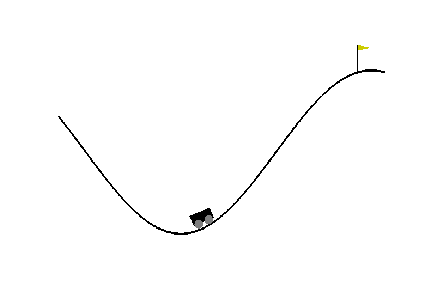
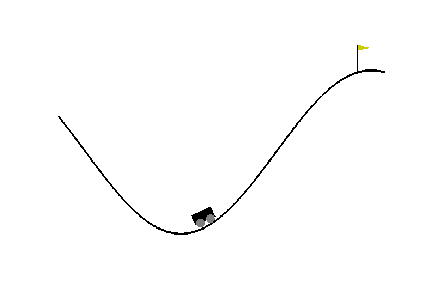
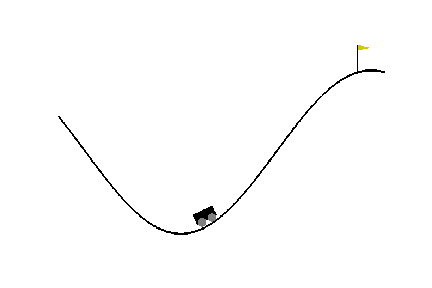
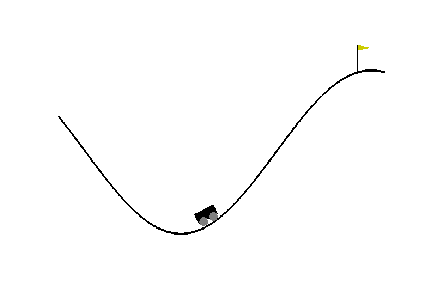
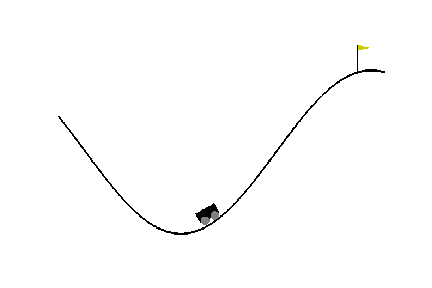
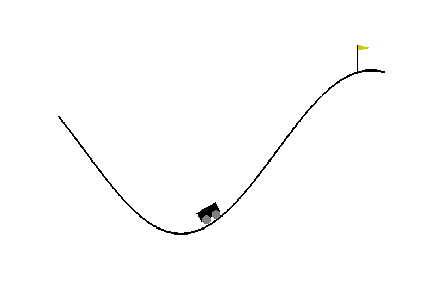
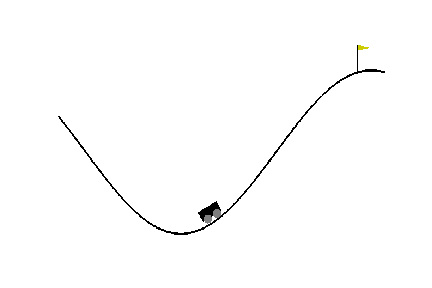
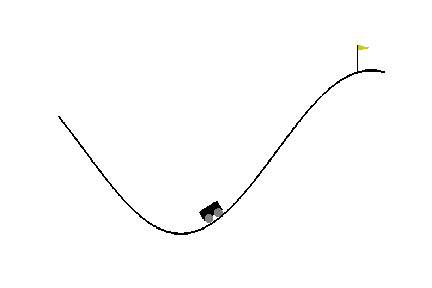
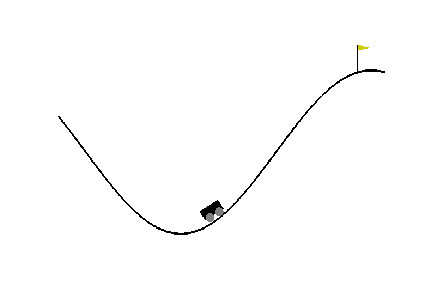
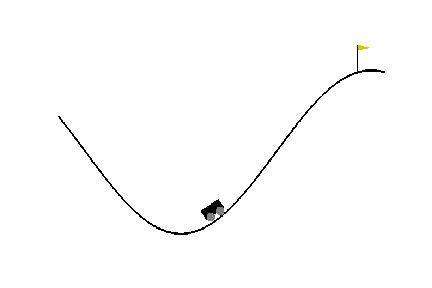
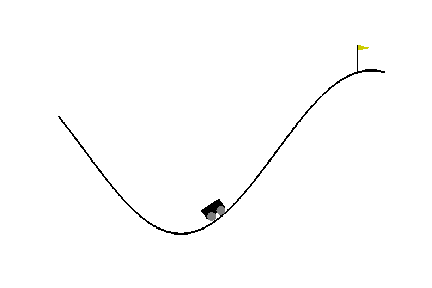
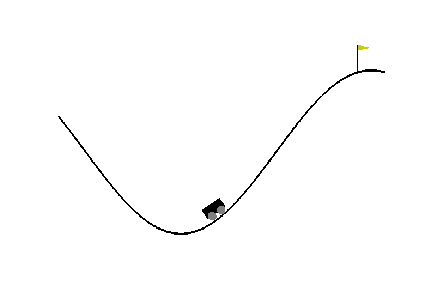
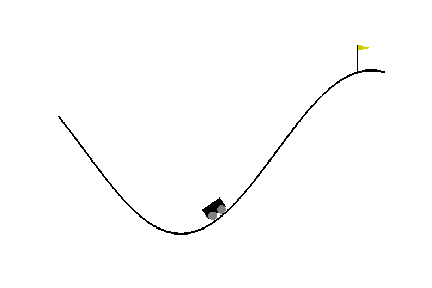
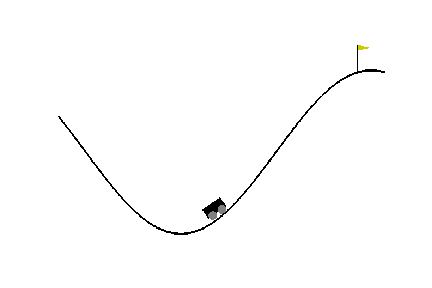
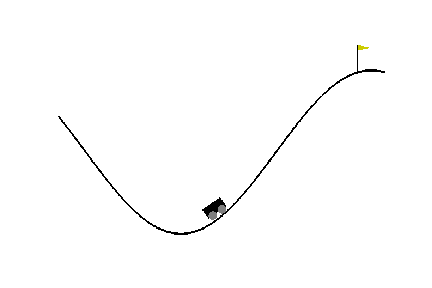
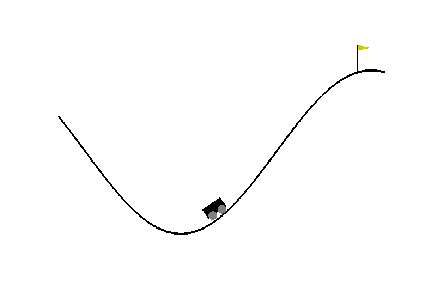
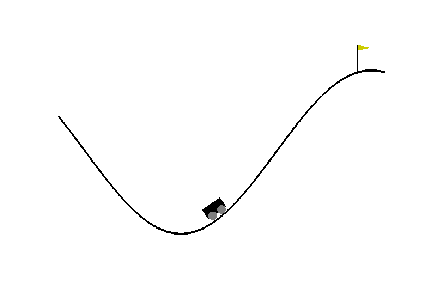
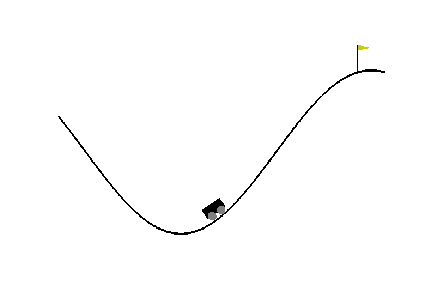
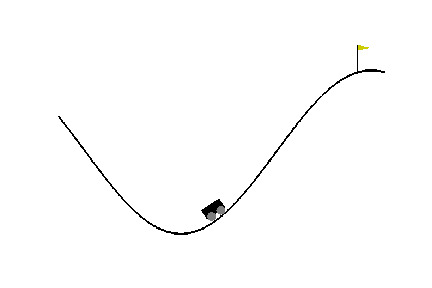
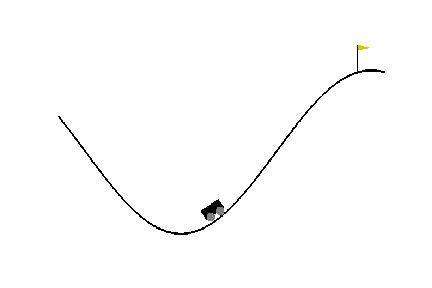
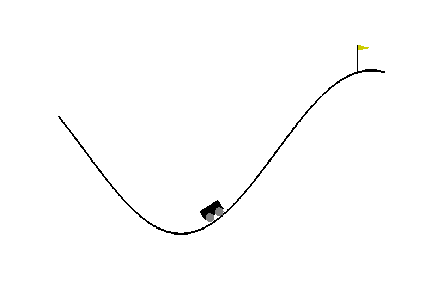
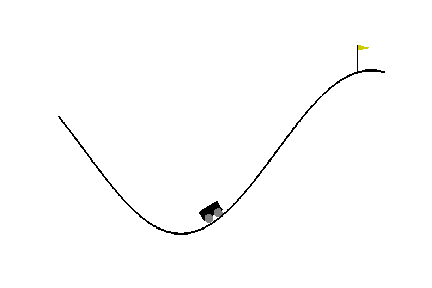
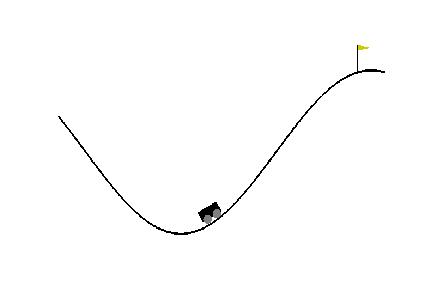
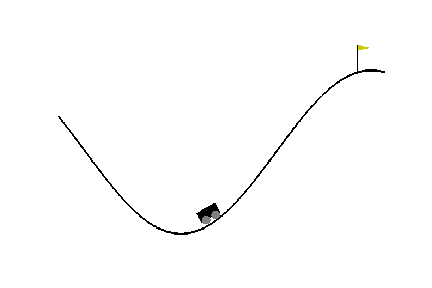
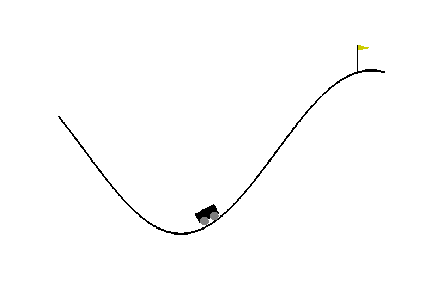
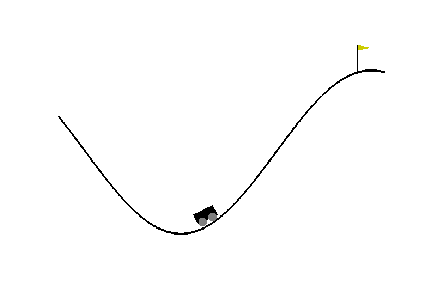
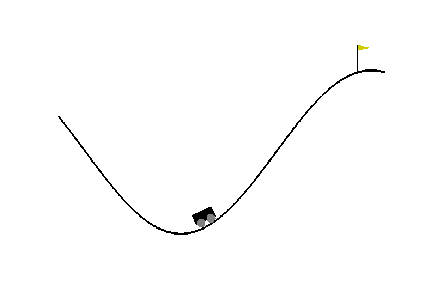
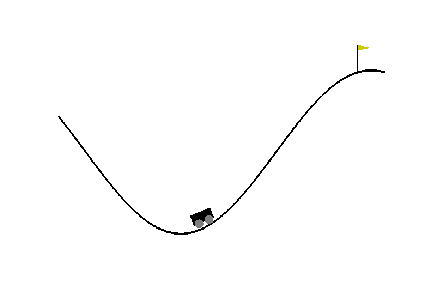
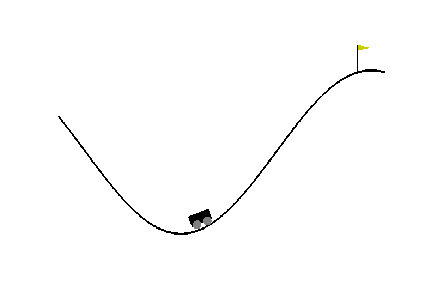
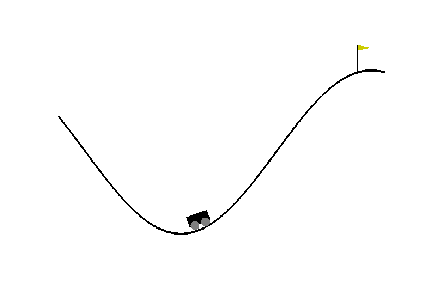
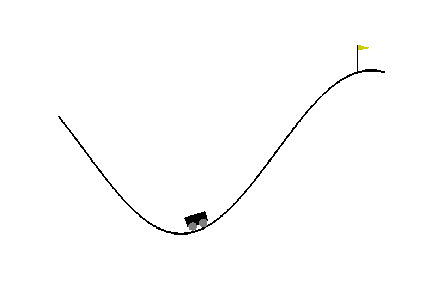
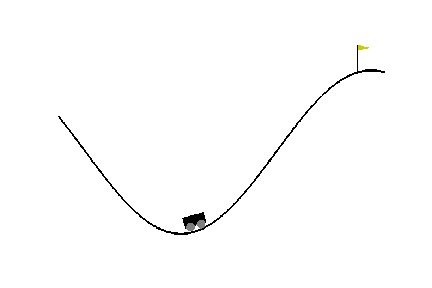
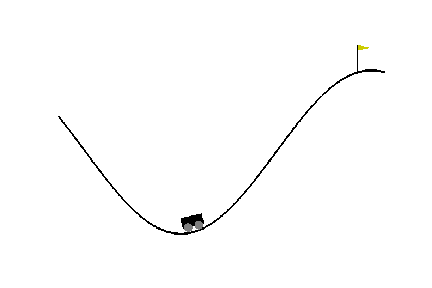
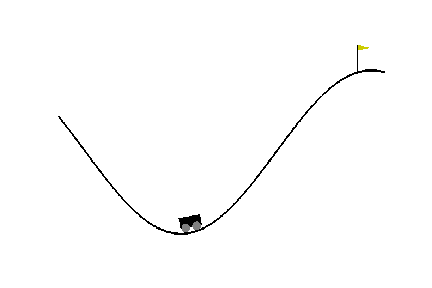
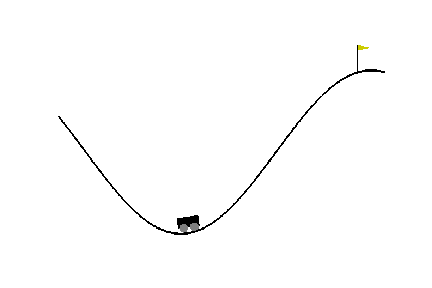
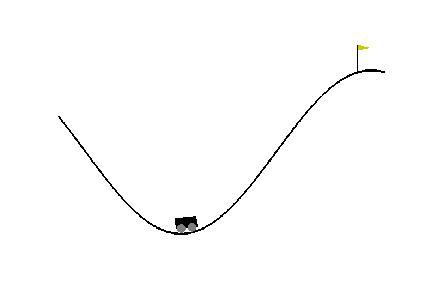
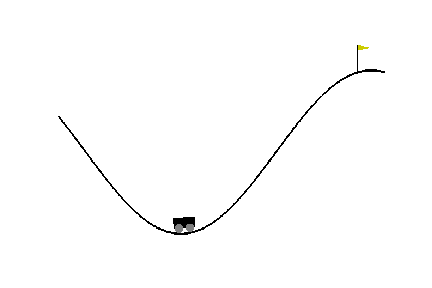
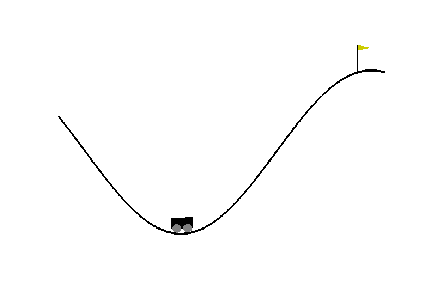
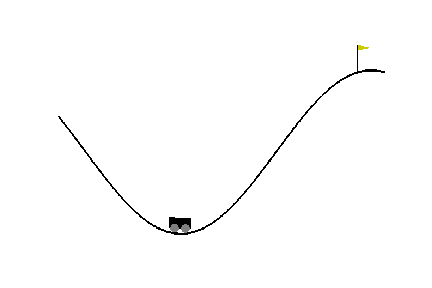
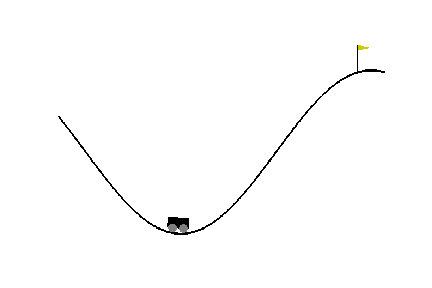
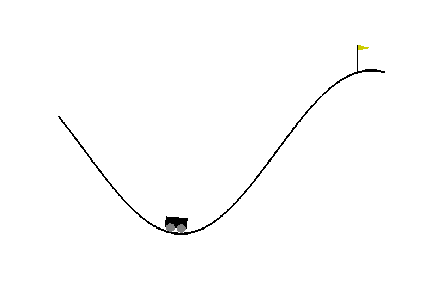
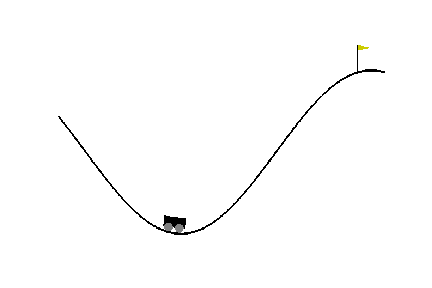
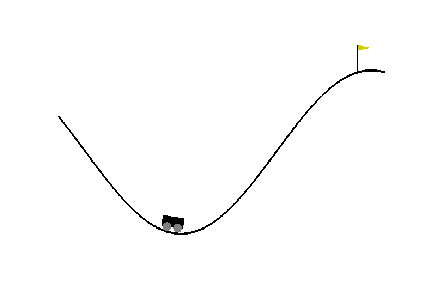
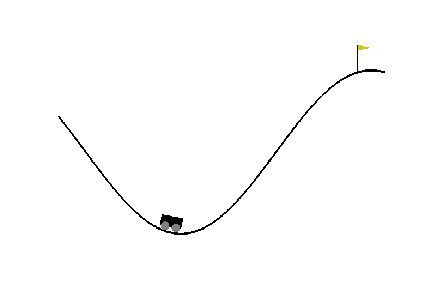
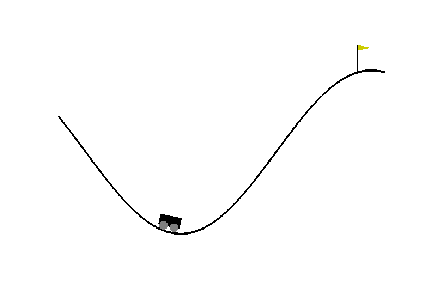
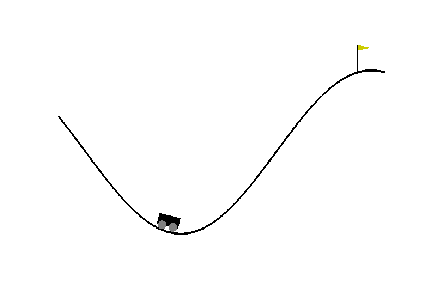
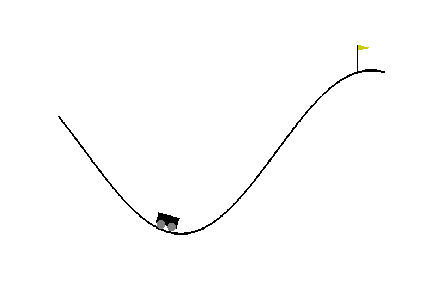
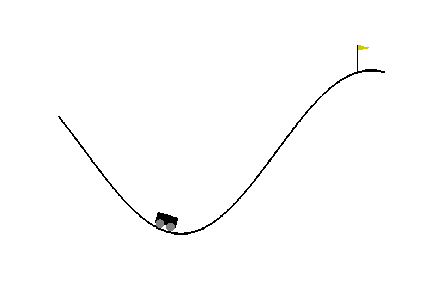
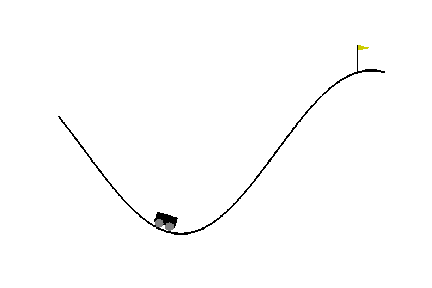
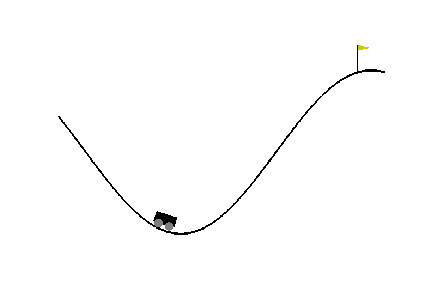
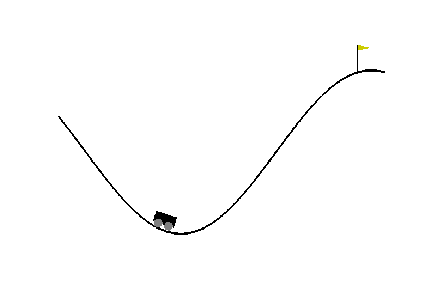
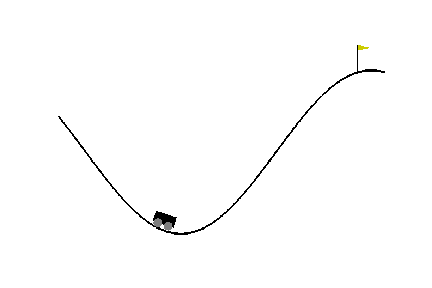
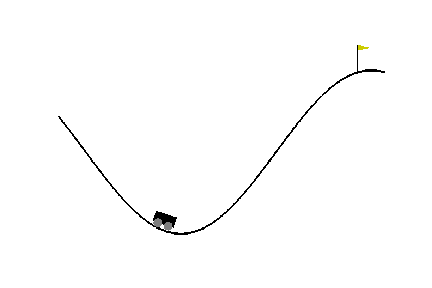
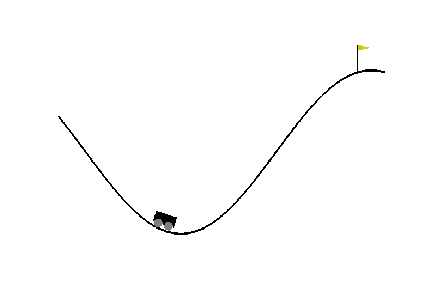
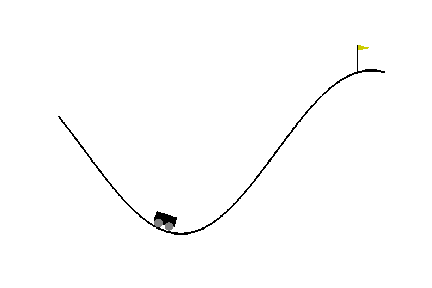
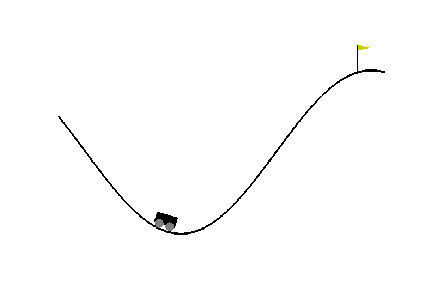
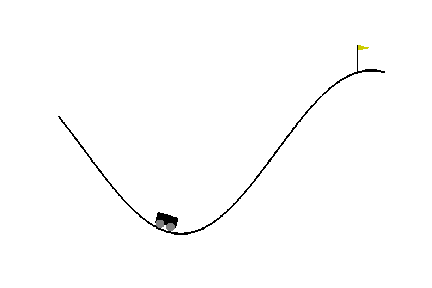
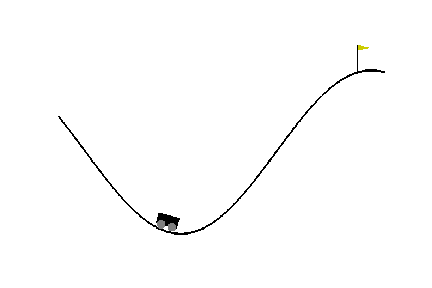
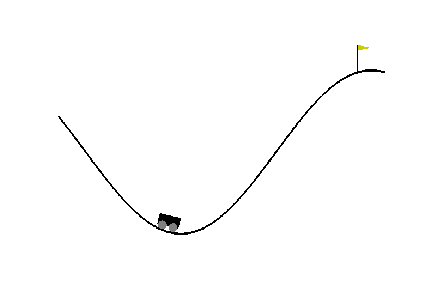
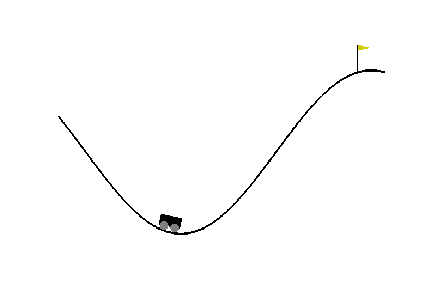
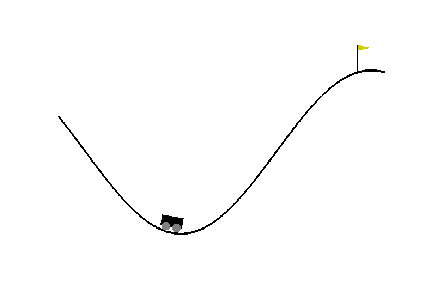
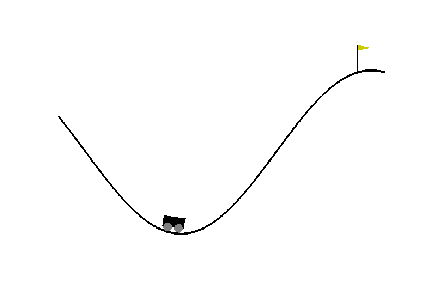
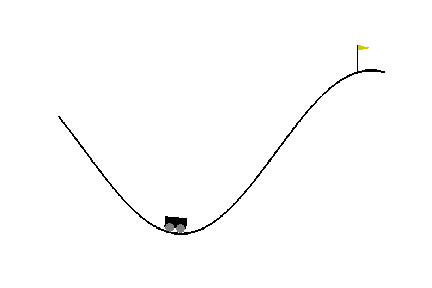
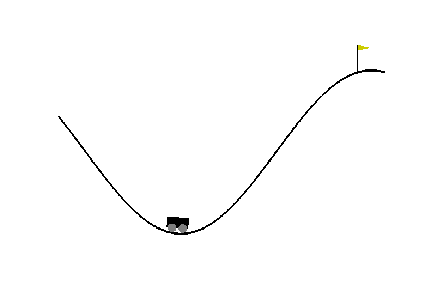
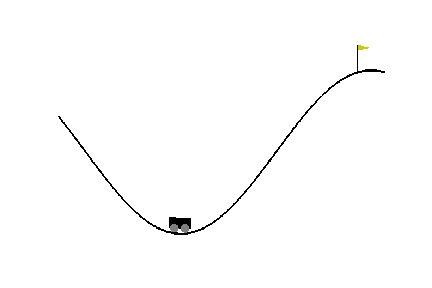
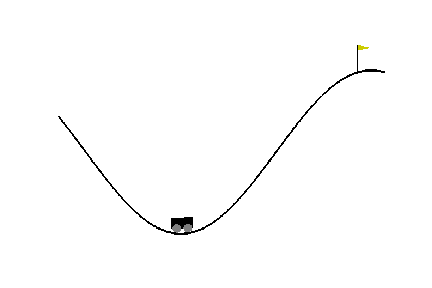
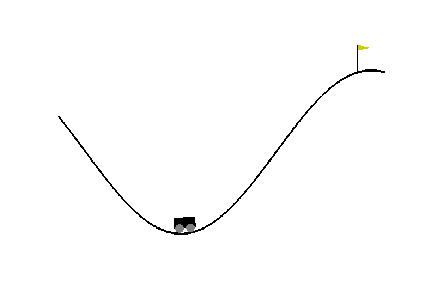
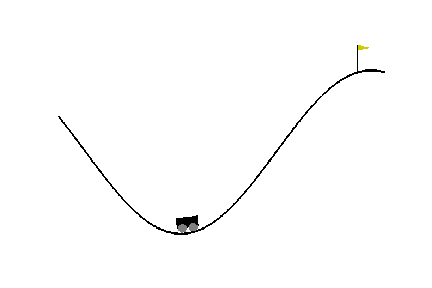
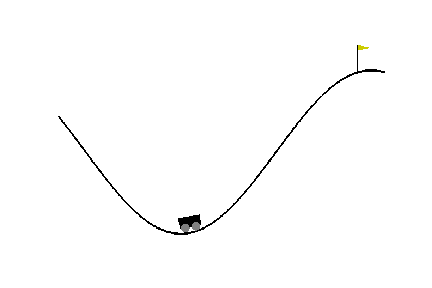
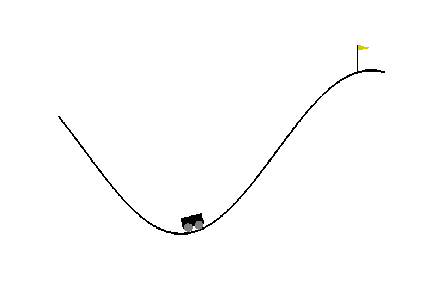
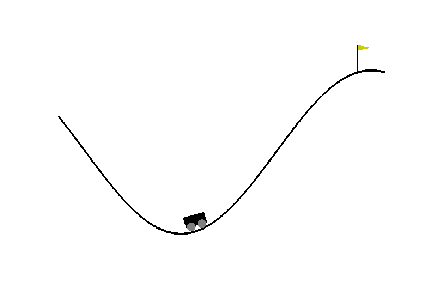
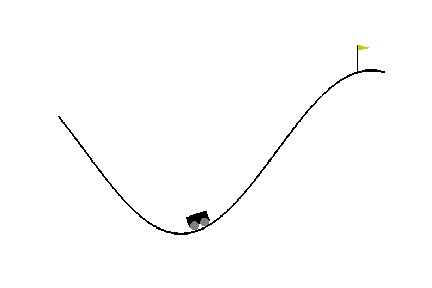
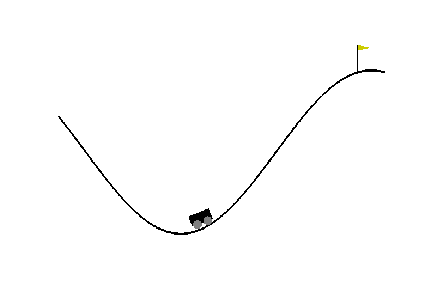
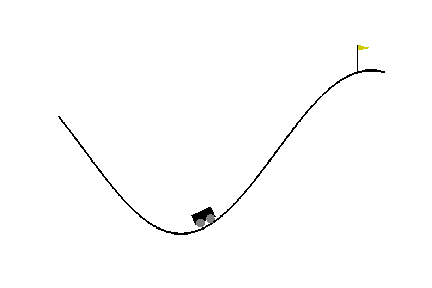
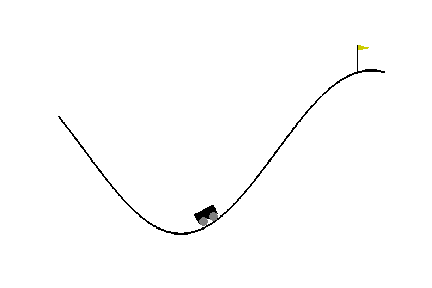
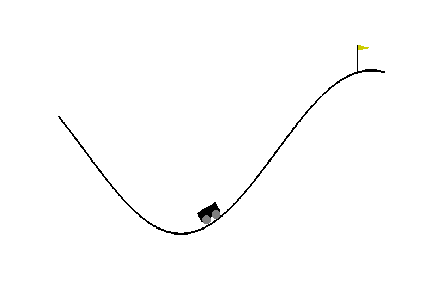
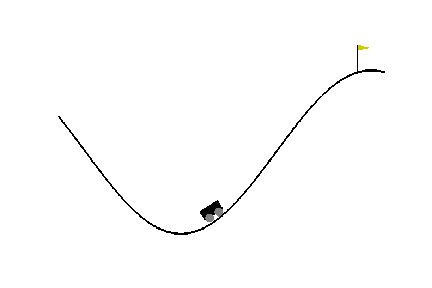
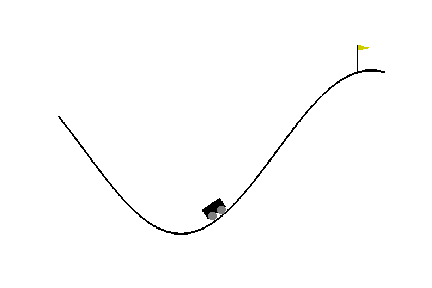
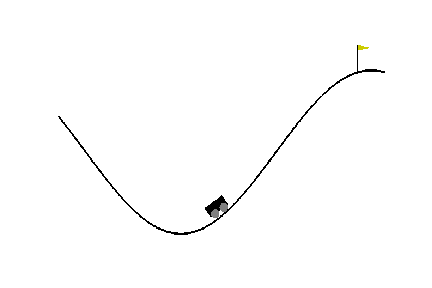
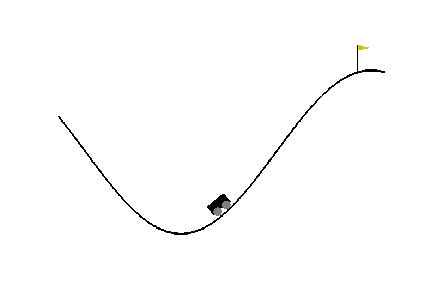
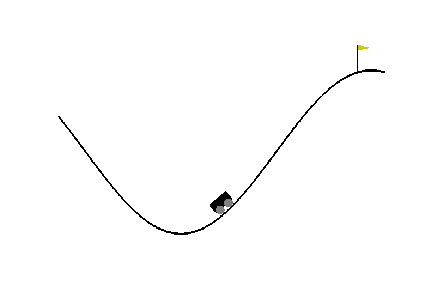
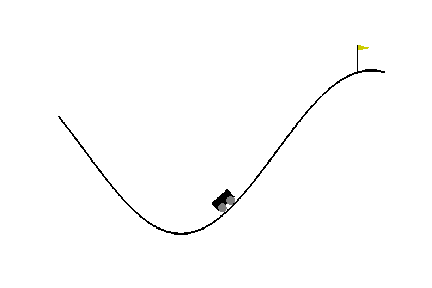
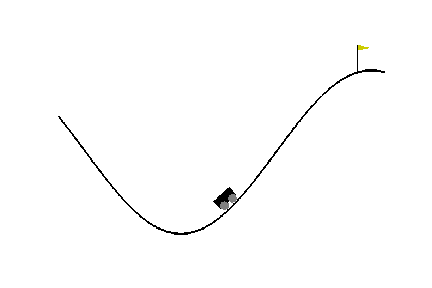
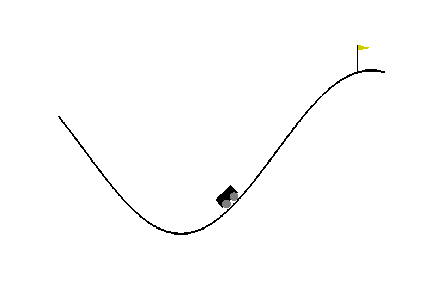
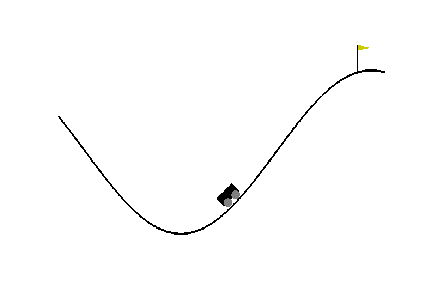
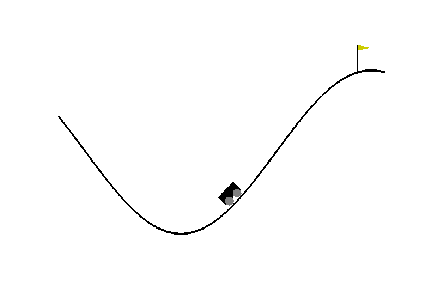
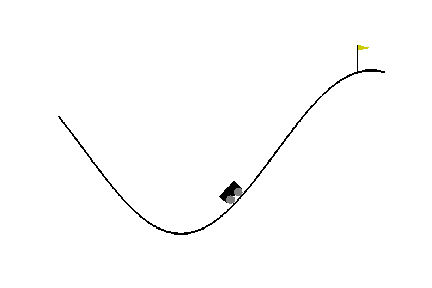
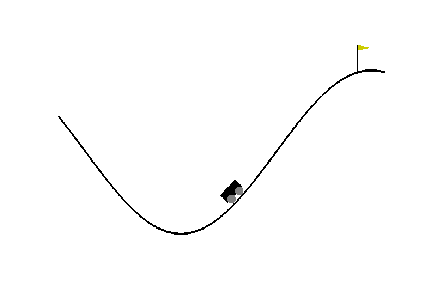
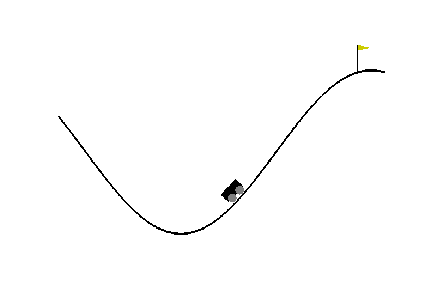
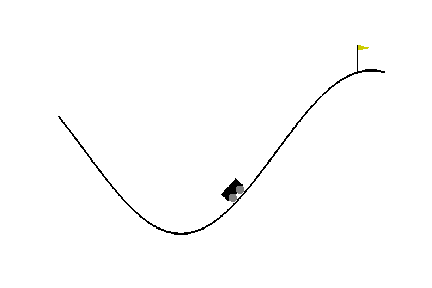
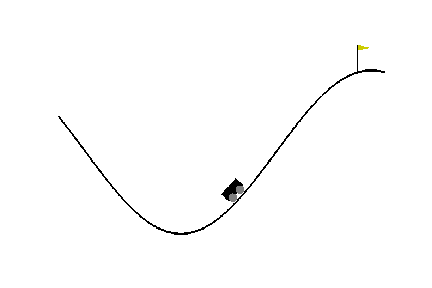
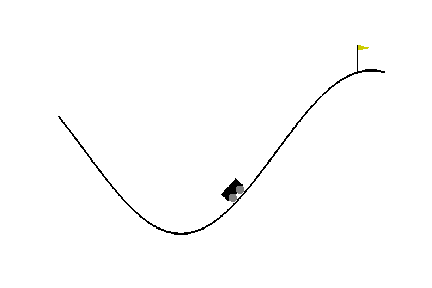
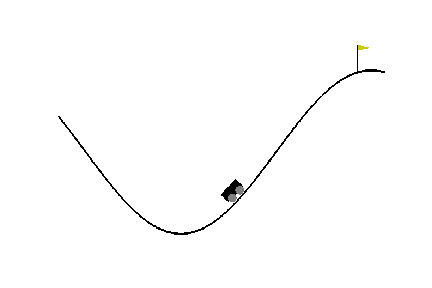
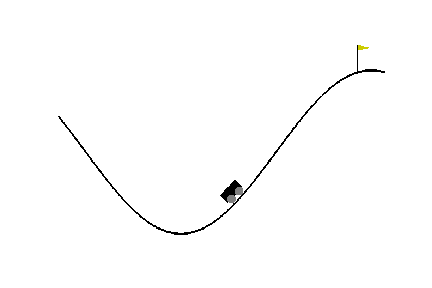
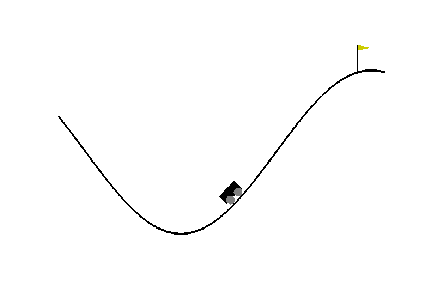
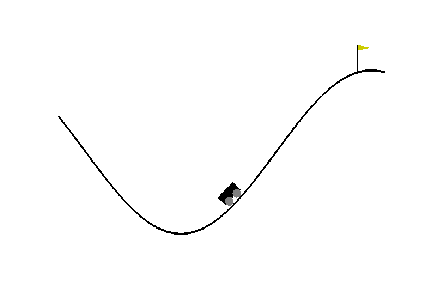
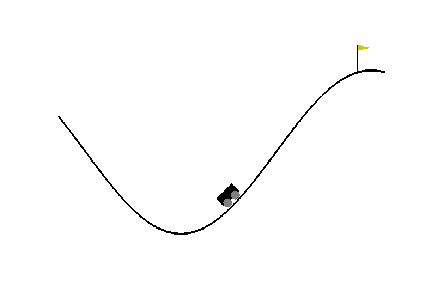
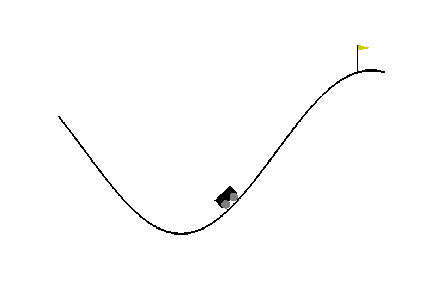
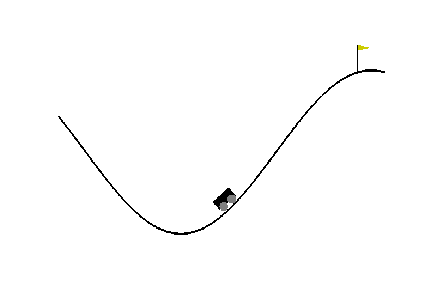
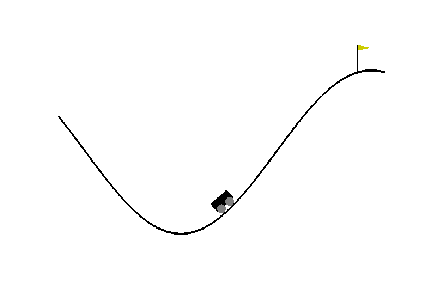
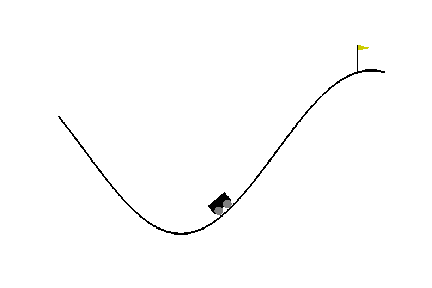
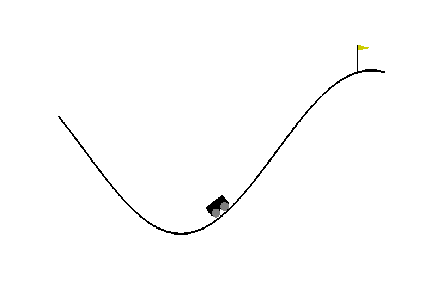
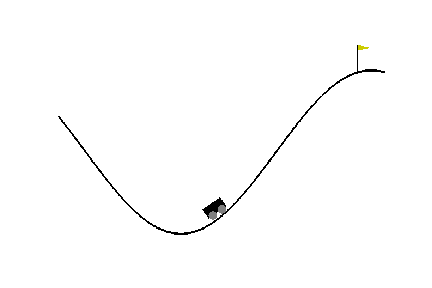
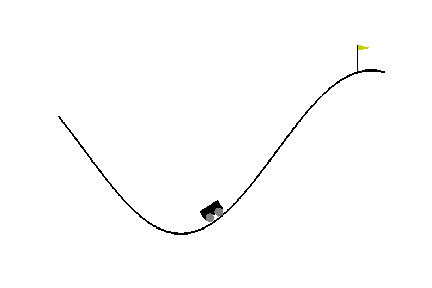
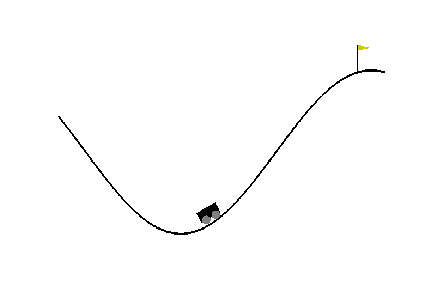
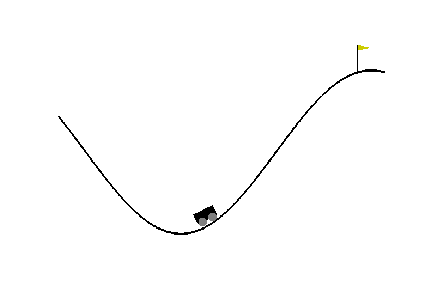
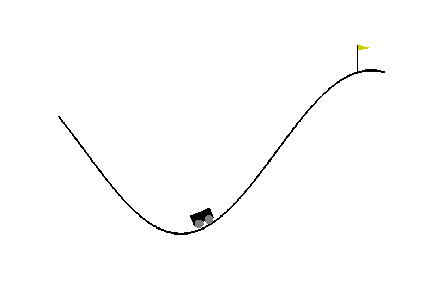
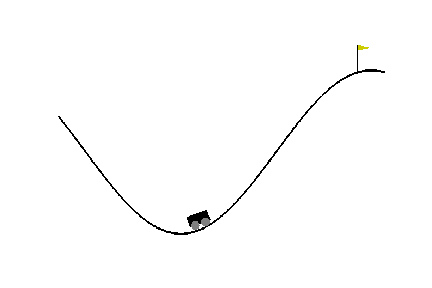
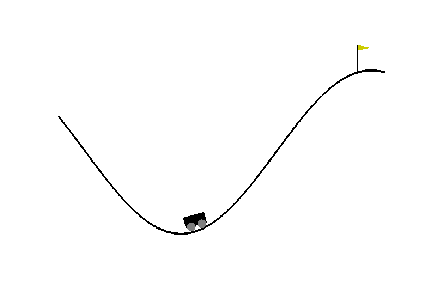
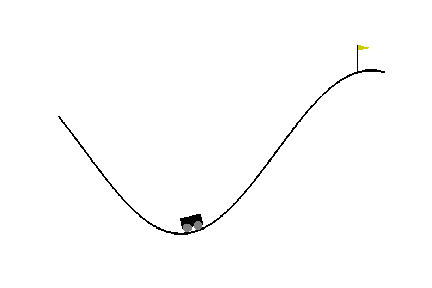
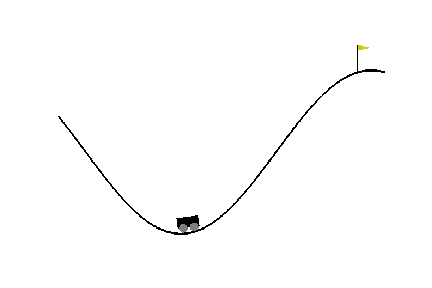
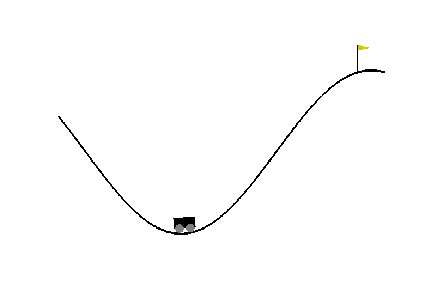
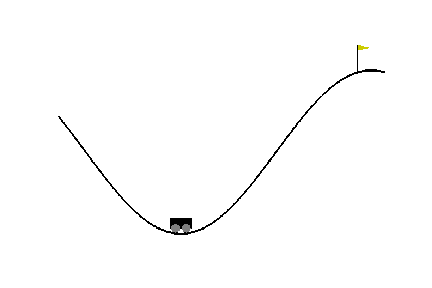
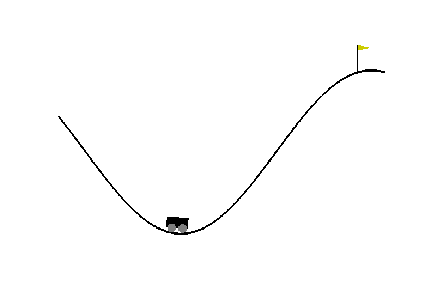
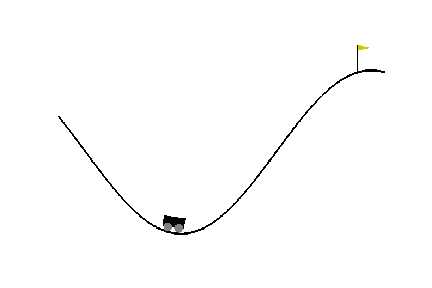
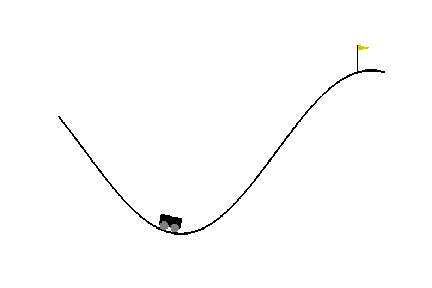
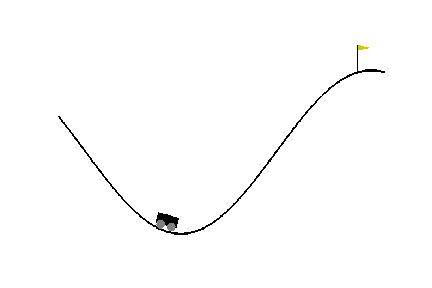
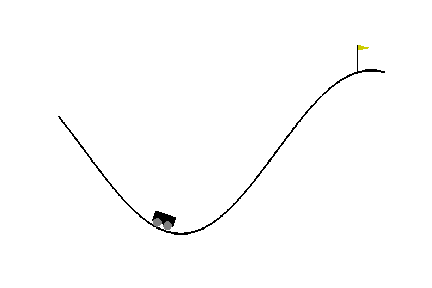
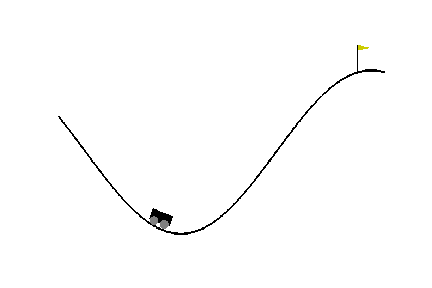
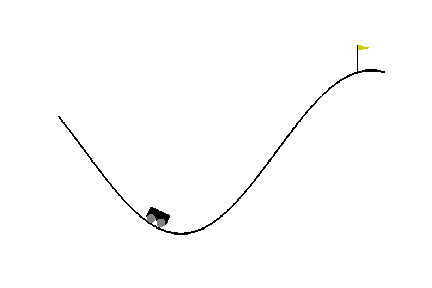
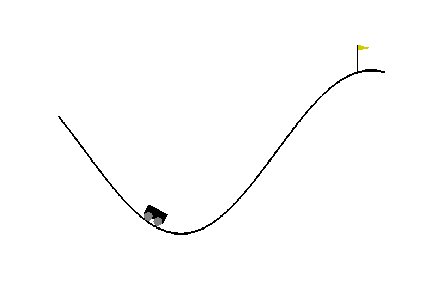
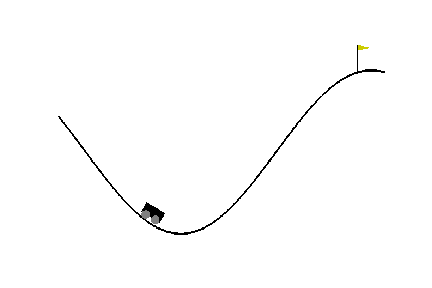
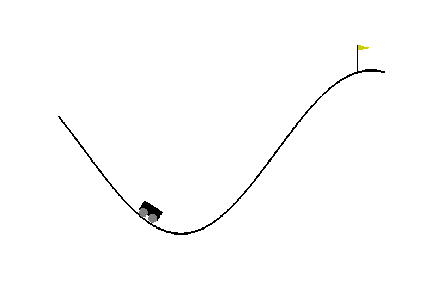
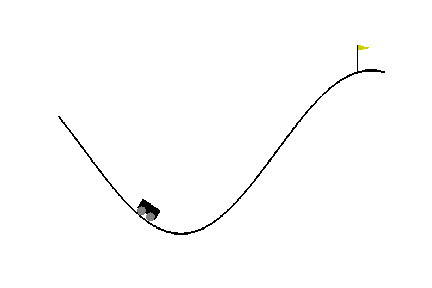
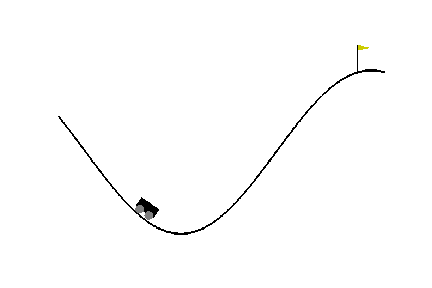
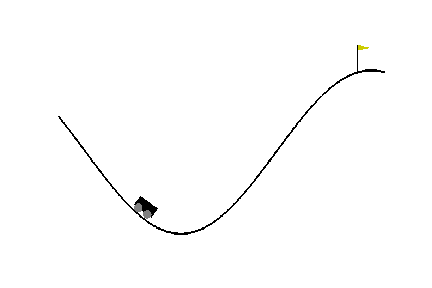
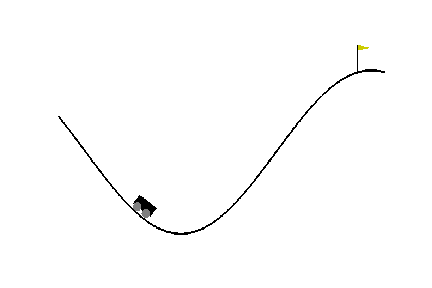
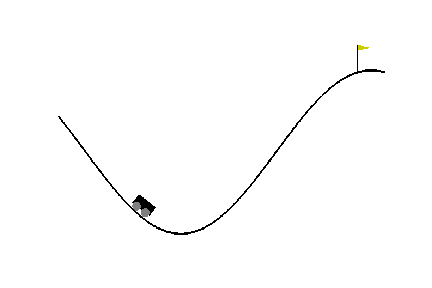
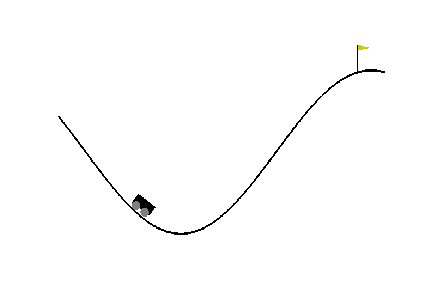
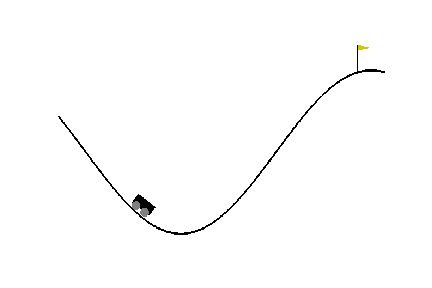
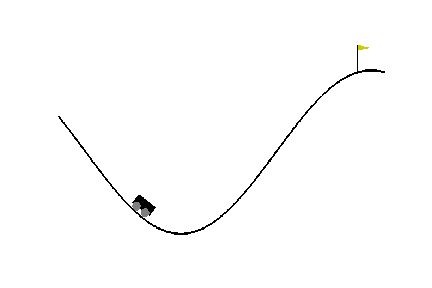
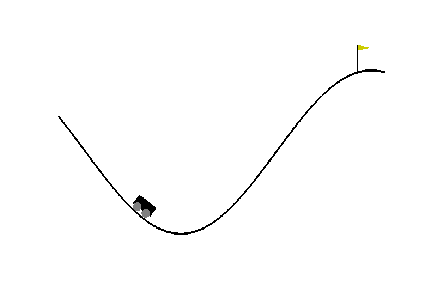
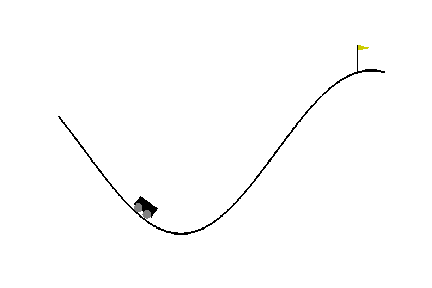
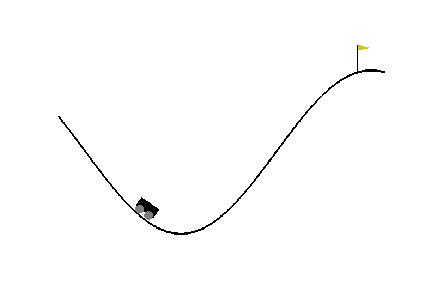
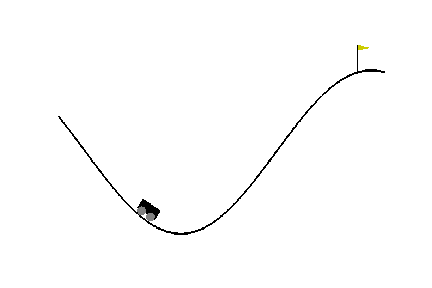
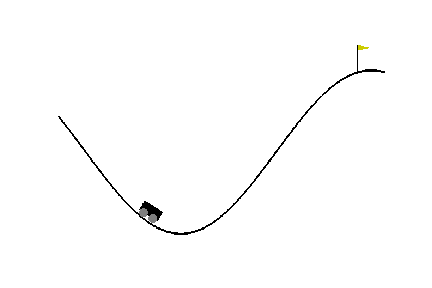
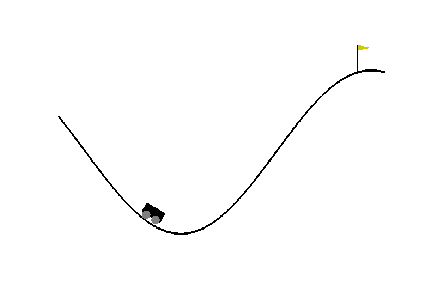
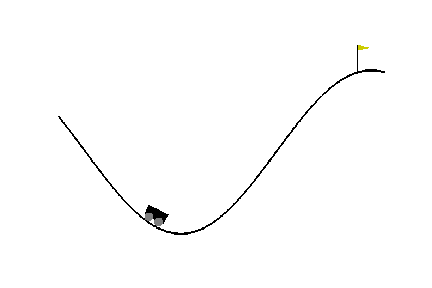
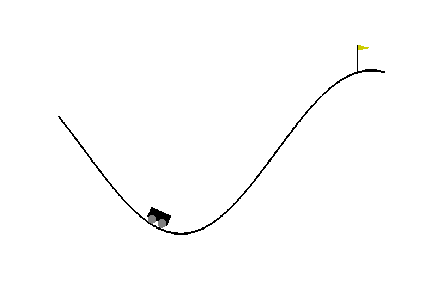
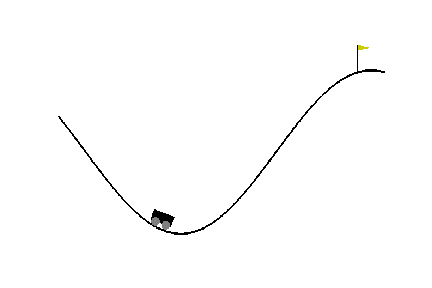
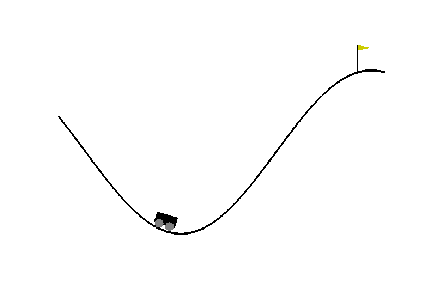
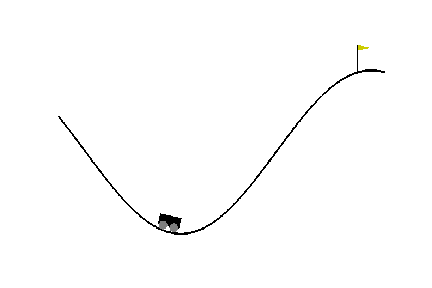
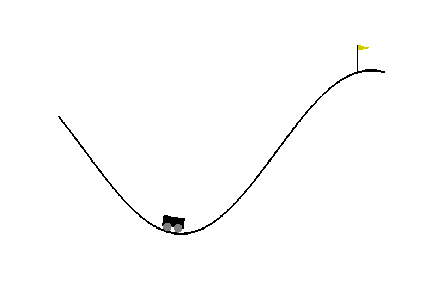
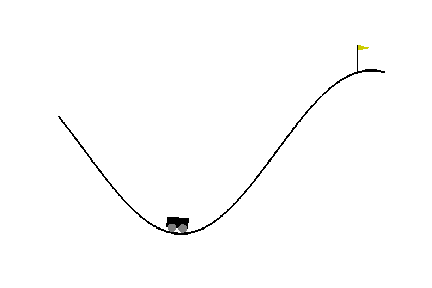
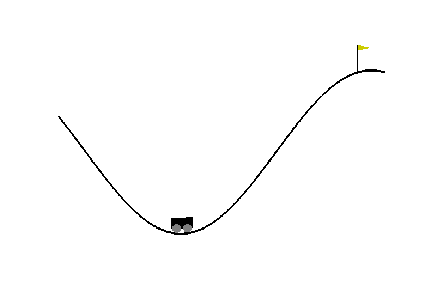
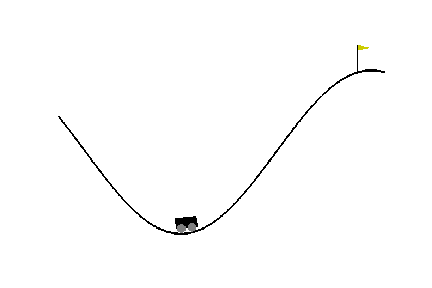
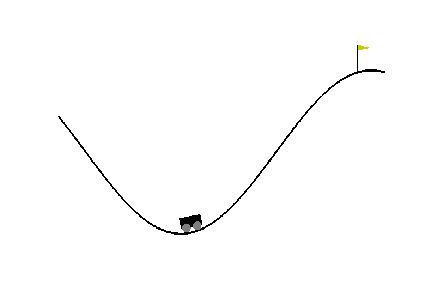
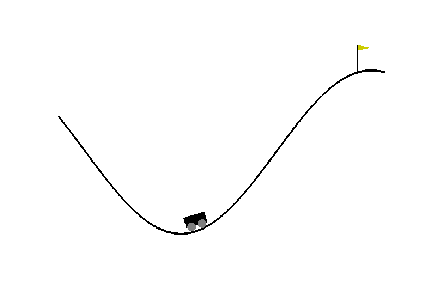
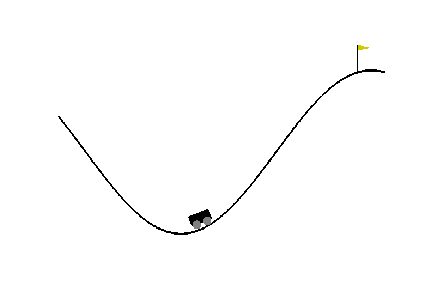
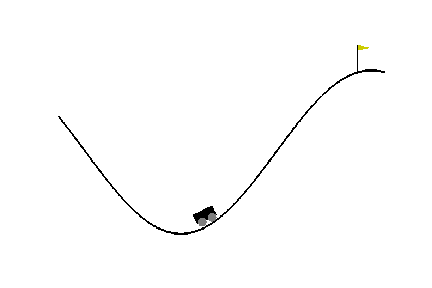
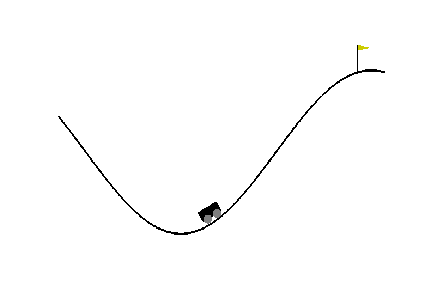
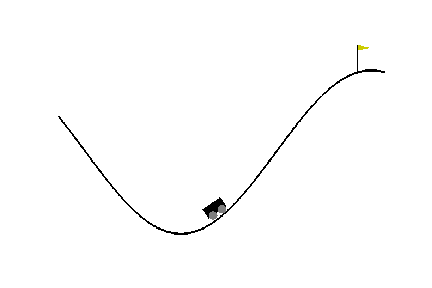
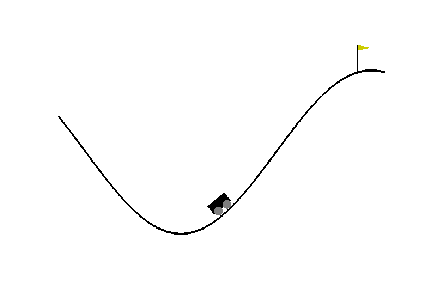
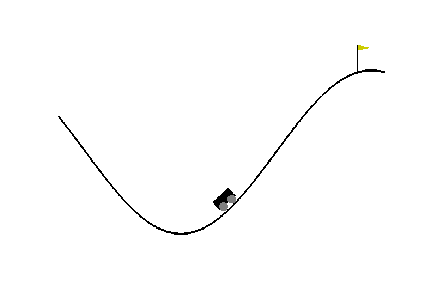
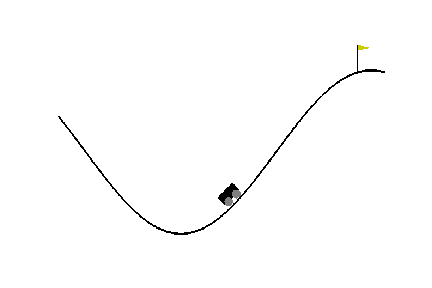
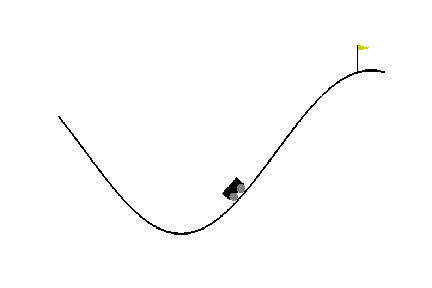
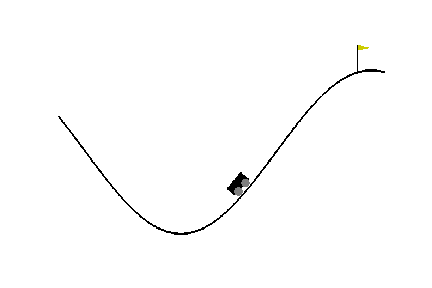
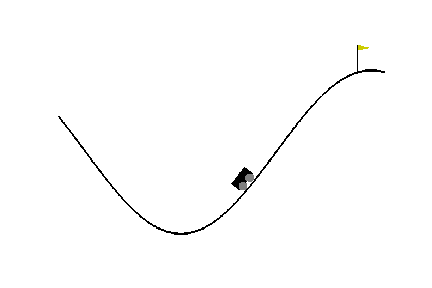
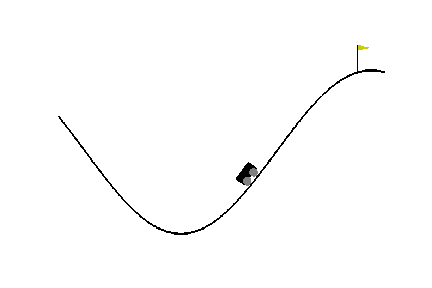
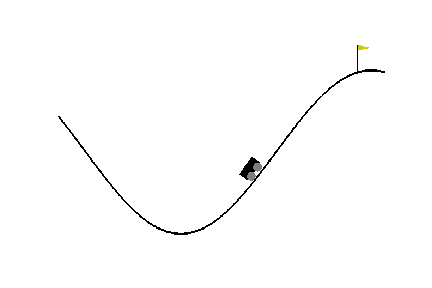
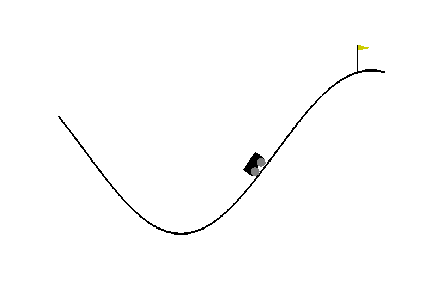
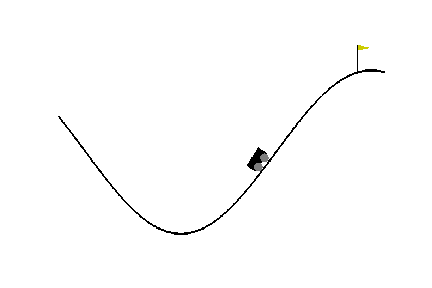
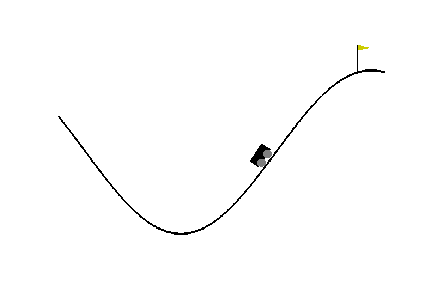
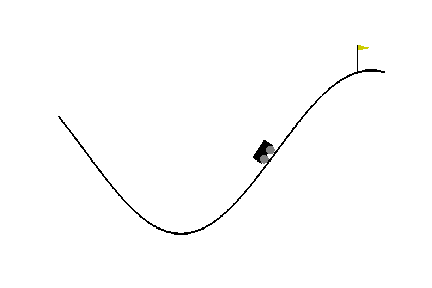
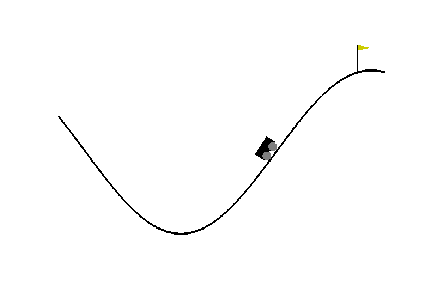
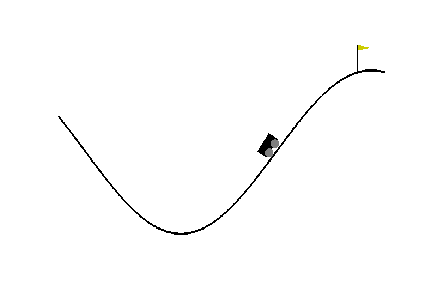
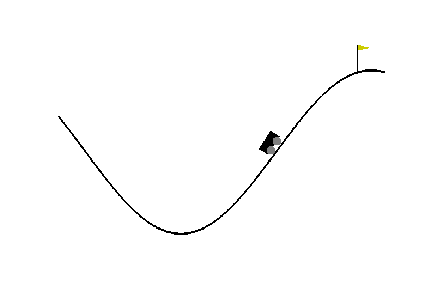
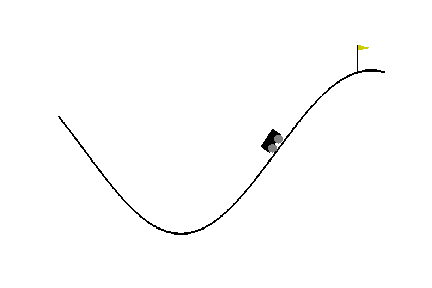
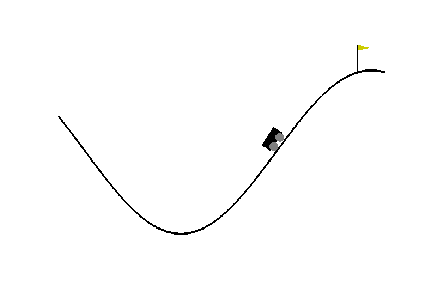
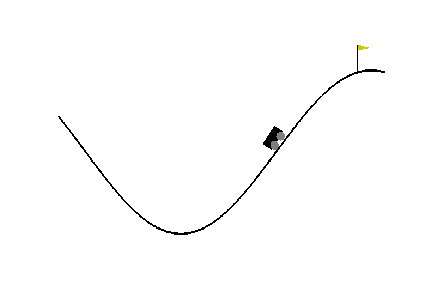
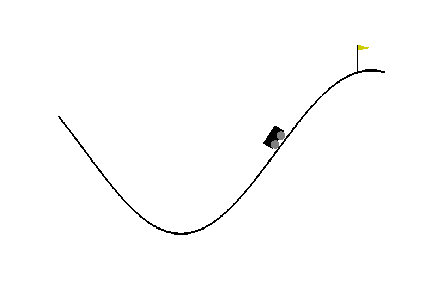
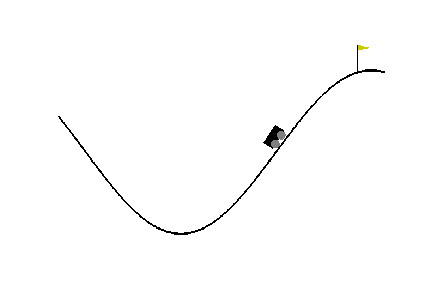
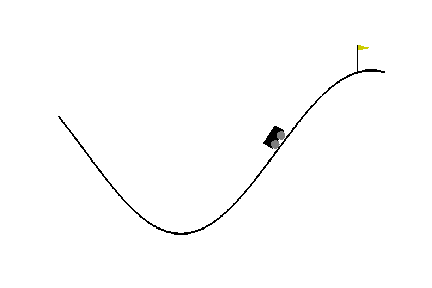
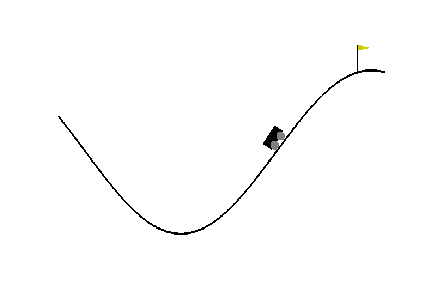
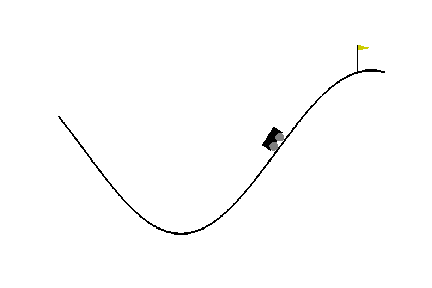
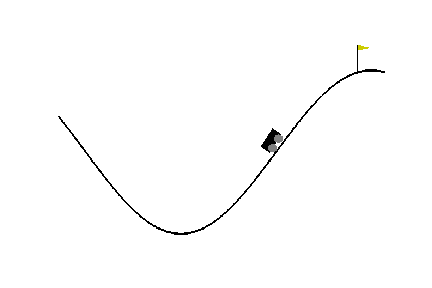
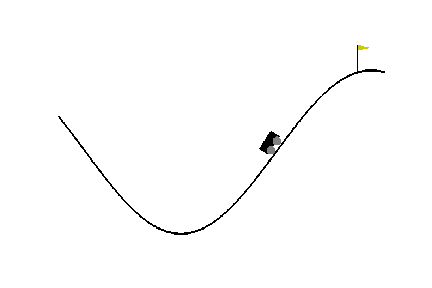
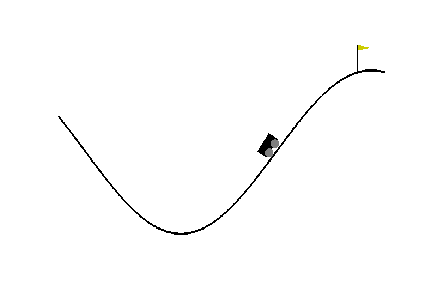
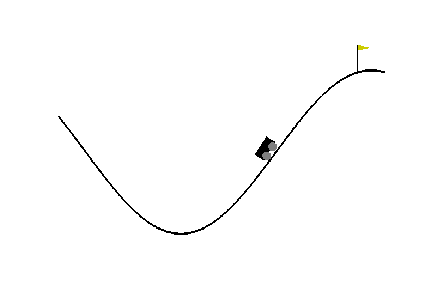
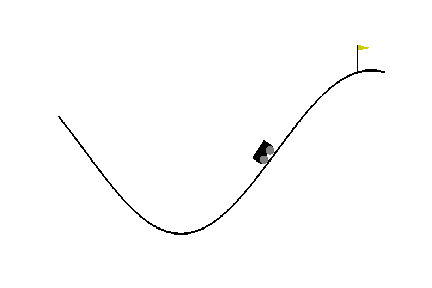
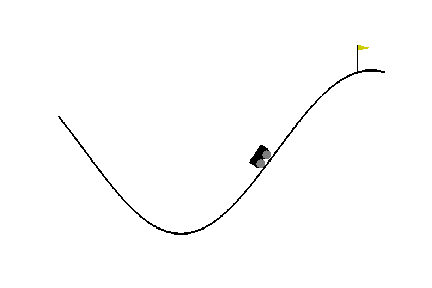
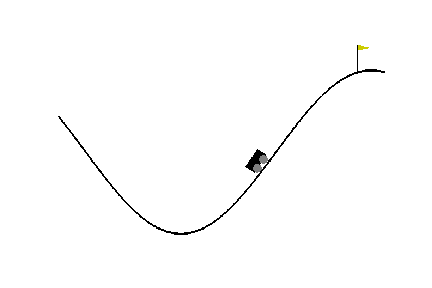
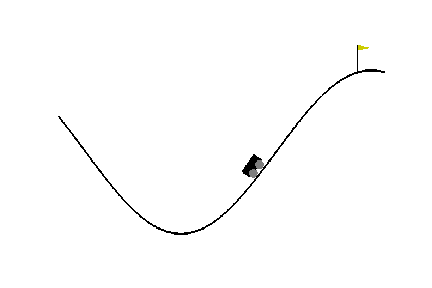
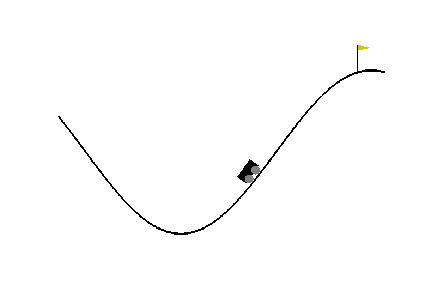
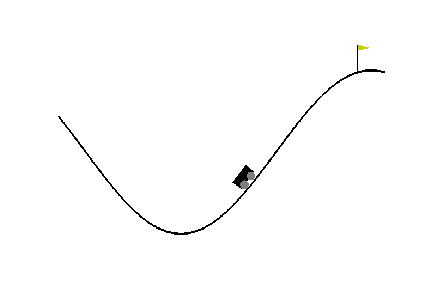
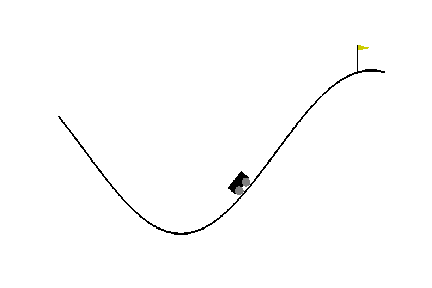
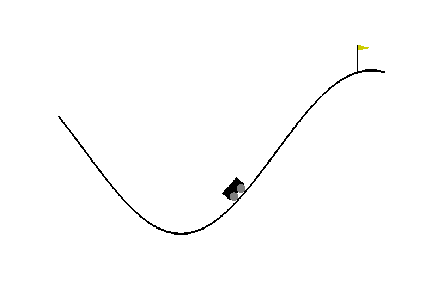
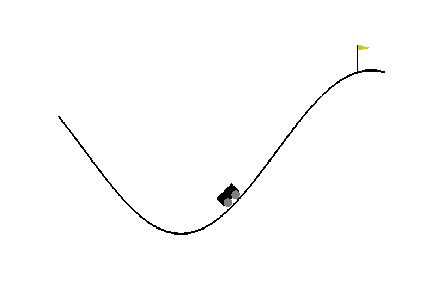
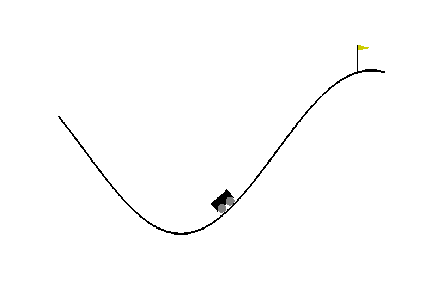
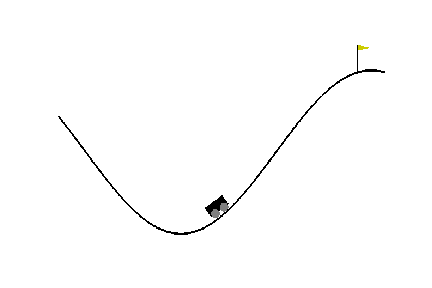
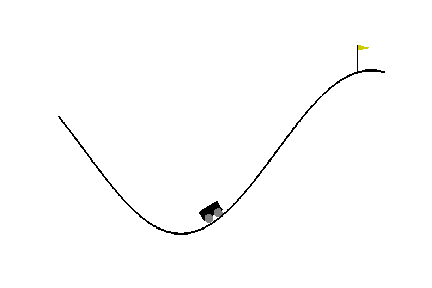
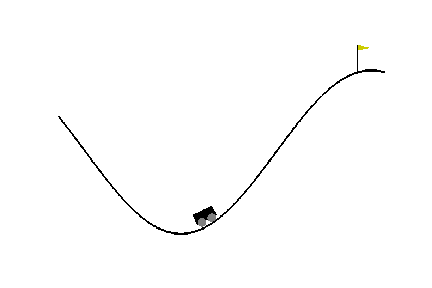
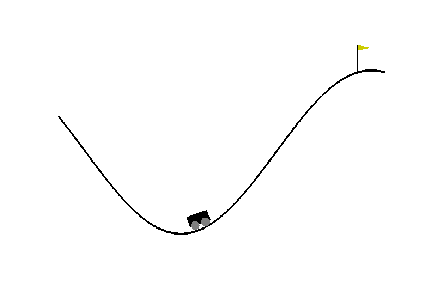
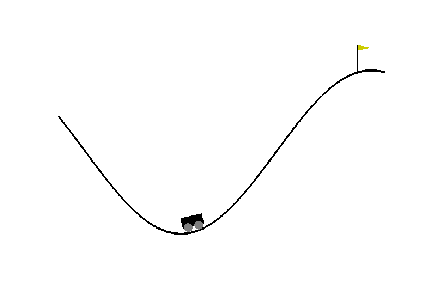
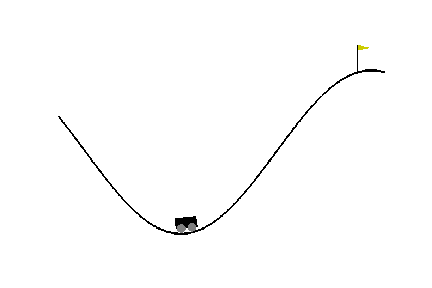
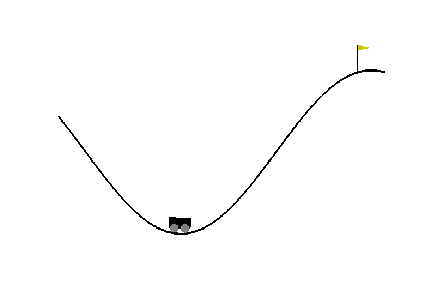
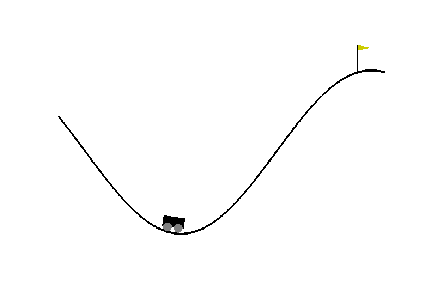
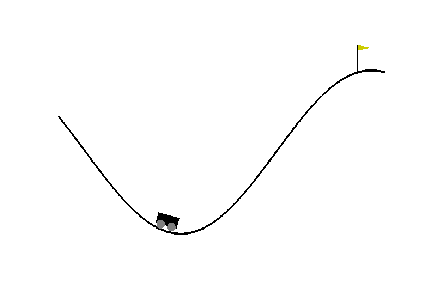
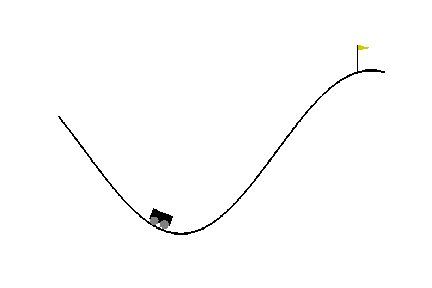
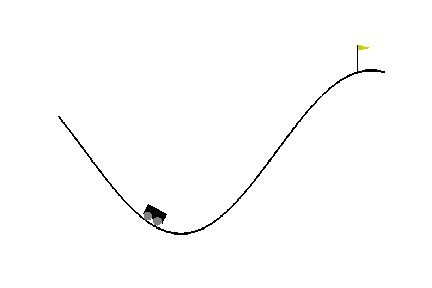
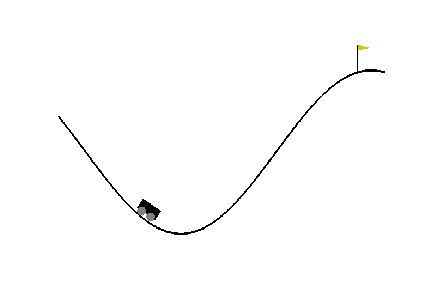
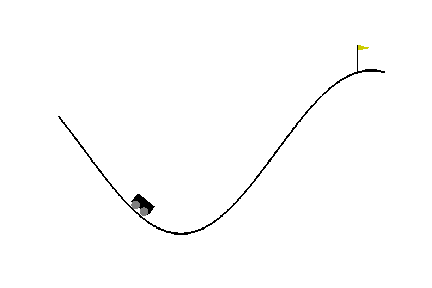
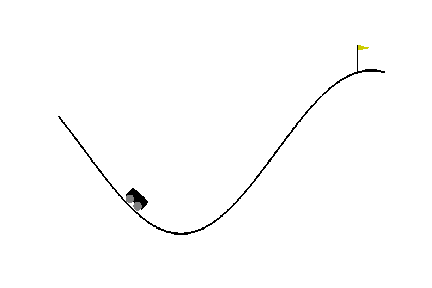
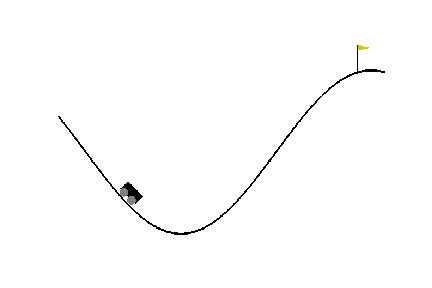
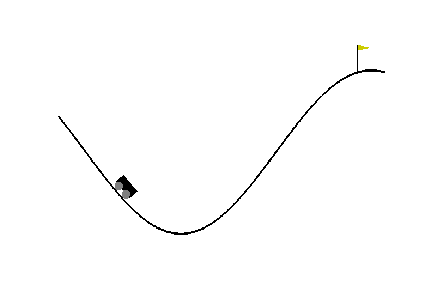
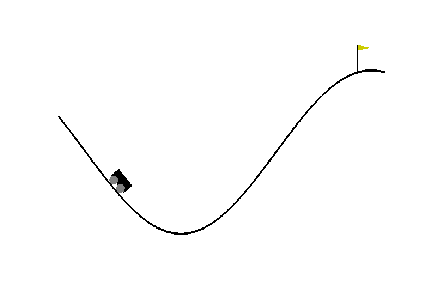
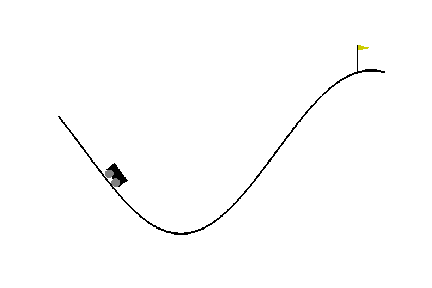
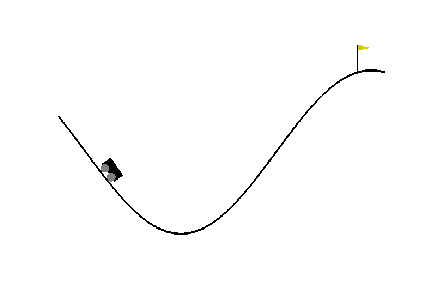
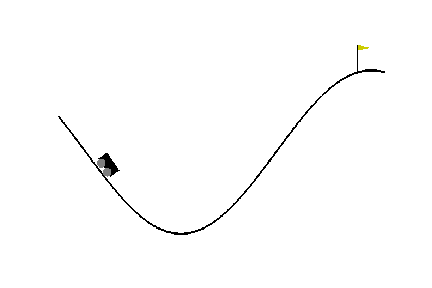
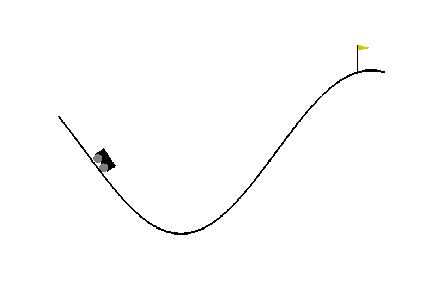
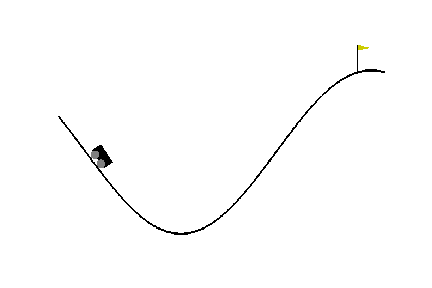
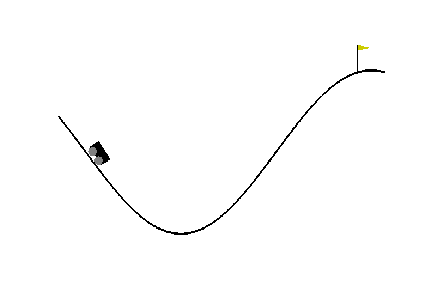
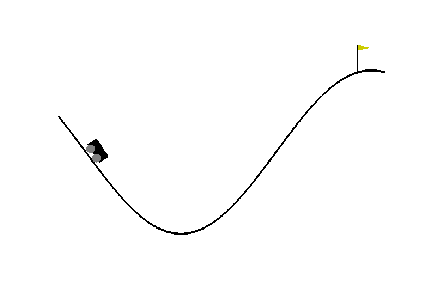
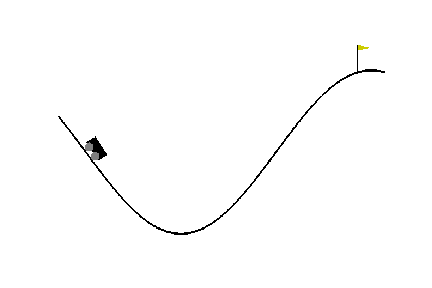
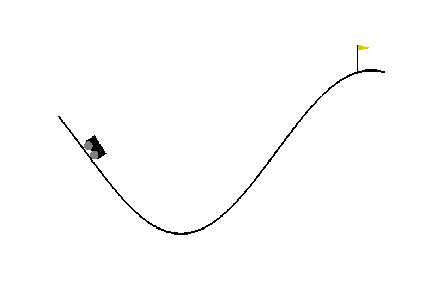
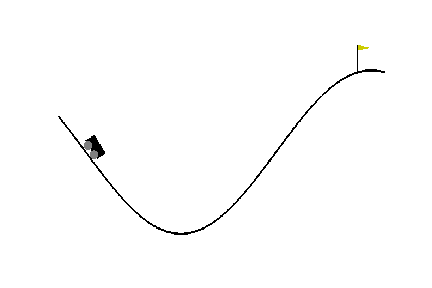
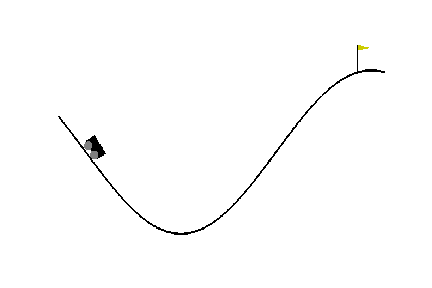
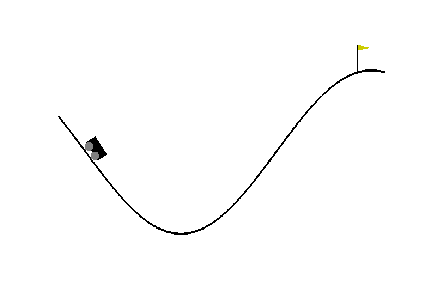
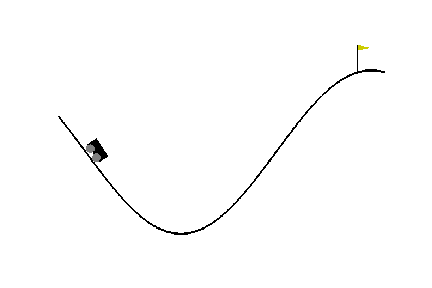
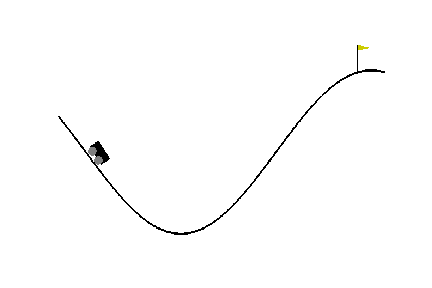
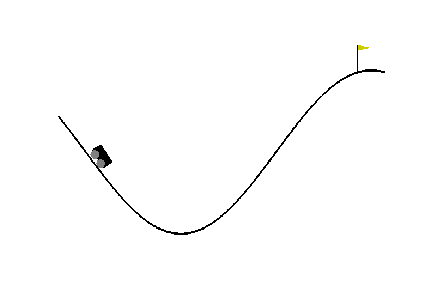
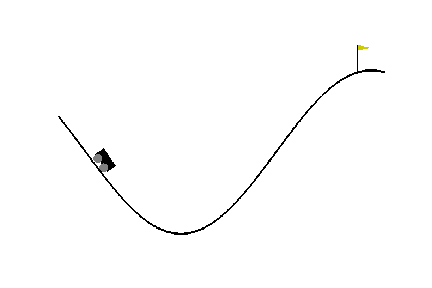
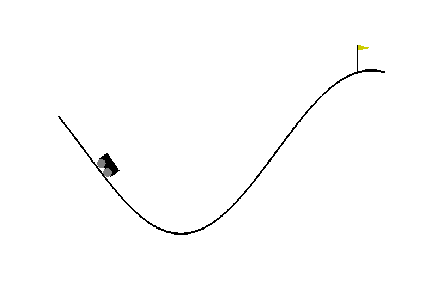
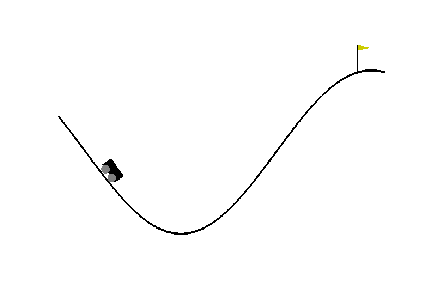
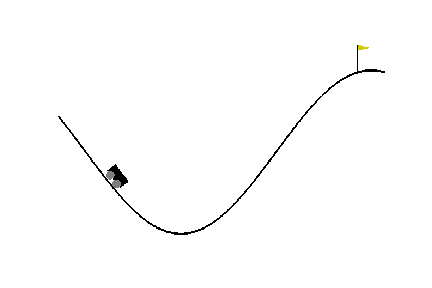
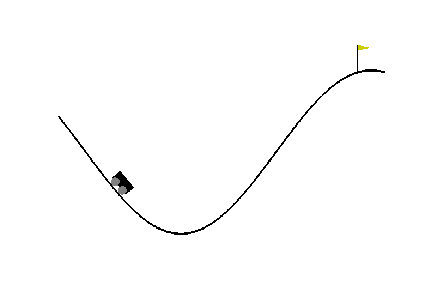
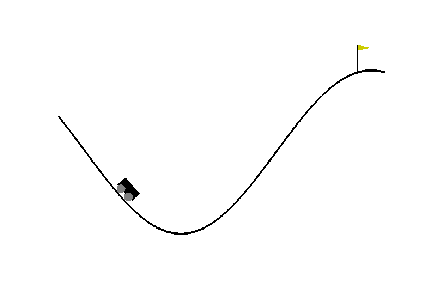
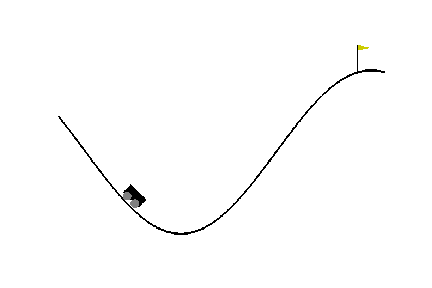
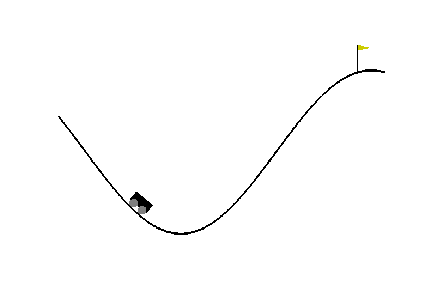
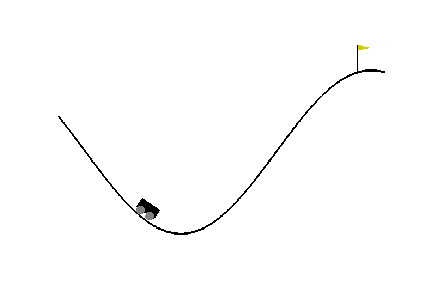
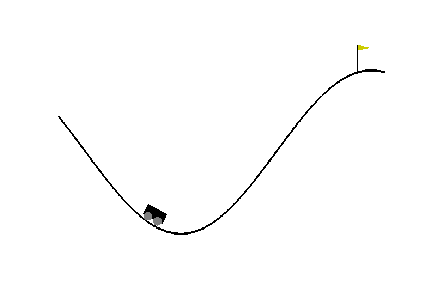
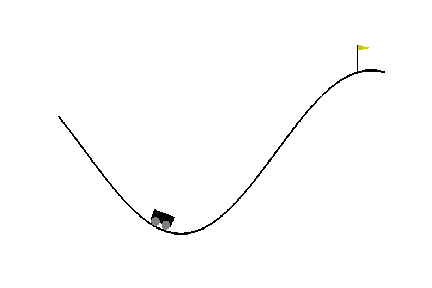
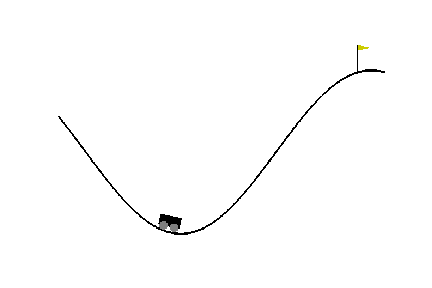
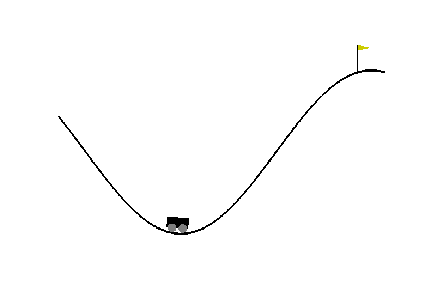
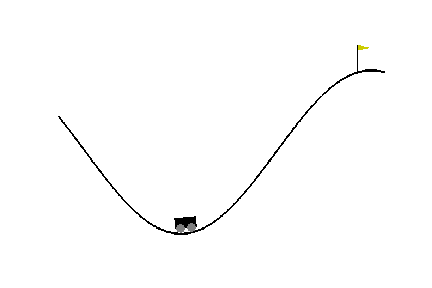
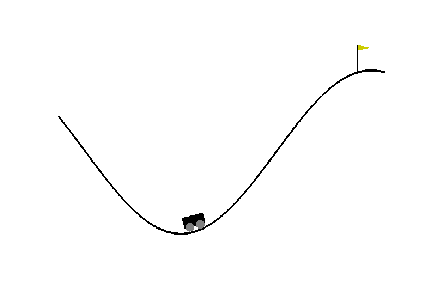
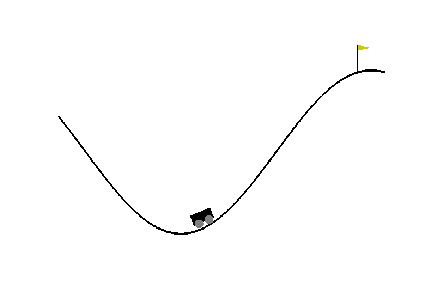
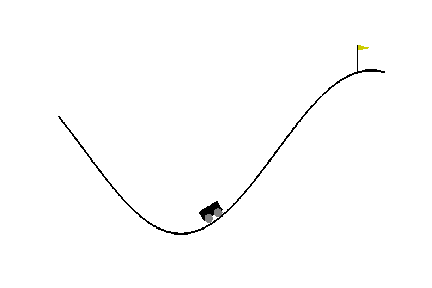
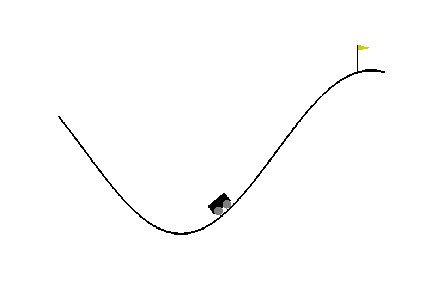
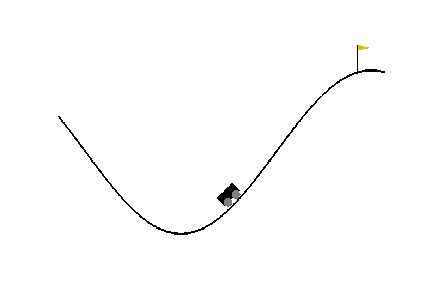
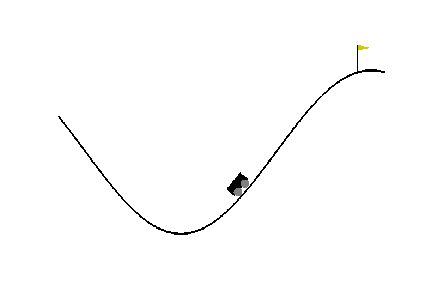
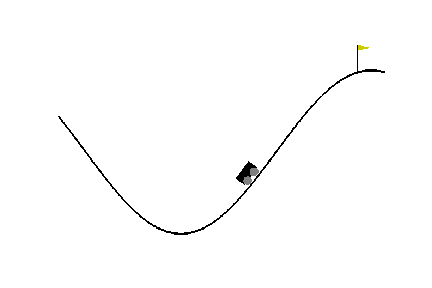
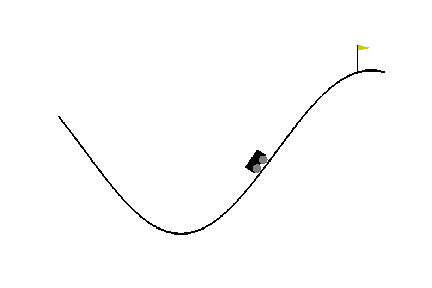
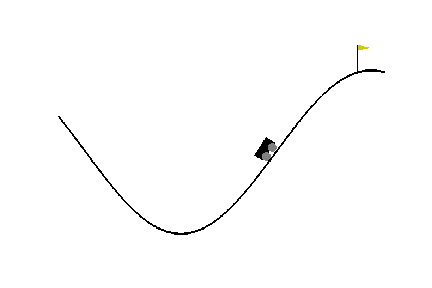
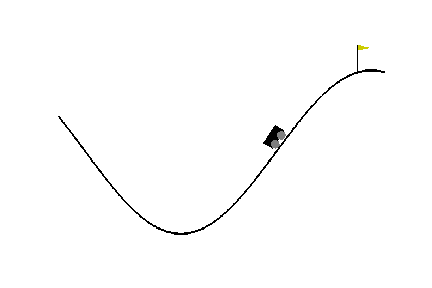
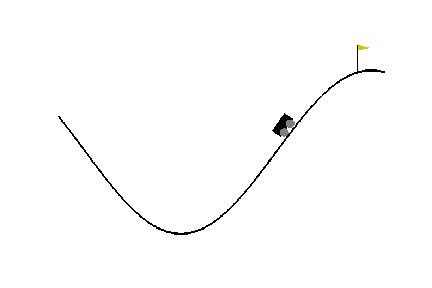
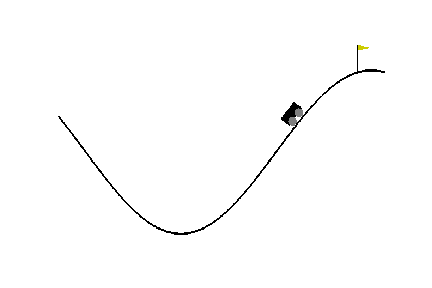
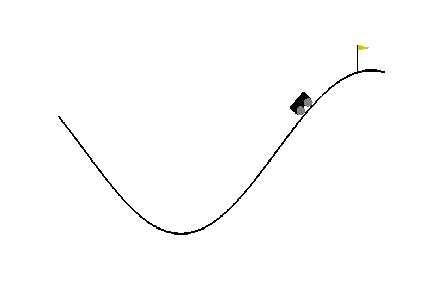
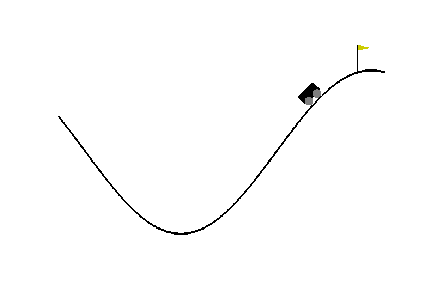
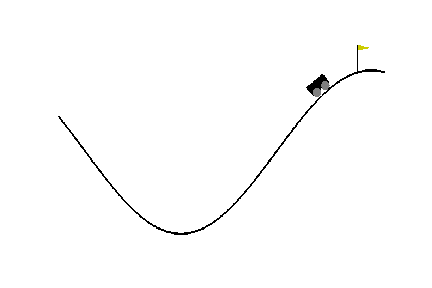
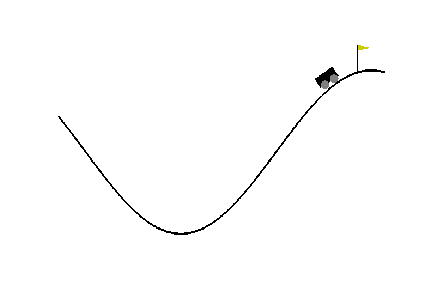
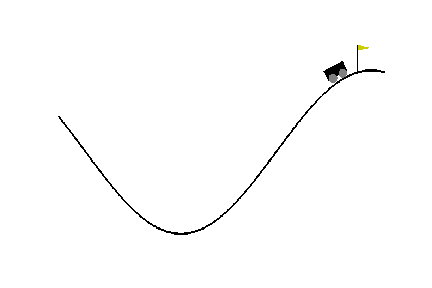
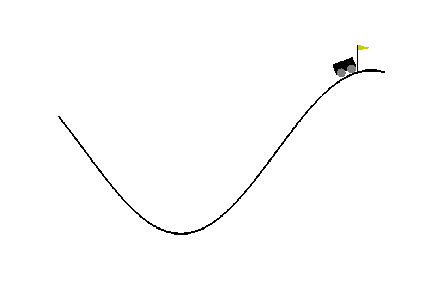
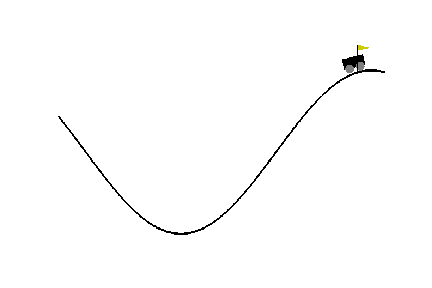

In [10]:
env = gym.make(envname)
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = bc_agent_gauss.control(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)